In [1]:
devtools::install_github("kasaai/deeptriangle")
devtools::install_github("kasaai/insurance")

pillar   (1.7.0   -> 1.8.0) [CRAN]
farver   (2.1.0   -> 2.1.1) [CRAN]
processx (3.6.1   -> 3.7.0) [CRAN]
callr    (3.7.0   -> 3.7.1) [CRAN]
tibble   (3.1.7   -> 3.1.8) [CRAN]
rlang    (1.0.3   -> 1.0.4) [CRAN]
pkgbuild (1.2.0   -> 1.3.1) [CRAN]
Rcpp     (1.0.8.3 -> 1.0.9) [CRAN]
generics (0.1.2   -> 0.1.3) [CRAN]
ggfan    (NA      -> 0.1.3) [CRAN]
keras    (2.6.0   -> 2.9.0) [CRAN]


Installing 11 packages: pillar, farver, processx, callr, tibble, rlang, pkgbuild, Rcpp, generics, ggfan, keras

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘rlang’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘Rcpp’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘generics’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘pillar’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘tibble’ had non-zero exit status”


✔  checking for file ‘/tmp/RtmptE0xAf/remotese135bb90a/kasaai-deeptriangle-ab2dd55/DESCRIPTION’
─  preparing ‘deeptriangle’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘deeptriangle_0.3.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




rlang  (1.0.3 -> 1.0.4) [CRAN]
pillar (1.7.0 -> 1.8.0) [CRAN]
tibble (3.1.7 -> 3.1.8) [CRAN]


Installing 3 packages: rlang, pillar, tibble

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘rlang’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘pillar’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘tibble’ had non-zero exit status”


✔  checking for file ‘/tmp/RtmptE0xAf/remotese6e43dc73/kasaai-insurance-f323fa1/DESCRIPTION’ (478ms)
─  preparing ‘insurance’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘insurance_0.2.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(recipes)
library(insurance)
library(tidyverse)
library(deeptriangle)
library(keras)
library(tensorflow)
library(GA)
library(tictoc)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed()
✖ dplyr::lag()     masks stats::lag()

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Package 'GA' version 3.2.2
Type 'citation("GA")' for citing this R pack

In [3]:
#' Given a time series, return a list
#'  where each element is a vector representing a window
#'  of the time series determined by the offsets
make_series <- function(v, start_offset, end_offset, na_pad = -99) {
  prepad_mask <- function(v, l = 9) {
    length_diff <- l - length(v)
    if (length_diff > 0) {
      c(rep(na_pad, length_diff), v)
    } else {
      v
    }
  }
  
  purrr::map(
    seq_along(v),
    function(x) {
      start <- max(0, x + start_offset)
      end <- max(0, x + end_offset)
      out <- v[start:end]
      ifelse(is.na(out), na_pad, out)
    } %>%
      prepad_mask()
  )
}

mutate_series <- function(data, timesteps = 9) {
  data %>%
    dplyr::group_by(.data$lob, .data$group_code, .data$accident_year) %>%
    dplyr::arrange(.data$lob, .data$group_code, .data$accident_year, .data$development_lag) %>%
    mutate(
      paid_lags = make_series(incremental_paid, -timesteps, -1),
      case_lags = make_series(case_reserves, -timesteps, -1),
      paid_target = make_series(incremental_paid, 0, timesteps - 1),
      case_target = make_series(case_reserves, 0, timesteps - 1),
    ) %>%
    ungroup()
}

prep_keras_data <- function(data, company_index_recipe) {
  lags <- data %>%
    select(.data$paid_lags, .data$case_lags) %>%
    purrr::transpose() %>%
    purrr::map(~ array(unlist(.x), dim = c(1, 9, 2))) %>%
    abind::abind(along = 1) %>%
    unname()
  
  target_paid <- data %>%
    pull(.data$paid_target) %>%
    flatten_dbl() %>%
    array_reshape(c(nrow(data), 9, 1))
  
  target_case <- data %>%
    pull(.data$case_target) %>%
    flatten_dbl() %>%
    array_reshape(c(nrow(data), 9, 1))
  
  company_input <- bake(company_index_recipe, data) %>% as.matrix()
  
  list(
    x = list(
      ay_seq_input = lags, company_input = company_input
    ),
    y = list(
      paid_output = target_paid,
      case_reserves_output = target_case
    )
  )
}

masked_mse <- function(mask_value) {
  function(y_true, y_pred) {
    keep_value <- k_cast(k_not_equal(y_true, mask_value), k_floatx())
    sum_squared_error <- k_sum(
      k_square(keep_value * (y_true - y_pred)),
      axis = 2
    )
    sum_squared_error / k_sum(keep_value, axis = 2)
  }
}

transform_preds <- function(preds) {
  rows <- 1:dim(preds[[1]])[[1]]
  list(
    # predicted_cumulative_loss = map(rows, ~ preds[[1]][, , 2][.x, ]),
    predicted_loss = map(rows, ~ preds[[1]][, , 1][.x, ]),
    predicted_os = map(rows, ~ preds[[2]][, , 1][.x, ])
  ) %>%
    as_tibble()
}

extract_keras_data <- function(data, lob) {
  data %>%
    filter(lob == !!lob) %>%
    pull(.data$keras_data) %>%
    flatten()
}

extract_data <- function(data, lob) {
  data %>%
    filter(lob == !!lob) %>%
    unnest(.data$data)
}

compute_predictions <- function(model, test_data, lob) {
  predictions <- model %>%
    predict(extract_keras_data(test_data, lob)$x) %>%
    transform_preds()
  
  test_data %>%
    unnest(data) %>%
    select(group_code, accident_year, development_lag) %>%
    bind_cols(predictions) %>%
    unnest(predicted_loss, predicted_os) %>%
    group_by(group_code, accident_year) %>%
    mutate(development_lag = development_lag + row_number() - 1) %>%
    filter(development_lag <= 10) %>%
    right_join(
      data_with_features %>%
        filter(lob == !!lob),
      by = c("group_code", "accident_year", "development_lag")
    ) %>%
    arrange(group_code, accident_year, development_lag) %>%
    mutate(
      predicted_os = if_else(
        is.na(predicted_os),
        case_reserves, predicted_os
      ),
      predicted_loss = if_else(
        is.na(predicted_loss),
        incremental_paid, predicted_loss
      )
    ) %>%
    mutate(
      predicted_cumulative_loss = cumsum(predicted_loss) * earned_premium_net,
      predicted_os = predicted_os * earned_premium_net,
      case_reserves_actual = case_reserves_actual * earned_premium_net
    ) %>%
    ungroup() %>%
    gather(
      "type", "value", predicted_cumulative_loss, predicted_os,
      cumulative_paid_loss, case_reserves_actual,
      na.rm = TRUE
    ) %>%
    mutate(
      obs_type = case_when(
        grepl("predicted", type) ~ "prediction",
        calendar_year <= 1997 ~ "observed",
        calendar_year > 1997 ~ "holdout",
        TRUE ~ "observed"
      )
    )
}

In [4]:
data(schedule_p)

data_with_features <- schedule_p %>%
  right_join(dt_group_codes, by = c("lob", "group_code")) %>%
  mutate(case_reserves = incurred_loss - cumulative_paid_loss) %>%
  group_by(lob, group_code, accident_year) %>%
  arrange(lob, group_code, accident_year, development_lag) %>%
  mutate(
    incremental_paid_actual = incremental_paid_loss,
    incremental_paid = ifelse(
      calendar_year <= 1997,
      incremental_paid_actual, NA_real_
    ),
    cumulative_paid_actual = cumulative_paid_loss,
    cumulative_paid = ifelse(
      calendar_year <= 1997,
      cumulative_paid_actual, NA_real_
    ),
    case_reserves_actual = case_reserves,
    case_reserves = ifelse(
      calendar_year <= 1997,
      case_reserves_actual,
      NA_real_
    )
  ) %>%
  ungroup() %>%
  mutate(
    bucket = case_when(
      calendar_year <= 1995 & development_lag > 1 ~ "train",
      calendar_year > 1995 & calendar_year <= 1997 &
        development_lag > 1 ~ "validation",
      calendar_year > 1997 ~ "test"
    )
  ) %>%
  mutate(
    incremental_paid = incremental_paid / earned_premium_net,
    incremental_paid_actual = incremental_paid_actual / earned_premium_net,
    cumulative_paid = cumulative_paid / earned_premium_net,
    cumulative_paid_actual = cumulative_paid_actual / earned_premium_net,
    case_reserves = case_reserves / earned_premium_net,
    case_reserves_actual = case_reserves_actual / earned_premium_net
  )

# Recipe for indexing company code
company_index_recipe <- recipe(~ group_code, data = data_with_features) %>%
  step_integer(group_code, zero_based = TRUE) %>%
  prep()

data_keras <- bind_rows(
  validation_data = data_with_features %>%
    filter(bucket %in% c("train", "validation") | development_lag == 1) %>%
    mutate_series() %>%
    filter(bucket == "validation") %>%
    group_by(lob) %>%
    nest() %>%
    mutate(keras_data = map(data, ~ prep_keras_data(.x, company_index_recipe))),
  full_training_data = data_with_features %>%
    filter(bucket %in% c("train", "validation") | development_lag == 1) %>%
    mutate_series() %>%
    filter(bucket %in% c("train", "validation")) %>%
    group_by(lob) %>%
    nest() %>%
    mutate(keras_data = map(data, ~ prep_keras_data(.x, company_index_recipe))),
  test_data = data_with_features %>%
    filter(calendar_year <= 1998) %>%
    mutate_series() %>%
    filter(bucket == "test", calendar_year == 1998) %>%
    group_by(lob) %>%
    nest() %>%
    mutate(keras_data = map(data, ~ prep_keras_data(.x, company_index_recipe))),
  .id = "data_type"
)

In [5]:
#' Compute performance metrics
#'
#' @param predictions Predictions data frame.
#' @export
dt_compute_metrics <- function(predictions) {
  predictions %>%
    dplyr::filter(
      .data$development_lag == 10,
      .data$type %in% c("cumulative_paid_loss", "predicted_cumulative_loss")
    ) %>%
    dplyr::group_by(.data$lob, .data$group_code, .data$type, .data$run_id) %>%
    dplyr::summarize(ultimate = sum(.data$value)) %>%
    dplyr::group_by(.data$lob, .data$group_code, .data$type) %>%
    dplyr::summarize(ultimate = mean(.data$ultimate)) %>%
    tidyr::spread(.data$type, .data$ultimate) %>%
    dplyr::mutate(
      pct_error = (.data$predicted_cumulative_loss - .data$cumulative_paid_loss) /
        .data$cumulative_paid_loss) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(.data$lob) %>%
    dplyr::summarize(
      mape = mean(abs(.data$pct_error)),
      rmspe = sqrt(mean(.data$pct_error ^ 2))
    ) %>%
    dplyr::mutate(model = "DeepTriangle")
}

#' Tabulate performance metrics for all models
#'
#' @param data Model results in tidy format.
#' @param metric Performance metric.
#' @export
dt_tabulate_metrics <- function(data, metric = c("mape", "rmspe")) {
  metric <- rlang::arg_match(metric)
  data %>%
    dplyr::filter(metric == !!metric) %>%
    dplyr::select(-.data$metric) %>%
    tidyr::spread(.data$model,.data$ value) %>%
    dplyr::select(
      .data$lob, .data$DeepTriangle
    )
}

In [6]:
dt_model2 <- function(rdo1,rdo2,do1,do2) {
  ay_seq_input <- layer_input(shape = list(9, 2), name = "ay_seq_input")
  company_code_input <- layer_input(shape = 1, name = "company_input")
  company_code_embedding <- company_code_input %>%
    layer_embedding(200, 49, name = "company_code_embedding") %>%
    layer_flatten()%>%
    layer_repeat_vector(9)
  
  encoded <- ay_seq_input %>%
    layer_masking(-99) %>%
    layer_gru(units = 128, dropout = 0.2, recurrent_dropout = rdo1)
  
  ay_decoded <- encoded %>%
    layer_repeat_vector(9) %>%
    layer_gru(128, return_sequences = TRUE, dropout = 0.2, recurrent_dropout = rdo2)
  
  decoded=layer_concatenate(list(ay_decoded, company_code_embedding))
    
  case_reserves_output <- decoded %>%
    time_distributed(layer_dense(units = 64, activation = "relu")) %>%
    time_distributed(layer_dropout(rate = do1)) %>%
    time_distributed(layer_dense(units = 1, activation = "relu"), name = "case_reserves_output")
  
  paid_output <- decoded %>%
    time_distributed(layer_dense(units = 64, activation = "relu")) %>%
    time_distributed(layer_dropout(rate = do2)) %>%
    time_distributed(layer_dense(units = 1, activation = "relu"), name = "paid_output")
  
  model <- keras_model(
    inputs = c(ay_seq_input, company_code_input),
    outputs = c(paid_output, case_reserves_output)
  )
  
  model
}

In [7]:
fit_DT=function(rdo1,rdo2,do1,do2,lr)
    {
    lobs <- c("commercial_auto","other_liability", "private_passenger_auto", "workers_compensation")

results <- map_df(lobs, function(lob) {
  data_lob <- data_keras %>%
    filter(lob == !!lob)
  full_training_data_keras <- data_lob %>%
    filter(data_type == "full_training_data") %>%
    pull(keras_data) %>%
    flatten()
  validation_data_keras <- data_lob %>%
    filter(data_type == "validation_data") %>%
    pull(keras_data) %>%
    flatten()
  test_data <- data_lob %>%
    filter(data_type == "test_data")
  
  map_df(1:10, function(run_id) {
    if (run_id %% 10 == 1) k_clear_session()
    cat(sprintf("Training LOB %s run %s: ", lob, run_id))
    start_time <- Sys.time()
    model <- dt_model2(rdo1,rdo2,do1,do2)
    model %>%
      compile(
        optimizer = optimizer_adam(learning_rate = lr, amsgrad = TRUE),
        loss = list(masked_mse(-99), masked_mse(-99)),
        loss_weights = c(0.5, 0.5)
      )
    
    cb <- callback_early_stopping(min_delta = 0.001, patience = 30, mode = "min", restore_best_weights = TRUE)
    
    history <- model %>%
      fit(
        x = full_training_data_keras$x,
        y = full_training_data_keras$y,
        validation_data = unname(validation_data_keras),
        batch_size = 2250,
        epochs = 150,
        callbacks = list(cb),
        verbose = 0
      )
    
    training_time <- as.integer(Sys.time() - start_time)
    
    cat(sprintf("training for %d epochs took %d seconds at %s", cb$stopped_epoch, training_time, Sys.time()), "\n")
    
    predictions_table <- compute_predictions(model, test_data, lob) %>%
      mutate(lob = !!lob, run_id = !!run_id)
    
    tibble(
      lob = lob,
      run_id = run_id,
      training_time = training_time,
      predictions_table = list(predictions_table),
      trained_epochs = cb$stopped_epoch
    )
  })
})
    predictions_table <- results  %>%
      pull(predictions_table) %>%
      bind_rows()
    
    model_results <- dt_compute_metrics(predictions_table) %>%
  gather(metric, value, mape, rmspe)
    MAPE1=model_results$value[1]
    MAPE2=model_results$value[2]
    MAPE3=model_results$value[3]
    MAPE4=model_results$value[4]
    cat("MAPE1 score:", MAPE1)
    cat("\n")
    cat("MAPE2 score:", MAPE2)
    cat("\n")
    cat("MAPE3 score:", MAPE3)
    cat("\n")
    cat("MAPE4 score:", MAPE4)
    cat("\n")
    MAPE=(0.25*MAPE1)+(0.25*MAPE2)+(0.25*MAPE3)+(0.25*MAPE4)
    return(-MAPE)
}

Warning message in ga(type = "real-valued", fitness = function(x) fit_DT(x[1], x[2], :
“The population size is less than 10.”
Loaded Tensorflow version 2.6.5



Training LOB commercial_auto run 1: training for 47 epochs took 14 seconds at 2022-07-27 04:54:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 58 epochs took 9 seconds at 2022-07-27 04:54:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 50 epochs took 8 seconds at 2022-07-27 04:54:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 42 epochs took 8 seconds at 2022-07-27 04:54:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 73 epochs took 10 seconds at 2022-07-27 04:54:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 56 epochs took 9 seconds at 2022-07-27 04:54:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 66 epochs took 9 seconds at 2022-07-27 04:55:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 8 seconds at 2022-07-27 04:55:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 7 seconds at 2022-07-27 04:55:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 50 epochs took 8 seconds at 2022-07-27 04:55:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 51 epochs took 9 seconds at 2022-07-27 04:55:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 73 epochs took 10 seconds at 2022-07-27 04:55:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 57 epochs took 11 seconds at 2022-07-27 04:56:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 76 epochs took 10 seconds at 2022-07-27 04:56:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 51 epochs took 9 seconds at 2022-07-27 04:56:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 56 epochs took 9 seconds at 2022-07-27 04:56:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 54 epochs took 9 seconds at 2022-07-27 04:56:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 84 epochs took 11 seconds at 2022-07-27 04:57:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 45 epochs took 8 seconds at 2022-07-27 04:57:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 61 epochs took 9 seconds at 2022-07-27 04:57:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 8 seconds at 2022-07-27 04:57:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 8 seconds at 2022-07-27 04:57:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 8 seconds at 2022-07-27 04:58:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 8 seconds at 2022-07-27 04:58:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 49 epochs took 8 seconds at 2022-07-27 04:58:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 8 seconds at 2022-07-27 04:58:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 48 epochs took 10 seconds at 2022-07-27 04:58:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 41 epochs took 8 seconds at 2022-07-27 04:58:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 55 epochs took 9 seconds at 2022-07-27 04:59:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-07-27 04:59:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 42 epochs took 8 seconds at 2022-07-27 04:59:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 43 epochs took 8 seconds at 2022-07-27 04:59:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 8 seconds at 2022-07-27 04:59:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 72 epochs took 12 seconds at 2022-07-27 05:00:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 8 seconds at 2022-07-27 05:00:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 61 epochs took 10 seconds at 2022-07-27 05:00:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 8 seconds at 2022-07-27 05:00:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 50 epochs took 8 seconds at 2022-07-27 05:00:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 52 epochs took 9 seconds at 2022-07-27 05:00:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-07-27 05:01:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04736026
MAPE2 score: 0.1042085
MAPE3 score: 0.02628534
MAPE4 score: 0.05230416
Training LOB commercial_auto run 1: training for 56 epochs took 9 seconds at 2022-07-27 05:01:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 57 epochs took 8 seconds at 2022-07-27 05:01:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 47 epochs took 8 seconds at 2022-07-27 05:01:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 56 epochs took 9 seconds at 2022-07-27 05:02:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 74 epochs took 10 seconds at 2022-07-27 05:02:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 60 epochs took 9 seconds at 2022-07-27 05:02:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 47 epochs took 8 seconds at 2022-07-27 05:02:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 81 epochs took 11 seconds at 2022-07-27 05:02:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 49 epochs took 9 seconds at 2022-07-27 05:03:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 64 epochs took 9 seconds at 2022-07-27 05:03:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 67 epochs took 10 seconds at 2022-07-27 05:03:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 50 epochs took 9 seconds at 2022-07-27 05:03:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 71 epochs took 10 seconds at 2022-07-27 05:04:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 79 epochs took 11 seconds at 2022-07-27 05:04:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 83 epochs took 12 seconds at 2022-07-27 05:04:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 71 epochs took 10 seconds at 2022-07-27 05:04:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 63 epochs took 10 seconds at 2022-07-27 05:04:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 53 epochs took 8 seconds at 2022-07-27 05:05:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 66 epochs took 11 seconds at 2022-07-27 05:05:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 77 epochs took 11 seconds at 2022-07-27 05:05:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 47 epochs took 9 seconds at 2022-07-27 05:05:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 8 seconds at 2022-07-27 05:05:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 9 seconds at 2022-07-27 05:06:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 52 epochs took 8 seconds at 2022-07-27 05:06:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 48 epochs took 8 seconds at 2022-07-27 05:06:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 53 epochs took 9 seconds at 2022-07-27 05:06:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 40 epochs took 7 seconds at 2022-07-27 05:06:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 8 seconds at 2022-07-27 05:06:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 9 seconds at 2022-07-27 05:07:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 8 seconds at 2022-07-27 05:07:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 61 epochs took 10 seconds at 2022-07-27 05:07:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 46 epochs took 8 seconds at 2022-07-27 05:07:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 50 epochs took 8 seconds at 2022-07-27 05:07:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 48 epochs took 8 seconds at 2022-07-27 05:07:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 8 seconds at 2022-07-27 05:08:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 9 seconds at 2022-07-27 05:08:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 49 epochs took 8 seconds at 2022-07-27 05:08:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 44 epochs took 8 seconds at 2022-07-27 05:08:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 50 epochs took 8 seconds at 2022-07-27 05:08:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-07-27 05:08:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04945129
MAPE2 score: 0.123906
MAPE3 score: 0.02448981
MAPE4 score: 0.06686602
Training LOB commercial_auto run 1: training for 45 epochs took 8 seconds at 2022-07-27 05:09:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 47 epochs took 8 seconds at 2022-07-27 05:09:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 56 epochs took 8 seconds at 2022-07-27 05:09:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 59 epochs took 17 seconds at 2022-07-27 05:09:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 57 epochs took 9 seconds at 2022-07-27 05:09:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 61 epochs took 9 seconds at 2022-07-27 05:10:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 8 seconds at 2022-07-27 05:10:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 70 epochs took 10 seconds at 2022-07-27 05:10:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 7 seconds at 2022-07-27 05:10:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 49 epochs took 9 seconds at 2022-07-27 05:11:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 41 epochs took 8 seconds at 2022-07-27 05:11:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 43 epochs took 8 seconds at 2022-07-27 05:11:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 43 epochs took 8 seconds at 2022-07-27 05:11:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 58 epochs took 9 seconds at 2022-07-27 05:11:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 62 epochs took 9 seconds at 2022-07-27 05:11:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 53 epochs took 9 seconds at 2022-07-27 05:12:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 43 epochs took 7 seconds at 2022-07-27 05:12:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 46 epochs took 8 seconds at 2022-07-27 05:12:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 42 epochs took 8 seconds at 2022-07-27 05:12:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 44 epochs took 7 seconds at 2022-07-27 05:12:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 8 seconds at 2022-07-27 05:12:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-07-27 05:13:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 61 epochs took 9 seconds at 2022-07-27 05:13:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 67 epochs took 10 seconds at 2022-07-27 05:13:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 05:13:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 8 seconds at 2022-07-27 05:13:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 8 seconds at 2022-07-27 05:13:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 47 epochs took 8 seconds at 2022-07-27 05:14:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 47 epochs took 10 seconds at 2022-07-27 05:14:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 38 epochs took 7 seconds at 2022-07-27 05:14:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 41 epochs took 8 seconds at 2022-07-27 05:14:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 46 epochs took 8 seconds at 2022-07-27 05:14:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 38 epochs took 8 seconds at 2022-07-27 05:14:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 59 epochs took 9 seconds at 2022-07-27 05:15:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 41 epochs took 8 seconds at 2022-07-27 05:15:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 9 seconds at 2022-07-27 05:15:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 8 seconds at 2022-07-27 05:15:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-07-27 05:15:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 47 epochs took 8 seconds at 2022-07-27 05:15:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-07-27 05:16:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05140234
MAPE2 score: 0.1109834
MAPE3 score: 0.02509565
MAPE4 score: 0.04986275
Training LOB commercial_auto run 1: training for 44 epochs took 8 seconds at 2022-07-27 05:16:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 52 epochs took 8 seconds at 2022-07-27 05:16:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 61 epochs took 9 seconds at 2022-07-27 05:16:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 66 epochs took 16 seconds at 2022-07-27 05:16:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 56 epochs took 9 seconds at 2022-07-27 05:17:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 61 epochs took 10 seconds at 2022-07-27 05:17:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 42 epochs took 8 seconds at 2022-07-27 05:17:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 55 epochs took 9 seconds at 2022-07-27 05:17:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 47 epochs took 8 seconds at 2022-07-27 05:17:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 60 epochs took 9 seconds at 2022-07-27 05:18:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 54 epochs took 9 seconds at 2022-07-27 05:18:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 50 epochs took 8 seconds at 2022-07-27 05:18:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 61 epochs took 9 seconds at 2022-07-27 05:18:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 62 epochs took 10 seconds at 2022-07-27 05:18:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 72 epochs took 10 seconds at 2022-07-27 05:19:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 46 epochs took 8 seconds at 2022-07-27 05:19:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 71 epochs took 10 seconds at 2022-07-27 05:19:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 53 epochs took 9 seconds at 2022-07-27 05:19:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 63 epochs took 9 seconds at 2022-07-27 05:19:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 61 epochs took 9 seconds at 2022-07-27 05:20:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 53 epochs took 9 seconds at 2022-07-27 05:20:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 45 epochs took 8 seconds at 2022-07-27 05:20:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 51 epochs took 9 seconds at 2022-07-27 05:20:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 51 epochs took 8 seconds at 2022-07-27 05:20:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 40 epochs took 7 seconds at 2022-07-27 05:21:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 50 epochs took 8 seconds at 2022-07-27 05:21:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 8 seconds at 2022-07-27 05:21:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 40 epochs took 7 seconds at 2022-07-27 05:21:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 41 epochs took 9 seconds at 2022-07-27 05:21:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 8 seconds at 2022-07-27 05:21:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 67 epochs took 10 seconds at 2022-07-27 05:22:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 52 epochs took 8 seconds at 2022-07-27 05:22:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 8 seconds at 2022-07-27 05:22:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 50 epochs took 8 seconds at 2022-07-27 05:22:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 47 epochs took 8 seconds at 2022-07-27 05:22:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 48 epochs took 9 seconds at 2022-07-27 05:22:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 8 seconds at 2022-07-27 05:23:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 63 epochs took 9 seconds at 2022-07-27 05:23:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 49 epochs took 8 seconds at 2022-07-27 05:23:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 56 epochs took 8 seconds at 2022-07-27 05:23:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05208933
MAPE2 score: 0.1022897
MAPE3 score: 0.024842
MAPE4 score: 0.04466783
Training LOB commercial_auto run 1: training for 61 epochs took 9 seconds at 2022-07-27 05:23:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 64 epochs took 9 seconds at 2022-07-27 05:24:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 42 epochs took 7 seconds at 2022-07-27 05:24:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 59 epochs took 15 seconds at 2022-07-27 05:24:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 46 epochs took 8 seconds at 2022-07-27 05:24:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 47 epochs took 8 seconds at 2022-07-27 05:24:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 59 epochs took 8 seconds at 2022-07-27 05:25:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 8 seconds at 2022-07-27 05:25:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 05:25:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 51 epochs took 8 seconds at 2022-07-27 05:25:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 42 epochs took 8 seconds at 2022-07-27 05:25:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 47 epochs took 8 seconds at 2022-07-27 05:25:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 62 epochs took 10 seconds at 2022-07-27 05:26:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 8 seconds at 2022-07-27 05:26:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 51 epochs took 9 seconds at 2022-07-27 05:26:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 46 epochs took 7 seconds at 2022-07-27 05:26:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 56 epochs took 9 seconds at 2022-07-27 05:26:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 68 epochs took 10 seconds at 2022-07-27 05:27:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 44 epochs took 7 seconds at 2022-07-27 05:27:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 73 epochs took 9 seconds at 2022-07-27 05:27:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 50 epochs took 9 seconds at 2022-07-27 05:27:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 39 epochs took 7 seconds at 2022-07-27 05:27:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 8 seconds at 2022-07-27 05:27:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 58 epochs took 9 seconds at 2022-07-27 05:28:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 59 epochs took 8 seconds at 2022-07-27 05:28:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 39 epochs took 8 seconds at 2022-07-27 05:28:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 41 epochs took 7 seconds at 2022-07-27 05:28:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 60 epochs took 9 seconds at 2022-07-27 05:28:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 8 seconds at 2022-07-27 05:29:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 8 seconds at 2022-07-27 05:29:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 40 epochs took 7 seconds at 2022-07-27 05:29:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 9 seconds at 2022-07-27 05:29:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 8 seconds at 2022-07-27 05:29:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 40 epochs took 8 seconds at 2022-07-27 05:29:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 8 seconds at 2022-07-27 05:30:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 44 epochs took 8 seconds at 2022-07-27 05:30:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 63 epochs took 9 seconds at 2022-07-27 05:30:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-07-27 05:30:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 41 epochs took 7 seconds at 2022-07-27 05:30:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 9 seconds at 2022-07-27 05:30:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0483779
MAPE2 score: 0.1003091
MAPE3 score: 0.02426493
MAPE4 score: 0.0499171
Training LOB commercial_auto run 1: training for 64 epochs took 9 seconds at 2022-07-27 05:31:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 05:31:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 40 epochs took 7 seconds at 2022-07-27 05:31:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 49 epochs took 7 seconds at 2022-07-27 05:31:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 42 epochs took 7 seconds at 2022-07-27 05:31:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 7 seconds at 2022-07-27 05:31:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 69 epochs took 9 seconds at 2022-07-27 05:32:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 41 epochs took 7 seconds at 2022-07-27 05:32:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 57 epochs took 16 seconds at 2022-07-27 05:32:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 8 seconds at 2022-07-27 05:32:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 56 epochs took 9 seconds at 2022-07-27 05:32:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 43 epochs took 8 seconds at 2022-07-27 05:33:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 45 epochs took 8 seconds at 2022-07-27 05:33:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 64 epochs took 10 seconds at 2022-07-27 05:33:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 62 epochs took 9 seconds at 2022-07-27 05:33:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 66 epochs took 9 seconds at 2022-07-27 05:33:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 55 epochs took 8 seconds at 2022-07-27 05:33:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 68 epochs took 9 seconds at 2022-07-27 05:34:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 56 epochs took 9 seconds at 2022-07-27 05:34:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 68 epochs took 9 seconds at 2022-07-27 05:34:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 7 seconds at 2022-07-27 05:34:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 8 seconds at 2022-07-27 05:35:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 05:35:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 56 epochs took 9 seconds at 2022-07-27 05:35:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 05:35:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 55 epochs took 8 seconds at 2022-07-27 05:35:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 52 epochs took 8 seconds at 2022-07-27 05:35:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 05:36:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 57 epochs took 10 seconds at 2022-07-27 05:36:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 39 epochs took 7 seconds at 2022-07-27 05:36:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 39 epochs took 7 seconds at 2022-07-27 05:36:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-07-27 05:36:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 67 epochs took 9 seconds at 2022-07-27 05:36:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 41 epochs took 7 seconds at 2022-07-27 05:37:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 47 epochs took 8 seconds at 2022-07-27 05:37:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 41 epochs took 13 seconds at 2022-07-27 05:37:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 65 epochs took 9 seconds at 2022-07-27 05:37:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 54 epochs took 9 seconds at 2022-07-27 05:37:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 8 seconds at 2022-07-27 05:37:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 66 epochs took 10 seconds at 2022-07-27 05:38:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04763913
MAPE2 score: 0.1054231
MAPE3 score: 0.02449171
MAPE4 score: 0.04208164
Training LOB commercial_auto run 1: training for 51 epochs took 8 seconds at 2022-07-27 05:38:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 59 epochs took 9 seconds at 2022-07-27 05:38:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 59 epochs took 8 seconds at 2022-07-27 05:38:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 69 epochs took 12 seconds at 2022-07-27 05:38:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 47 epochs took 8 seconds at 2022-07-27 05:39:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 52 epochs took 8 seconds at 2022-07-27 05:39:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 42 epochs took 8 seconds at 2022-07-27 05:39:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 42 epochs took 7 seconds at 2022-07-27 05:39:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 44 epochs took 8 seconds at 2022-07-27 05:39:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 48 epochs took 7 seconds at 2022-07-27 05:39:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 66 epochs took 10 seconds at 2022-07-27 05:40:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 9 seconds at 2022-07-27 05:40:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 85 epochs took 10 seconds at 2022-07-27 05:40:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 47 epochs took 8 seconds at 2022-07-27 05:40:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 51 epochs took 8 seconds at 2022-07-27 05:40:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 52 epochs took 8 seconds at 2022-07-27 05:40:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 101 epochs took 11 seconds at 2022-07-27 05:41:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 66 epochs took 9 seconds at 2022-07-27 05:41:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 59 epochs took 8 seconds at 2022-07-27 05:41:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 68 epochs took 10 seconds at 2022-07-27 05:41:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 8 seconds at 2022-07-27 05:41:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 05:42:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 41 epochs took 7 seconds at 2022-07-27 05:42:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 7 seconds at 2022-07-27 05:42:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 48 epochs took 8 seconds at 2022-07-27 05:42:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 41 epochs took 7 seconds at 2022-07-27 05:42:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 47 epochs took 7 seconds at 2022-07-27 05:42:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 8 seconds at 2022-07-27 05:42:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 8 seconds at 2022-07-27 05:43:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 47 epochs took 11 seconds at 2022-07-27 05:43:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 49 epochs took 9 seconds at 2022-07-27 05:43:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 50 epochs took 8 seconds at 2022-07-27 05:43:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 49 epochs took 8 seconds at 2022-07-27 05:43:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 64 epochs took 10 seconds at 2022-07-27 05:44:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 8 seconds at 2022-07-27 05:44:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 7 seconds at 2022-07-27 05:44:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 47 epochs took 9 seconds at 2022-07-27 05:44:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 45 epochs took 7 seconds at 2022-07-27 05:44:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 50 epochs took 7 seconds at 2022-07-27 05:44:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 45 epochs took 7 seconds at 2022-07-27 05:45:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05151284
MAPE2 score: 0.103372
MAPE3 score: 0.03086319
MAPE4 score: 0.04707882
Training LOB commercial_auto run 1: training for 57 epochs took 9 seconds at 2022-07-27 05:45:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 11 seconds at 2022-07-27 05:45:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 42 epochs took 8 seconds at 2022-07-27 05:45:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 56 epochs took 9 seconds at 2022-07-27 05:45:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-07-27 05:46:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 55 epochs took 8 seconds at 2022-07-27 05:46:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 56 epochs took 8 seconds at 2022-07-27 05:46:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 05:46:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 49 epochs took 8 seconds at 2022-07-27 05:46:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 05:46:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 49 epochs took 8 seconds at 2022-07-27 05:47:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 50 epochs took 8 seconds at 2022-07-27 05:47:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 72 epochs took 10 seconds at 2022-07-27 05:47:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 60 epochs took 9 seconds at 2022-07-27 05:47:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 76 epochs took 10 seconds at 2022-07-27 05:47:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 67 epochs took 10 seconds at 2022-07-27 05:47:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 58 epochs took 8 seconds at 2022-07-27 05:48:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 80 epochs took 11 seconds at 2022-07-27 05:48:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 75 epochs took 10 seconds at 2022-07-27 05:48:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 61 epochs took 8 seconds at 2022-07-27 05:48:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 7 seconds at 2022-07-27 05:48:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-07-27 05:48:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 59 epochs took 11 seconds at 2022-07-27 05:49:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 05:49:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 7 seconds at 2022-07-27 05:49:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 8 seconds at 2022-07-27 05:49:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 40 epochs took 7 seconds at 2022-07-27 05:49:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 49 epochs took 8 seconds at 2022-07-27 05:50:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 41 epochs took 7 seconds at 2022-07-27 05:50:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 8 seconds at 2022-07-27 05:50:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 8 seconds at 2022-07-27 05:50:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 57 epochs took 8 seconds at 2022-07-27 05:50:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 49 epochs took 8 seconds at 2022-07-27 05:50:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 48 epochs took 8 seconds at 2022-07-27 05:50:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 48 epochs took 8 seconds at 2022-07-27 05:51:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 7 seconds at 2022-07-27 05:51:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 70 epochs took 9 seconds at 2022-07-27 05:51:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 68 epochs took 9 seconds at 2022-07-27 05:51:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 78 epochs took 10 seconds at 2022-07-27 05:51:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 51 epochs took 9 seconds at 2022-07-27 05:52:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05079888
MAPE2 score: 0.1188148
MAPE3 score: 0.03012229
MAPE4 score: 0.04710856
Training LOB commercial_auto run 1: training for 63 epochs took 9 seconds at 2022-07-27 05:52:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 46 epochs took 7 seconds at 2022-07-27 05:52:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 60 epochs took 9 seconds at 2022-07-27 05:52:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 48 epochs took 7 seconds at 2022-07-27 05:52:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 61 epochs took 8 seconds at 2022-07-27 05:53:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 12 seconds at 2022-07-27 05:53:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 65 epochs took 9 seconds at 2022-07-27 05:53:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 05:53:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 42 epochs took 8 seconds at 2022-07-27 05:53:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 42 epochs took 7 seconds at 2022-07-27 05:53:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 62 epochs took 9 seconds at 2022-07-27 05:54:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 50 epochs took 8 seconds at 2022-07-27 05:54:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 70 epochs took 9 seconds at 2022-07-27 05:54:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 47 epochs took 8 seconds at 2022-07-27 05:54:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 51 epochs took 7 seconds at 2022-07-27 05:54:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 67 epochs took 9 seconds at 2022-07-27 05:54:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 58 epochs took 10 seconds at 2022-07-27 05:55:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 69 epochs took 10 seconds at 2022-07-27 05:55:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 50 epochs took 8 seconds at 2022-07-27 05:55:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 59 epochs took 9 seconds at 2022-07-27 05:55:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 8 seconds at 2022-07-27 05:55:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 05:56:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 59 epochs took 8 seconds at 2022-07-27 05:56:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 8 seconds at 2022-07-27 05:56:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 48 epochs took 7 seconds at 2022-07-27 05:56:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 40 epochs took 7 seconds at 2022-07-27 05:56:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 05:56:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 05:57:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 70 epochs took 10 seconds at 2022-07-27 05:57:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 05:57:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 8 seconds at 2022-07-27 05:57:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 46 epochs took 7 seconds at 2022-07-27 05:57:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 75 epochs took 9 seconds at 2022-07-27 05:57:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 78 epochs took 11 seconds at 2022-07-27 05:58:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 42 epochs took 7 seconds at 2022-07-27 05:58:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 7 seconds at 2022-07-27 05:58:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 51 epochs took 8 seconds at 2022-07-27 05:58:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 54 epochs took 8 seconds at 2022-07-27 05:58:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 61 epochs took 8 seconds at 2022-07-27 05:59:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 49 epochs took 8 seconds at 2022-07-27 05:59:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05480805
MAPE2 score: 0.1113946
MAPE3 score: 0.02639512
MAPE4 score: 0.04429982
Training LOB commercial_auto run 1: training for 69 epochs took 14 seconds at 2022-07-27 05:59:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 72 epochs took 10 seconds at 2022-07-27 05:59:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 55 epochs took 8 seconds at 2022-07-27 05:59:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 06:00:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 48 epochs took 8 seconds at 2022-07-27 06:00:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 47 epochs took 8 seconds at 2022-07-27 06:00:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 06:00:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 39 epochs took 7 seconds at 2022-07-27 06:00:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 58 epochs took 8 seconds at 2022-07-27 06:00:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 64 epochs took 10 seconds at 2022-07-27 06:01:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 62 epochs took 9 seconds at 2022-07-27 06:01:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 72 epochs took 9 seconds at 2022-07-27 06:01:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-07-27 06:01:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 62 epochs took 9 seconds at 2022-07-27 06:01:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 70 epochs took 9 seconds at 2022-07-27 06:02:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 57 epochs took 8 seconds at 2022-07-27 06:02:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 64 epochs took 10 seconds at 2022-07-27 06:02:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 65 epochs took 9 seconds at 2022-07-27 06:02:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 42 epochs took 7 seconds at 2022-07-27 06:02:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 45 epochs took 8 seconds at 2022-07-27 06:03:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 59 epochs took 9 seconds at 2022-07-27 06:03:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 39 epochs took 9 seconds at 2022-07-27 06:03:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 8 seconds at 2022-07-27 06:03:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 8 seconds at 2022-07-27 06:03:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 37 epochs took 7 seconds at 2022-07-27 06:03:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 9 seconds at 2022-07-27 06:04:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 06:04:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 06:04:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 06:04:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 46 epochs took 9 seconds at 2022-07-27 06:04:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 8 seconds at 2022-07-27 06:04:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-07-27 06:05:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 66 epochs took 9 seconds at 2022-07-27 06:05:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 69 epochs took 9 seconds at 2022-07-27 06:05:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-07-27 06:05:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 42 epochs took 8 seconds at 2022-07-27 06:05:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 62 epochs took 9 seconds at 2022-07-27 06:06:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 44 epochs took 7 seconds at 2022-07-27 06:06:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 58 epochs took 9 seconds at 2022-07-27 06:06:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 70 epochs took 9 seconds at 2022-07-27 06:06:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05378597
MAPE2 score: 0.1073627
MAPE3 score: 0.0251179
MAPE4 score: 0.03944212
Training LOB commercial_auto run 1: training for 52 epochs took 8 seconds at 2022-07-27 06:06:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 44 epochs took 12 seconds at 2022-07-27 06:07:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 49 epochs took 8 seconds at 2022-07-27 06:07:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 64 epochs took 9 seconds at 2022-07-27 06:07:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 61 epochs took 9 seconds at 2022-07-27 06:07:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 60 epochs took 9 seconds at 2022-07-27 06:07:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 50 epochs took 8 seconds at 2022-07-27 06:08:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 64 epochs took 9 seconds at 2022-07-27 06:08:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 49 epochs took 8 seconds at 2022-07-27 06:08:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 06:08:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 72 epochs took 10 seconds at 2022-07-27 06:08:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 73 epochs took 10 seconds at 2022-07-27 06:09:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 68 epochs took 9 seconds at 2022-07-27 06:09:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 64 epochs took 9 seconds at 2022-07-27 06:09:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 66 epochs took 9 seconds at 2022-07-27 06:09:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 54 epochs took 8 seconds at 2022-07-27 06:09:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 49 epochs took 8 seconds at 2022-07-27 06:10:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 58 epochs took 9 seconds at 2022-07-27 06:10:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 59 epochs took 8 seconds at 2022-07-27 06:10:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 69 epochs took 9 seconds at 2022-07-27 06:10:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-07-27 06:10:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 41 epochs took 8 seconds at 2022-07-27 06:10:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 49 epochs took 7 seconds at 2022-07-27 06:11:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 51 epochs took 8 seconds at 2022-07-27 06:11:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 46 epochs took 7 seconds at 2022-07-27 06:11:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 55 epochs took 8 seconds at 2022-07-27 06:11:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 9 seconds at 2022-07-27 06:11:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 40 epochs took 7 seconds at 2022-07-27 06:11:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 06:12:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 06:12:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 8 seconds at 2022-07-27 06:12:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 53 epochs took 8 seconds at 2022-07-27 06:12:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 78 epochs took 10 seconds at 2022-07-27 06:12:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 49 epochs took 8 seconds at 2022-07-27 06:12:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 49 epochs took 7 seconds at 2022-07-27 06:13:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 48 epochs took 8 seconds at 2022-07-27 06:13:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 49 epochs took 8 seconds at 2022-07-27 06:13:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 49 epochs took 8 seconds at 2022-07-27 06:13:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 48 epochs took 8 seconds at 2022-07-27 06:13:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 48 epochs took 9 seconds at 2022-07-27 06:13:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0497522
MAPE2 score: 0.1061648
MAPE3 score: 0.02390974
MAPE4 score: 0.04540722
Training LOB commercial_auto run 1: training for 58 epochs took 9 seconds at 2022-07-27 06:14:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 06:14:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-07-27 06:14:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 52 epochs took 8 seconds at 2022-07-27 06:14:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 46 epochs took 7 seconds at 2022-07-27 06:14:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 59 epochs took 8 seconds at 2022-07-27 06:14:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 59 epochs took 9 seconds at 2022-07-27 06:15:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 68 epochs took 9 seconds at 2022-07-27 06:15:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 56 epochs took 15 seconds at 2022-07-27 06:15:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 56 epochs took 8 seconds at 2022-07-27 06:15:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 55 epochs took 8 seconds at 2022-07-27 06:15:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 59 epochs took 9 seconds at 2022-07-27 06:16:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 45 epochs took 7 seconds at 2022-07-27 06:16:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 66 epochs took 9 seconds at 2022-07-27 06:16:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 51 epochs took 8 seconds at 2022-07-27 06:16:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 56 epochs took 8 seconds at 2022-07-27 06:16:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 65 epochs took 9 seconds at 2022-07-27 06:17:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 51 epochs took 8 seconds at 2022-07-27 06:17:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 55 epochs took 9 seconds at 2022-07-27 06:17:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 66 epochs took 9 seconds at 2022-07-27 06:17:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-07-27 06:17:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 06:17:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 8 seconds at 2022-07-27 06:18:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 50 epochs took 8 seconds at 2022-07-27 06:18:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 06:18:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 06:18:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 47 epochs took 8 seconds at 2022-07-27 06:18:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-07-27 06:18:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 41 epochs took 8 seconds at 2022-07-27 06:19:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 49 epochs took 8 seconds at 2022-07-27 06:19:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 52 epochs took 8 seconds at 2022-07-27 06:19:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 7 seconds at 2022-07-27 06:19:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 47 epochs took 7 seconds at 2022-07-27 06:19:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 40 epochs took 7 seconds at 2022-07-27 06:19:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 42 epochs took 7 seconds at 2022-07-27 06:20:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 40 epochs took 8 seconds at 2022-07-27 06:20:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 8 seconds at 2022-07-27 06:20:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-07-27 06:20:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-07-27 06:20:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-07-27 06:20:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05003862
MAPE2 score: 0.09904038
MAPE3 score: 0.03019984
MAPE4 score: 0.04781878
Training LOB commercial_auto run 1: training for 70 epochs took 10 seconds at 2022-07-27 06:21:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 66 epochs took 9 seconds at 2022-07-27 06:21:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 45 epochs took 8 seconds at 2022-07-27 06:21:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 14 seconds at 2022-07-27 06:21:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 52 epochs took 8 seconds at 2022-07-27 06:21:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 55 epochs took 9 seconds at 2022-07-27 06:22:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 06:22:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 59 epochs took 9 seconds at 2022-07-27 06:22:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 8 seconds at 2022-07-27 06:22:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 65 epochs took 9 seconds at 2022-07-27 06:22:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 43 epochs took 8 seconds at 2022-07-27 06:22:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 57 epochs took 9 seconds at 2022-07-27 06:23:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 46 epochs took 7 seconds at 2022-07-27 06:23:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 65 epochs took 9 seconds at 2022-07-27 06:23:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 75 epochs took 10 seconds at 2022-07-27 06:23:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 45 epochs took 7 seconds at 2022-07-27 06:23:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 56 epochs took 9 seconds at 2022-07-27 06:24:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 67 epochs took 10 seconds at 2022-07-27 06:24:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 42 epochs took 7 seconds at 2022-07-27 06:24:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 65 epochs took 10 seconds at 2022-07-27 06:24:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-07-27 06:24:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 49 epochs took 8 seconds at 2022-07-27 06:24:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 06:25:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 45 epochs took 7 seconds at 2022-07-27 06:25:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 06:25:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 51 epochs took 8 seconds at 2022-07-27 06:25:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 9 seconds at 2022-07-27 06:25:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-07-27 06:25:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 06:26:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 47 epochs took 8 seconds at 2022-07-27 06:26:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 8 seconds at 2022-07-27 06:26:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 42 epochs took 7 seconds at 2022-07-27 06:26:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 13 seconds at 2022-07-27 06:26:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 68 epochs took 10 seconds at 2022-07-27 06:27:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 62 epochs took 9 seconds at 2022-07-27 06:27:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 48 epochs took 9 seconds at 2022-07-27 06:27:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 49 epochs took 8 seconds at 2022-07-27 06:27:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 48 epochs took 8 seconds at 2022-07-27 06:27:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 8 seconds at 2022-07-27 06:27:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 66 epochs took 10 seconds at 2022-07-27 06:28:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05058273
MAPE2 score: 0.1042359
MAPE3 score: 0.02587612
MAPE4 score: 0.04229615
Training LOB commercial_auto run 1: training for 56 epochs took 9 seconds at 2022-07-27 06:28:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 52 epochs took 8 seconds at 2022-07-27 06:28:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 55 epochs took 9 seconds at 2022-07-27 06:28:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 41 epochs took 10 seconds at 2022-07-27 06:28:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 64 epochs took 9 seconds at 2022-07-27 06:29:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 8 seconds at 2022-07-27 06:29:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 73 epochs took 10 seconds at 2022-07-27 06:29:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 68 epochs took 10 seconds at 2022-07-27 06:29:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 55 epochs took 8 seconds at 2022-07-27 06:29:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 8 seconds at 2022-07-27 06:30:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 43 epochs took 9 seconds at 2022-07-27 06:30:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 40 epochs took 7 seconds at 2022-07-27 06:30:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 57 epochs took 9 seconds at 2022-07-27 06:30:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 68 epochs took 11 seconds at 2022-07-27 06:30:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 43 epochs took 7 seconds at 2022-07-27 06:31:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 56 epochs took 8 seconds at 2022-07-27 06:31:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 46 epochs took 8 seconds at 2022-07-27 06:31:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 51 epochs took 9 seconds at 2022-07-27 06:31:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 69 epochs took 9 seconds at 2022-07-27 06:31:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 57 epochs took 9 seconds at 2022-07-27 06:31:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 50 epochs took 8 seconds at 2022-07-27 06:32:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 45 epochs took 9 seconds at 2022-07-27 06:32:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 8 seconds at 2022-07-27 06:32:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 50 epochs took 8 seconds at 2022-07-27 06:32:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 8 seconds at 2022-07-27 06:32:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 69 epochs took 10 seconds at 2022-07-27 06:32:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 06:33:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 8 seconds at 2022-07-27 06:33:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 8 seconds at 2022-07-27 06:33:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 56 epochs took 8 seconds at 2022-07-27 06:33:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 8 seconds at 2022-07-27 06:33:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 8 seconds at 2022-07-27 06:33:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 8 seconds at 2022-07-27 06:34:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 47 epochs took 8 seconds at 2022-07-27 06:34:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 13 seconds at 2022-07-27 06:34:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 50 epochs took 9 seconds at 2022-07-27 06:34:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 54 epochs took 9 seconds at 2022-07-27 06:34:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 49 epochs took 9 seconds at 2022-07-27 06:35:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 41 epochs took 8 seconds at 2022-07-27 06:35:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 48 epochs took 8 seconds at 2022-07-27 06:35:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04389931
MAPE2 score: 0.1027564
MAPE3 score: 0.02349028
MAPE4 score: 0.04798543
Training LOB commercial_auto run 1: training for 42 epochs took 9 seconds at 2022-07-27 06:35:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 45 epochs took 11 seconds at 2022-07-27 06:35:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 8 seconds at 2022-07-27 06:35:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 49 epochs took 9 seconds at 2022-07-27 06:36:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 65 epochs took 9 seconds at 2022-07-27 06:36:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 72 epochs took 10 seconds at 2022-07-27 06:36:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-07-27 06:36:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 57 epochs took 9 seconds at 2022-07-27 06:37:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 74 epochs took 10 seconds at 2022-07-27 06:37:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 42 epochs took 7 seconds at 2022-07-27 06:37:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 66 epochs took 10 seconds at 2022-07-27 06:37:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 67 epochs took 10 seconds at 2022-07-27 06:37:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 51 epochs took 8 seconds at 2022-07-27 06:37:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 49 epochs took 9 seconds at 2022-07-27 06:38:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 58 epochs took 9 seconds at 2022-07-27 06:38:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 69 epochs took 9 seconds at 2022-07-27 06:38:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 62 epochs took 10 seconds at 2022-07-27 06:38:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 65 epochs took 9 seconds at 2022-07-27 06:38:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 55 epochs took 8 seconds at 2022-07-27 06:39:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 66 epochs took 10 seconds at 2022-07-27 06:39:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 70 epochs took 10 seconds at 2022-07-27 06:39:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 9 seconds at 2022-07-27 06:39:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 06:39:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 7 seconds at 2022-07-27 06:40:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 64 epochs took 9 seconds at 2022-07-27 06:40:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 47 epochs took 8 seconds at 2022-07-27 06:40:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 8 seconds at 2022-07-27 06:40:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 41 epochs took 7 seconds at 2022-07-27 06:40:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 41 epochs took 7 seconds at 2022-07-27 06:40:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-07-27 06:41:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 58 epochs took 9 seconds at 2022-07-27 06:41:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 47 epochs took 8 seconds at 2022-07-27 06:41:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 48 epochs took 12 seconds at 2022-07-27 06:41:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 8 seconds at 2022-07-27 06:41:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 40 epochs took 8 seconds at 2022-07-27 06:42:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 41 epochs took 7 seconds at 2022-07-27 06:42:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 67 epochs took 9 seconds at 2022-07-27 06:42:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 41 epochs took 9 seconds at 2022-07-27 06:42:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 47 epochs took 8 seconds at 2022-07-27 06:42:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-07-27 06:42:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05005866
MAPE2 score: 0.1023074
MAPE3 score: 0.02554743
MAPE4 score: 0.04118957
Training LOB commercial_auto run 1: training for 43 epochs took 8 seconds at 2022-07-27 06:43:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 51 epochs took 9 seconds at 2022-07-27 06:43:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 12 seconds at 2022-07-27 06:43:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 8 seconds at 2022-07-27 06:43:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 67 epochs took 10 seconds at 2022-07-27 06:43:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 56 epochs took 9 seconds at 2022-07-27 06:44:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-07-27 06:44:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 46 epochs took 8 seconds at 2022-07-27 06:44:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 7 seconds at 2022-07-27 06:44:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 60 epochs took 9 seconds at 2022-07-27 06:44:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 55 epochs took 9 seconds at 2022-07-27 06:45:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 65 epochs took 9 seconds at 2022-07-27 06:45:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 61 epochs took 10 seconds at 2022-07-27 06:45:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 68 epochs took 9 seconds at 2022-07-27 06:45:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 49 epochs took 8 seconds at 2022-07-27 06:45:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 57 epochs took 9 seconds at 2022-07-27 06:45:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 71 epochs took 9 seconds at 2022-07-27 06:46:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 44 epochs took 7 seconds at 2022-07-27 06:46:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 7 seconds at 2022-07-27 06:46:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 66 epochs took 10 seconds at 2022-07-27 06:46:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 65 epochs took 10 seconds at 2022-07-27 06:46:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 8 seconds at 2022-07-27 06:47:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 7 seconds at 2022-07-27 06:47:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 40 epochs took 7 seconds at 2022-07-27 06:47:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 11 seconds at 2022-07-27 06:47:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 55 epochs took 8 seconds at 2022-07-27 06:47:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 46 epochs took 8 seconds at 2022-07-27 06:48:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 48 epochs took 8 seconds at 2022-07-27 06:48:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 49 epochs took 9 seconds at 2022-07-27 06:48:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 46 epochs took 7 seconds at 2022-07-27 06:48:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 41 epochs took 7 seconds at 2022-07-27 06:48:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 46 epochs took 8 seconds at 2022-07-27 06:48:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 40 epochs took 8 seconds at 2022-07-27 06:48:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 7 seconds at 2022-07-27 06:49:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 40 epochs took 7 seconds at 2022-07-27 06:49:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 42 epochs took 7 seconds at 2022-07-27 06:49:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 41 epochs took 7 seconds at 2022-07-27 06:49:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 48 epochs took 8 seconds at 2022-07-27 06:49:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 9 seconds at 2022-07-27 06:49:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 7 seconds at 2022-07-27 06:50:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.06168418
MAPE2 score: 0.100697
MAPE3 score: 0.02499244
MAPE4 score: 0.05683255
Training LOB commercial_auto run 1: training for 47 epochs took 8 seconds at 2022-07-27 06:50:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 61 epochs took 9 seconds at 2022-07-27 06:50:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 40 epochs took 7 seconds at 2022-07-27 06:50:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 46 epochs took 7 seconds at 2022-07-27 06:50:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 13 seconds at 2022-07-27 06:50:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 55 epochs took 8 seconds at 2022-07-27 06:51:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 58 epochs took 9 seconds at 2022-07-27 06:51:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 62 epochs took 9 seconds at 2022-07-27 06:51:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 67 epochs took 10 seconds at 2022-07-27 06:51:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 61 epochs took 9 seconds at 2022-07-27 06:51:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 56 epochs took 9 seconds at 2022-07-27 06:52:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 51 epochs took 8 seconds at 2022-07-27 06:52:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 57 epochs took 8 seconds at 2022-07-27 06:52:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 67 epochs took 9 seconds at 2022-07-27 06:52:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 44 epochs took 8 seconds at 2022-07-27 06:52:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 45 epochs took 7 seconds at 2022-07-27 06:53:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 58 epochs took 8 seconds at 2022-07-27 06:53:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 66 epochs took 9 seconds at 2022-07-27 06:53:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 47 epochs took 9 seconds at 2022-07-27 06:53:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 65 epochs took 10 seconds at 2022-07-27 06:53:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-07-27 06:53:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 50 epochs took 9 seconds at 2022-07-27 06:54:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 48 epochs took 8 seconds at 2022-07-27 06:54:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 7 seconds at 2022-07-27 06:54:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 41 epochs took 7 seconds at 2022-07-27 06:54:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 50 epochs took 9 seconds at 2022-07-27 06:54:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 06:54:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-07-27 06:55:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 48 epochs took 7 seconds at 2022-07-27 06:55:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-07-27 06:55:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 53 epochs took 9 seconds at 2022-07-27 06:55:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 7 seconds at 2022-07-27 06:55:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 40 epochs took 7 seconds at 2022-07-27 06:55:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 40 epochs took 7 seconds at 2022-07-27 06:56:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 40 epochs took 7 seconds at 2022-07-27 06:56:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 40 epochs took 7 seconds at 2022-07-27 06:56:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 7 seconds at 2022-07-27 06:56:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 62 epochs took 8 seconds at 2022-07-27 06:56:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 57 epochs took 8 seconds at 2022-07-27 06:56:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-07-27 06:57:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04800066
MAPE2 score: 0.0982109
MAPE3 score: 0.03378712
MAPE4 score: 0.04432026
Training LOB commercial_auto run 1: training for 44 epochs took 7 seconds at 2022-07-27 06:57:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 60 epochs took 8 seconds at 2022-07-27 06:57:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 55 epochs took 8 seconds at 2022-07-27 06:57:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 46 epochs took 7 seconds at 2022-07-27 06:57:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 63 epochs took 14 seconds at 2022-07-27 06:57:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 57 epochs took 8 seconds at 2022-07-27 06:58:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 06:58:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 58 epochs took 9 seconds at 2022-07-27 06:58:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 63 epochs took 10 seconds at 2022-07-27 06:58:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 54 epochs took 8 seconds at 2022-07-27 06:58:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 49 epochs took 9 seconds at 2022-07-27 06:59:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 58 epochs took 8 seconds at 2022-07-27 06:59:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 61 epochs took 8 seconds at 2022-07-27 06:59:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 46 epochs took 8 seconds at 2022-07-27 06:59:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 61 epochs took 8 seconds at 2022-07-27 06:59:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 60 epochs took 8 seconds at 2022-07-27 07:00:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 62 epochs took 8 seconds at 2022-07-27 07:00:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 40 epochs took 7 seconds at 2022-07-27 07:00:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 58 epochs took 9 seconds at 2022-07-27 07:00:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 58 epochs took 8 seconds at 2022-07-27 07:00:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 7 seconds at 2022-07-27 07:01:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 9 seconds at 2022-07-27 07:01:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 7 seconds at 2022-07-27 07:01:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 7 seconds at 2022-07-27 07:01:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 40 epochs took 7 seconds at 2022-07-27 07:01:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 48 epochs took 8 seconds at 2022-07-27 07:01:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 57 epochs took 8 seconds at 2022-07-27 07:01:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-07-27 07:02:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 48 epochs took 8 seconds at 2022-07-27 07:02:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-07-27 07:02:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 67 epochs took 9 seconds at 2022-07-27 07:02:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 49 epochs took 8 seconds at 2022-07-27 07:02:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 63 epochs took 8 seconds at 2022-07-27 07:03:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 40 epochs took 8 seconds at 2022-07-27 07:03:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 67 epochs took 9 seconds at 2022-07-27 07:03:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 53 epochs took 8 seconds at 2022-07-27 07:03:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-07-27 07:03:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 42 epochs took 7 seconds at 2022-07-27 07:03:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-07-27 07:04:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 7 seconds at 2022-07-27 07:04:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04692196
MAPE2 score: 0.0994076
MAPE3 score: 0.02503183
MAPE4 score: 0.04232059
Training LOB commercial_auto run 1: training for 39 epochs took 7 seconds at 2022-07-27 07:04:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 45 epochs took 8 seconds at 2022-07-27 07:04:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 07:04:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 57 epochs took 10 seconds at 2022-07-27 07:05:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 48 epochs took 7 seconds at 2022-07-27 07:05:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 42 epochs took 8 seconds at 2022-07-27 07:05:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 70 epochs took 10 seconds at 2022-07-27 07:05:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 51 epochs took 8 seconds at 2022-07-27 07:05:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 47 epochs took 7 seconds at 2022-07-27 07:05:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 59 epochs took 9 seconds at 2022-07-27 07:06:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 64 epochs took 9 seconds at 2022-07-27 07:06:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 70 epochs took 9 seconds at 2022-07-27 07:06:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 59 epochs took 10 seconds at 2022-07-27 07:06:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 43 epochs took 7 seconds at 2022-07-27 07:06:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 65 epochs took 9 seconds at 2022-07-27 07:07:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 60 epochs took 9 seconds at 2022-07-27 07:07:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 65 epochs took 9 seconds at 2022-07-27 07:07:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 64 epochs took 9 seconds at 2022-07-27 07:07:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 69 epochs took 9 seconds at 2022-07-27 07:07:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 41 epochs took 8 seconds at 2022-07-27 07:08:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 8 seconds at 2022-07-27 07:08:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 59 epochs took 8 seconds at 2022-07-27 07:08:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-07-27 07:08:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 7 seconds at 2022-07-27 07:08:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 8 seconds at 2022-07-27 07:08:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 7 seconds at 2022-07-27 07:09:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 58 epochs took 8 seconds at 2022-07-27 07:09:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 40 epochs took 7 seconds at 2022-07-27 07:09:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 51 epochs took 8 seconds at 2022-07-27 07:09:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 48 epochs took 8 seconds at 2022-07-27 07:09:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 38 epochs took 8 seconds at 2022-07-27 07:09:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 46 epochs took 8 seconds at 2022-07-27 07:09:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 7 seconds at 2022-07-27 07:10:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 57 epochs took 8 seconds at 2022-07-27 07:10:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 67 epochs took 9 seconds at 2022-07-27 07:10:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 39 epochs took 7 seconds at 2022-07-27 07:10:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 53 epochs took 8 seconds at 2022-07-27 07:10:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 60 epochs took 10 seconds at 2022-07-27 07:11:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 40 epochs took 7 seconds at 2022-07-27 07:11:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 48 epochs took 8 seconds at 2022-07-27 07:11:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04347966
MAPE2 score: 0.1018682
MAPE3 score: 0.0232508
MAPE4 score: 0.04108308
Training LOB commercial_auto run 1: training for 64 epochs took 9 seconds at 2022-07-27 07:11:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 64 epochs took 9 seconds at 2022-07-27 07:11:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 46 epochs took 7 seconds at 2022-07-27 07:11:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 07:12:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 59 epochs took 9 seconds at 2022-07-27 07:12:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 56 epochs took 15 seconds at 2022-07-27 07:12:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-07-27 07:12:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 59 epochs took 9 seconds at 2022-07-27 07:13:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 8 seconds at 2022-07-27 07:13:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 07:13:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 60 epochs took 9 seconds at 2022-07-27 07:13:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 51 epochs took 8 seconds at 2022-07-27 07:13:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 50 epochs took 8 seconds at 2022-07-27 07:13:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 57 epochs took 9 seconds at 2022-07-27 07:14:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 59 epochs took 8 seconds at 2022-07-27 07:14:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 48 epochs took 7 seconds at 2022-07-27 07:14:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 55 epochs took 8 seconds at 2022-07-27 07:14:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 8 seconds at 2022-07-27 07:14:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 71 epochs took 10 seconds at 2022-07-27 07:14:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 52 epochs took 8 seconds at 2022-07-27 07:15:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 7 seconds at 2022-07-27 07:15:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 64 epochs took 9 seconds at 2022-07-27 07:15:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 51 epochs took 9 seconds at 2022-07-27 07:15:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 57 epochs took 8 seconds at 2022-07-27 07:15:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 46 epochs took 8 seconds at 2022-07-27 07:15:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 74 epochs took 10 seconds at 2022-07-27 07:16:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 07:16:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 9 seconds at 2022-07-27 07:16:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 58 epochs took 8 seconds at 2022-07-27 07:16:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 07:16:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 60 epochs took 9 seconds at 2022-07-27 07:16:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-07-27 07:17:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 7 seconds at 2022-07-27 07:17:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 7 seconds at 2022-07-27 07:17:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 54 epochs took 10 seconds at 2022-07-27 07:17:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-07-27 07:17:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 8 seconds at 2022-07-27 07:17:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 40 epochs took 7 seconds at 2022-07-27 07:18:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 43 epochs took 8 seconds at 2022-07-27 07:18:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 63 epochs took 9 seconds at 2022-07-27 07:18:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05061593
MAPE2 score: 0.1001332
MAPE3 score: 0.02535906
MAPE4 score: 0.04251685
Training LOB commercial_auto run 1: training for 41 epochs took 8 seconds at 2022-07-27 07:18:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 55 epochs took 8 seconds at 2022-07-27 07:18:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 54 epochs took 15 seconds at 2022-07-27 07:19:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 42 epochs took 7 seconds at 2022-07-27 07:19:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 45 epochs took 8 seconds at 2022-07-27 07:19:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 46 epochs took 8 seconds at 2022-07-27 07:19:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 54 epochs took 8 seconds at 2022-07-27 07:19:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 07:19:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 8 seconds at 2022-07-27 07:19:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 42 epochs took 7 seconds at 2022-07-27 07:20:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 63 epochs took 9 seconds at 2022-07-27 07:20:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 65 epochs took 10 seconds at 2022-07-27 07:20:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 60 epochs took 9 seconds at 2022-07-27 07:20:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 64 epochs took 10 seconds at 2022-07-27 07:20:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 43 epochs took 8 seconds at 2022-07-27 07:21:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 58 epochs took 9 seconds at 2022-07-27 07:21:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 65 epochs took 10 seconds at 2022-07-27 07:21:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 62 epochs took 9 seconds at 2022-07-27 07:21:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 51 epochs took 9 seconds at 2022-07-27 07:21:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 68 epochs took 9 seconds at 2022-07-27 07:22:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 8 seconds at 2022-07-27 07:22:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 41 epochs took 8 seconds at 2022-07-27 07:22:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 8 seconds at 2022-07-27 07:22:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 68 epochs took 11 seconds at 2022-07-27 07:22:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 07:22:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 59 epochs took 8 seconds at 2022-07-27 07:23:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 7 seconds at 2022-07-27 07:23:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 07:23:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 07:23:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 9 seconds at 2022-07-27 07:23:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 8 seconds at 2022-07-27 07:23:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 7 seconds at 2022-07-27 07:24:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 50 epochs took 8 seconds at 2022-07-27 07:24:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 61 epochs took 9 seconds at 2022-07-27 07:24:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 7 seconds at 2022-07-27 07:24:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 42 epochs took 8 seconds at 2022-07-27 07:24:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-07-27 07:25:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 46 epochs took 13 seconds at 2022-07-27 07:25:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 56 epochs took 9 seconds at 2022-07-27 07:25:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-07-27 07:25:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05144823
MAPE2 score: 0.1088747
MAPE3 score: 0.02745496
MAPE4 score: 0.04579932
Training LOB commercial_auto run 1: training for 108 epochs took 13 seconds at 2022-07-27 07:25:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 87 epochs took 15 seconds at 2022-07-27 07:26:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 89 epochs took 11 seconds at 2022-07-27 07:26:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 98 epochs took 12 seconds at 2022-07-27 07:26:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 90 epochs took 11 seconds at 2022-07-27 07:26:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 89 epochs took 12 seconds at 2022-07-27 07:27:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 89 epochs took 11 seconds at 2022-07-27 07:27:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 96 epochs took 12 seconds at 2022-07-27 07:27:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 108 epochs took 12 seconds at 2022-07-27 07:27:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 87 epochs took 11 seconds at 2022-07-27 07:28:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 138 epochs took 15 seconds at 2022-07-27 07:28:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 132 epochs took 14 seconds at 2022-07-27 07:28:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 133 epochs took 15 seconds at 2022-07-27 07:29:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 134 epochs took 14 seconds at 2022-07-27 07:29:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 124 epochs took 13 seconds at 2022-07-27 07:29:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 128 epochs took 14 seconds at 2022-07-27 07:29:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 109 epochs took 13 seconds at 2022-07-27 07:30:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 130 epochs took 14 seconds at 2022-07-27 07:30:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 114 epochs took 13 seconds at 2022-07-27 07:30:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 113 epochs took 12 seconds at 2022-07-27 07:31:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 83 epochs took 10 seconds at 2022-07-27 07:31:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 80 epochs took 13 seconds at 2022-07-27 07:31:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 86 epochs took 10 seconds at 2022-07-27 07:31:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 86 epochs took 11 seconds at 2022-07-27 07:32:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 90 epochs took 11 seconds at 2022-07-27 07:32:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 84 epochs took 10 seconds at 2022-07-27 07:32:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 86 epochs took 10 seconds at 2022-07-27 07:32:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 99 epochs took 11 seconds at 2022-07-27 07:33:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 88 epochs took 11 seconds at 2022-07-27 07:33:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 90 epochs took 10 seconds at 2022-07-27 07:33:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 113 epochs took 13 seconds at 2022-07-27 07:33:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 131 epochs took 14 seconds at 2022-07-27 07:34:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 98 epochs took 11 seconds at 2022-07-27 07:34:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 115 epochs took 14 seconds at 2022-07-27 07:34:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 107 epochs took 12 seconds at 2022-07-27 07:34:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 124 epochs took 13 seconds at 2022-07-27 07:34:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 108 epochs took 12 seconds at 2022-07-27 07:35:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 112 epochs took 12 seconds at 2022-07-27 07:35:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 130 epochs took 15 seconds at 2022-07-27 07:35:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 98 epochs took 11 seconds at 2022-07-27 07:36:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05229784
MAPE2 score: 0.09463375
MAPE3 score: 0.02435758
MAPE4 score: 0.0431407
Training LOB commercial_auto run 1: training for 41 epochs took 8 seconds at 2022-07-27 07:36:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 70 epochs took 9 seconds at 2022-07-27 07:36:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 55 epochs took 8 seconds at 2022-07-27 07:36:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 44 epochs took 7 seconds at 2022-07-27 07:36:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 07:36:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 50 epochs took 13 seconds at 2022-07-27 07:37:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 62 epochs took 9 seconds at 2022-07-27 07:37:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 50 epochs took 7 seconds at 2022-07-27 07:37:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 7 seconds at 2022-07-27 07:37:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 52 epochs took 8 seconds at 2022-07-27 07:37:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 55 epochs took 9 seconds at 2022-07-27 07:38:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 47 epochs took 7 seconds at 2022-07-27 07:38:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 60 epochs took 8 seconds at 2022-07-27 07:38:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 8 seconds at 2022-07-27 07:38:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 72 epochs took 9 seconds at 2022-07-27 07:38:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 55 epochs took 8 seconds at 2022-07-27 07:38:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 70 epochs took 9 seconds at 2022-07-27 07:39:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 54 epochs took 8 seconds at 2022-07-27 07:39:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 62 epochs took 8 seconds at 2022-07-27 07:39:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 52 epochs took 8 seconds at 2022-07-27 07:39:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 46 epochs took 7 seconds at 2022-07-27 07:39:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 7 seconds at 2022-07-27 07:40:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 8 seconds at 2022-07-27 07:40:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 56 epochs took 8 seconds at 2022-07-27 07:40:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 39 epochs took 7 seconds at 2022-07-27 07:40:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 66 epochs took 9 seconds at 2022-07-27 07:40:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 56 epochs took 8 seconds at 2022-07-27 07:40:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 41 epochs took 8 seconds at 2022-07-27 07:41:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 39 epochs took 7 seconds at 2022-07-27 07:41:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 51 epochs took 9 seconds at 2022-07-27 07:41:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 56 epochs took 8 seconds at 2022-07-27 07:41:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 63 epochs took 9 seconds at 2022-07-27 07:41:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 48 epochs took 8 seconds at 2022-07-27 07:41:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 41 epochs took 7 seconds at 2022-07-27 07:42:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 47 epochs took 9 seconds at 2022-07-27 07:42:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 7 seconds at 2022-07-27 07:42:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 42 epochs took 7 seconds at 2022-07-27 07:42:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-07-27 07:42:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 65 epochs took 9 seconds at 2022-07-27 07:42:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-07-27 07:43:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04220169
MAPE2 score: 0.1019359
MAPE3 score: 0.02469486
MAPE4 score: 0.04263938
Training LOB commercial_auto run 1: training for 51 epochs took 8 seconds at 2022-07-27 07:43:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 57 epochs took 8 seconds at 2022-07-27 07:43:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 64 epochs took 16 seconds at 2022-07-27 07:43:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 56 epochs took 8 seconds at 2022-07-27 07:43:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 53 epochs took 9 seconds at 2022-07-27 07:44:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 52 epochs took 8 seconds at 2022-07-27 07:44:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 45 epochs took 8 seconds at 2022-07-27 07:44:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 8 seconds at 2022-07-27 07:44:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 07:44:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 50 epochs took 8 seconds at 2022-07-27 07:45:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 71 epochs took 10 seconds at 2022-07-27 07:45:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 80 epochs took 10 seconds at 2022-07-27 07:45:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 44 epochs took 7 seconds at 2022-07-27 07:45:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 60 epochs took 9 seconds at 2022-07-27 07:45:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 64 epochs took 8 seconds at 2022-07-27 07:45:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 44 epochs took 7 seconds at 2022-07-27 07:46:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 61 epochs took 9 seconds at 2022-07-27 07:46:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 59 epochs took 8 seconds at 2022-07-27 07:46:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 7 seconds at 2022-07-27 07:46:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 58 epochs took 9 seconds at 2022-07-27 07:46:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 7 seconds at 2022-07-27 07:47:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 49 epochs took 8 seconds at 2022-07-27 07:47:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 7 seconds at 2022-07-27 07:47:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 59 epochs took 9 seconds at 2022-07-27 07:47:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 07:47:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 07:47:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 40 epochs took 7 seconds at 2022-07-27 07:48:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 07:48:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 48 epochs took 8 seconds at 2022-07-27 07:48:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 07:48:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 7 seconds at 2022-07-27 07:48:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-07-27 07:48:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 7 seconds at 2022-07-27 07:49:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 49 epochs took 7 seconds at 2022-07-27 07:49:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 7 seconds at 2022-07-27 07:49:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 11 seconds at 2022-07-27 07:49:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-07-27 07:49:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 58 epochs took 8 seconds at 2022-07-27 07:49:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 47 epochs took 8 seconds at 2022-07-27 07:50:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 7 seconds at 2022-07-27 07:50:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04973693
MAPE2 score: 0.1016686
MAPE3 score: 0.02895796
MAPE4 score: 0.04556044
Training LOB commercial_auto run 1: training for 60 epochs took 9 seconds at 2022-07-27 07:50:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 44 epochs took 10 seconds at 2022-07-27 07:50:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 62 epochs took 9 seconds at 2022-07-27 07:50:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 61 epochs took 8 seconds at 2022-07-27 07:50:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 42 epochs took 7 seconds at 2022-07-27 07:51:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 47 epochs took 7 seconds at 2022-07-27 07:51:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 61 epochs took 9 seconds at 2022-07-27 07:51:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 51 epochs took 8 seconds at 2022-07-27 07:51:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 07:51:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 07:51:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 59 epochs took 8 seconds at 2022-07-27 07:52:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 52 epochs took 8 seconds at 2022-07-27 07:52:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 62 epochs took 8 seconds at 2022-07-27 07:52:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 53 epochs took 8 seconds at 2022-07-27 07:52:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 67 epochs took 9 seconds at 2022-07-27 07:52:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 66 epochs took 9 seconds at 2022-07-27 07:52:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 62 epochs took 8 seconds at 2022-07-27 07:53:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 45 epochs took 7 seconds at 2022-07-27 07:53:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 58 epochs took 9 seconds at 2022-07-27 07:53:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 71 epochs took 9 seconds at 2022-07-27 07:53:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 40 epochs took 7 seconds at 2022-07-27 07:53:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 07:54:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 69 epochs took 10 seconds at 2022-07-27 07:54:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 39 epochs took 6 seconds at 2022-07-27 07:54:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 8 seconds at 2022-07-27 07:54:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 64 epochs took 9 seconds at 2022-07-27 07:54:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 52 epochs took 7 seconds at 2022-07-27 07:55:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 07:55:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 47 epochs took 11 seconds at 2022-07-27 07:55:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 39 epochs took 7 seconds at 2022-07-27 07:55:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 8 seconds at 2022-07-27 07:55:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 48 epochs took 8 seconds at 2022-07-27 07:55:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-07-27 07:56:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 40 epochs took 8 seconds at 2022-07-27 07:56:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 47 epochs took 7 seconds at 2022-07-27 07:56:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 41 epochs took 7 seconds at 2022-07-27 07:56:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-07-27 07:56:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 45 epochs took 7 seconds at 2022-07-27 07:56:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-07-27 07:56:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 8 seconds at 2022-07-27 07:57:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05252907
MAPE2 score: 0.101387
MAPE3 score: 0.0259683
MAPE4 score: 0.04385795
Training LOB commercial_auto run 1: training for 43 epochs took 8 seconds at 2022-07-27 07:57:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 68 epochs took 9 seconds at 2022-07-27 07:57:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 56 epochs took 8 seconds at 2022-07-27 07:57:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 60 epochs took 8 seconds at 2022-07-27 07:57:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 60 epochs took 8 seconds at 2022-07-27 07:58:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 61 epochs took 12 seconds at 2022-07-27 07:58:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 07:58:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 42 epochs took 7 seconds at 2022-07-27 07:58:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 07:58:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 66 epochs took 9 seconds at 2022-07-27 07:59:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 63 epochs took 9 seconds at 2022-07-27 07:59:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 77 epochs took 9 seconds at 2022-07-27 07:59:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 60 epochs took 8 seconds at 2022-07-27 07:59:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 57 epochs took 8 seconds at 2022-07-27 07:59:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 66 epochs took 9 seconds at 2022-07-27 07:59:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 55 epochs took 9 seconds at 2022-07-27 08:00:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 68 epochs took 9 seconds at 2022-07-27 08:00:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 64 epochs took 9 seconds at 2022-07-27 08:00:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 60 epochs took 9 seconds at 2022-07-27 08:00:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 43 epochs took 7 seconds at 2022-07-27 08:00:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-07-27 08:01:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 08:01:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 52 epochs took 8 seconds at 2022-07-27 08:01:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 7 seconds at 2022-07-27 08:01:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 08:01:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-07-27 08:01:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 7 seconds at 2022-07-27 08:01:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 8 seconds at 2022-07-27 08:02:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 47 epochs took 8 seconds at 2022-07-27 08:02:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 49 epochs took 7 seconds at 2022-07-27 08:02:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 7 seconds at 2022-07-27 08:02:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 42 epochs took 7 seconds at 2022-07-27 08:02:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-07-27 08:02:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 8 seconds at 2022-07-27 08:03:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 65 epochs took 9 seconds at 2022-07-27 08:03:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-07-27 08:03:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 7 seconds at 2022-07-27 08:03:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 46 epochs took 7 seconds at 2022-07-27 08:03:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 67 epochs took 9 seconds at 2022-07-27 08:03:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 45 epochs took 7 seconds at 2022-07-27 08:04:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04694383
MAPE2 score: 0.1006547
MAPE3 score: 0.03634021
MAPE4 score: 0.04451481
Training LOB commercial_auto run 1: training for 56 epochs took 14 seconds at 2022-07-27 08:04:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 47 epochs took 8 seconds at 2022-07-27 08:04:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 49 epochs took 7 seconds at 2022-07-27 08:04:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 54 epochs took 8 seconds at 2022-07-27 08:04:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 48 epochs took 7 seconds at 2022-07-27 08:05:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 48 epochs took 7 seconds at 2022-07-27 08:05:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 63 epochs took 8 seconds at 2022-07-27 08:05:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 63 epochs took 9 seconds at 2022-07-27 08:05:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 67 epochs took 9 seconds at 2022-07-27 08:05:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 49 epochs took 8 seconds at 2022-07-27 08:05:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 58 epochs took 8 seconds at 2022-07-27 08:06:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 56 epochs took 8 seconds at 2022-07-27 08:06:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 72 epochs took 10 seconds at 2022-07-27 08:06:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 79 epochs took 10 seconds at 2022-07-27 08:06:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 76 epochs took 10 seconds at 2022-07-27 08:07:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 56 epochs took 8 seconds at 2022-07-27 08:07:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 84 epochs took 11 seconds at 2022-07-27 08:07:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 77 epochs took 10 seconds at 2022-07-27 08:07:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 59 epochs took 8 seconds at 2022-07-27 08:07:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 58 epochs took 8 seconds at 2022-07-27 08:07:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 8 seconds at 2022-07-27 08:08:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 08:08:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 68 epochs took 9 seconds at 2022-07-27 08:08:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 46 epochs took 7 seconds at 2022-07-27 08:08:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 54 epochs took 8 seconds at 2022-07-27 08:08:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 8 seconds at 2022-07-27 08:08:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 46 epochs took 7 seconds at 2022-07-27 08:09:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 65 epochs took 8 seconds at 2022-07-27 08:09:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 08:09:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 70 epochs took 9 seconds at 2022-07-27 08:09:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 56 epochs took 8 seconds at 2022-07-27 08:09:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 69 epochs took 9 seconds at 2022-07-27 08:09:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 57 epochs took 9 seconds at 2022-07-27 08:10:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 72 epochs took 9 seconds at 2022-07-27 08:10:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 59 epochs took 8 seconds at 2022-07-27 08:10:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 57 epochs took 8 seconds at 2022-07-27 08:10:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 58 epochs took 8 seconds at 2022-07-27 08:10:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 64 epochs took 9 seconds at 2022-07-27 08:11:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 57 epochs took 8 seconds at 2022-07-27 08:11:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 67 epochs took 10 seconds at 2022-07-27 08:11:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04493226
MAPE2 score: 0.09712117
MAPE3 score: 0.02445227
MAPE4 score: 0.04522601
Training LOB commercial_auto run 1: training for 44 epochs took 8 seconds at 2022-07-27 08:11:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 54 epochs took 8 seconds at 2022-07-27 08:11:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-07-27 08:11:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 58 epochs took 8 seconds at 2022-07-27 08:12:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 08:12:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 55 epochs took 8 seconds at 2022-07-27 08:12:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 71 epochs took 9 seconds at 2022-07-27 08:12:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 55 epochs took 8 seconds at 2022-07-27 08:12:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 52 epochs took 8 seconds at 2022-07-27 08:12:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 41 epochs took 7 seconds at 2022-07-27 08:13:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 62 epochs took 9 seconds at 2022-07-27 08:13:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 65 epochs took 9 seconds at 2022-07-27 08:13:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 69 epochs took 9 seconds at 2022-07-27 08:13:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 43 epochs took 7 seconds at 2022-07-27 08:13:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 52 epochs took 8 seconds at 2022-07-27 08:14:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 52 epochs took 8 seconds at 2022-07-27 08:14:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 68 epochs took 9 seconds at 2022-07-27 08:14:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 40 epochs took 7 seconds at 2022-07-27 08:14:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 41 epochs took 7 seconds at 2022-07-27 08:14:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 8 seconds at 2022-07-27 08:14:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 7 seconds at 2022-07-27 08:14:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 52 epochs took 8 seconds at 2022-07-27 08:15:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-07-27 08:15:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 7 seconds at 2022-07-27 08:15:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 61 epochs took 9 seconds at 2022-07-27 08:15:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 7 seconds at 2022-07-27 08:15:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 58 epochs took 8 seconds at 2022-07-27 08:15:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 68 epochs took 9 seconds at 2022-07-27 08:16:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 53 epochs took 8 seconds at 2022-07-27 08:16:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 69 epochs took 9 seconds at 2022-07-27 08:16:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 53 epochs took 8 seconds at 2022-07-27 08:16:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 48 epochs took 8 seconds at 2022-07-27 08:16:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 47 epochs took 7 seconds at 2022-07-27 08:17:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 50 epochs took 7 seconds at 2022-07-27 08:17:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 43 epochs took 8 seconds at 2022-07-27 08:17:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 51 epochs took 9 seconds at 2022-07-27 08:17:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 52 epochs took 8 seconds at 2022-07-27 08:17:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 44 epochs took 8 seconds at 2022-07-27 08:17:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 45 epochs took 7 seconds at 2022-07-27 08:18:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 41 epochs took 7 seconds at 2022-07-27 08:18:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04979229
MAPE2 score: 0.09964798
MAPE3 score: 0.0241764
MAPE4 score: 0.04534881
Training LOB commercial_auto run 1: training for 50 epochs took 8 seconds at 2022-07-27 08:18:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 65 epochs took 9 seconds at 2022-07-27 08:18:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 55 epochs took 8 seconds at 2022-07-27 08:18:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 40 epochs took 8 seconds at 2022-07-27 08:18:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 56 epochs took 8 seconds at 2022-07-27 08:19:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 49 epochs took 15 seconds at 2022-07-27 08:19:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 64 epochs took 9 seconds at 2022-07-27 08:19:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 08:19:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 53 epochs took 9 seconds at 2022-07-27 08:19:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 57 epochs took 8 seconds at 2022-07-27 08:20:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 46 epochs took 8 seconds at 2022-07-27 08:20:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 75 epochs took 10 seconds at 2022-07-27 08:20:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 60 epochs took 9 seconds at 2022-07-27 08:20:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 48 epochs took 8 seconds at 2022-07-27 08:21:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 67 epochs took 9 seconds at 2022-07-27 08:21:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 56 epochs took 8 seconds at 2022-07-27 08:21:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 72 epochs took 9 seconds at 2022-07-27 08:21:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 44 epochs took 8 seconds at 2022-07-27 08:21:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 66 epochs took 9 seconds at 2022-07-27 08:21:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 58 epochs took 8 seconds at 2022-07-27 08:22:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 8 seconds at 2022-07-27 08:22:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 39 epochs took 7 seconds at 2022-07-27 08:22:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 8 seconds at 2022-07-27 08:22:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 57 epochs took 8 seconds at 2022-07-27 08:22:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 39 epochs took 7 seconds at 2022-07-27 08:23:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 08:23:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 60 epochs took 9 seconds at 2022-07-27 08:23:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 51 epochs took 9 seconds at 2022-07-27 08:23:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 8 seconds at 2022-07-27 08:23:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 53 epochs took 8 seconds at 2022-07-27 08:23:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 50 epochs took 8 seconds at 2022-07-27 08:23:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-07-27 08:24:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 8 seconds at 2022-07-27 08:24:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 46 epochs took 7 seconds at 2022-07-27 08:24:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 12 seconds at 2022-07-27 08:24:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 8 seconds at 2022-07-27 08:24:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 8 seconds at 2022-07-27 08:25:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 50 epochs took 9 seconds at 2022-07-27 08:25:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 8 seconds at 2022-07-27 08:25:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 46 epochs took 7 seconds at 2022-07-27 08:25:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.045337
MAPE2 score: 0.1045803
MAPE3 score: 0.02422347
MAPE4 score: 0.05211857
Training LOB commercial_auto run 1: training for 52 epochs took 9 seconds at 2022-07-27 08:25:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 70 epochs took 13 seconds at 2022-07-27 08:25:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 72 epochs took 10 seconds at 2022-07-27 08:26:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 65 epochs took 9 seconds at 2022-07-27 08:26:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 49 epochs took 9 seconds at 2022-07-27 08:26:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 49 epochs took 8 seconds at 2022-07-27 08:26:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 70 epochs took 9 seconds at 2022-07-27 08:26:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 50 epochs took 8 seconds at 2022-07-27 08:27:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 49 epochs took 8 seconds at 2022-07-27 08:27:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 74 epochs took 9 seconds at 2022-07-27 08:27:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 66 epochs took 10 seconds at 2022-07-27 08:27:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 81 epochs took 10 seconds at 2022-07-27 08:27:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 70 epochs took 9 seconds at 2022-07-27 08:28:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 81 epochs took 11 seconds at 2022-07-27 08:28:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 62 epochs took 8 seconds at 2022-07-27 08:28:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 57 epochs took 8 seconds at 2022-07-27 08:28:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 57 epochs took 8 seconds at 2022-07-27 08:28:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 59 epochs took 9 seconds at 2022-07-27 08:29:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 82 epochs took 10 seconds at 2022-07-27 08:29:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 58 epochs took 8 seconds at 2022-07-27 08:29:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 7 seconds at 2022-07-27 08:29:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 8 seconds at 2022-07-27 08:29:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 8 seconds at 2022-07-27 08:29:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 48 epochs took 7 seconds at 2022-07-27 08:30:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 67 epochs took 8 seconds at 2022-07-27 08:30:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 8 seconds at 2022-07-27 08:30:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 08:30:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 10 seconds at 2022-07-27 08:30:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 47 epochs took 7 seconds at 2022-07-27 08:30:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 54 epochs took 8 seconds at 2022-07-27 08:31:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 55 epochs took 9 seconds at 2022-07-27 08:31:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 56 epochs took 8 seconds at 2022-07-27 08:31:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 84 epochs took 10 seconds at 2022-07-27 08:31:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 63 epochs took 8 seconds at 2022-07-27 08:31:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 58 epochs took 9 seconds at 2022-07-27 08:32:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 59 epochs took 8 seconds at 2022-07-27 08:32:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 65 epochs took 9 seconds at 2022-07-27 08:32:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 69 epochs took 9 seconds at 2022-07-27 08:32:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 54 epochs took 8 seconds at 2022-07-27 08:32:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 53 epochs took 9 seconds at 2022-07-27 08:33:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04928098
MAPE2 score: 0.09775315
MAPE3 score: 0.02486157
MAPE4 score: 0.04150884
Training LOB commercial_auto run 1: training for 47 epochs took 8 seconds at 2022-07-27 08:33:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 52 epochs took 8 seconds at 2022-07-27 08:33:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 51 epochs took 8 seconds at 2022-07-27 08:33:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 49 epochs took 7 seconds at 2022-07-27 08:33:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 49 epochs took 12 seconds at 2022-07-27 08:33:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 65 epochs took 9 seconds at 2022-07-27 08:34:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 48 epochs took 8 seconds at 2022-07-27 08:34:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 51 epochs took 8 seconds at 2022-07-27 08:34:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 67 epochs took 9 seconds at 2022-07-27 08:34:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 49 epochs took 7 seconds at 2022-07-27 08:34:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 58 epochs took 9 seconds at 2022-07-27 08:35:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 72 epochs took 10 seconds at 2022-07-27 08:35:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-07-27 08:35:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 55 epochs took 8 seconds at 2022-07-27 08:35:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 57 epochs took 8 seconds at 2022-07-27 08:35:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 60 epochs took 9 seconds at 2022-07-27 08:35:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 57 epochs took 9 seconds at 2022-07-27 08:36:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 78 epochs took 10 seconds at 2022-07-27 08:36:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 73 epochs took 9 seconds at 2022-07-27 08:36:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 53 epochs took 10 seconds at 2022-07-27 08:36:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 55 epochs took 8 seconds at 2022-07-27 08:37:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 8 seconds at 2022-07-27 08:37:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 48 epochs took 7 seconds at 2022-07-27 08:37:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 45 epochs took 7 seconds at 2022-07-27 08:37:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 08:37:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 8 seconds at 2022-07-27 08:37:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 72 epochs took 9 seconds at 2022-07-27 08:38:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 47 epochs took 7 seconds at 2022-07-27 08:38:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 47 epochs took 7 seconds at 2022-07-27 08:38:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 8 seconds at 2022-07-27 08:38:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 51 epochs took 8 seconds at 2022-07-27 08:38:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 70 epochs took 9 seconds at 2022-07-27 08:38:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 55 epochs took 8 seconds at 2022-07-27 08:39:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 55 epochs took 8 seconds at 2022-07-27 08:39:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 73 epochs took 10 seconds at 2022-07-27 08:39:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 71 epochs took 9 seconds at 2022-07-27 08:39:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 59 epochs took 8 seconds at 2022-07-27 08:39:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 62 epochs took 9 seconds at 2022-07-27 08:40:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 54 epochs took 8 seconds at 2022-07-27 08:40:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 63 epochs took 8 seconds at 2022-07-27 08:40:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05583127
MAPE2 score: 0.09768235
MAPE3 score: 0.02288628
MAPE4 score: 0.04327866
Training LOB commercial_auto run 1: training for 42 epochs took 11 seconds at 2022-07-27 08:40:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 40 epochs took 7 seconds at 2022-07-27 08:40:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 44 epochs took 9 seconds at 2022-07-27 08:41:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 58 epochs took 8 seconds at 2022-07-27 08:41:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-07-27 08:41:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 40 epochs took 7 seconds at 2022-07-27 08:41:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 55 epochs took 8 seconds at 2022-07-27 08:41:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 08:41:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 71 epochs took 9 seconds at 2022-07-27 08:42:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 71 epochs took 9 seconds at 2022-07-27 08:42:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 43 epochs took 9 seconds at 2022-07-27 08:42:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 82 epochs took 10 seconds at 2022-07-27 08:42:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 72 epochs took 9 seconds at 2022-07-27 08:42:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 59 epochs took 8 seconds at 2022-07-27 08:43:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 60 epochs took 8 seconds at 2022-07-27 08:43:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 44 epochs took 7 seconds at 2022-07-27 08:43:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 86 epochs took 11 seconds at 2022-07-27 08:43:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 49 epochs took 8 seconds at 2022-07-27 08:43:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 41 epochs took 7 seconds at 2022-07-27 08:43:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 51 epochs took 8 seconds at 2022-07-27 08:44:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 8 seconds at 2022-07-27 08:44:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 60 epochs took 8 seconds at 2022-07-27 08:44:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 49 epochs took 7 seconds at 2022-07-27 08:44:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 58 epochs took 8 seconds at 2022-07-27 08:44:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 56 epochs took 8 seconds at 2022-07-27 08:44:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 42 epochs took 8 seconds at 2022-07-27 08:45:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 54 epochs took 8 seconds at 2022-07-27 08:45:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-07-27 08:45:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 08:45:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 46 epochs took 8 seconds at 2022-07-27 08:45:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 40 epochs took 7 seconds at 2022-07-27 08:45:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 65 epochs took 9 seconds at 2022-07-27 08:46:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 39 epochs took 7 seconds at 2022-07-27 08:46:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 7 seconds at 2022-07-27 08:46:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 73 epochs took 9 seconds at 2022-07-27 08:46:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 62 epochs took 9 seconds at 2022-07-27 08:46:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 40 epochs took 7 seconds at 2022-07-27 08:46:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 47 epochs took 7 seconds at 2022-07-27 08:46:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-07-27 08:47:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 7 seconds at 2022-07-27 08:47:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05429284
MAPE2 score: 0.1009486
MAPE3 score: 0.02497956
MAPE4 score: 0.04129248
Training LOB commercial_auto run 1: training for 44 epochs took 8 seconds at 2022-07-27 08:47:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 62 epochs took 8 seconds at 2022-07-27 08:47:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 46 epochs took 7 seconds at 2022-07-27 08:47:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 08:47:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 56 epochs took 8 seconds at 2022-07-27 08:48:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 58 epochs took 8 seconds at 2022-07-27 08:48:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 39 epochs took 13 seconds at 2022-07-27 08:48:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 57 epochs took 8 seconds at 2022-07-27 08:48:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 8 seconds at 2022-07-27 08:48:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 08:49:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 67 epochs took 9 seconds at 2022-07-27 08:49:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 42 epochs took 7 seconds at 2022-07-27 08:49:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 44 epochs took 7 seconds at 2022-07-27 08:49:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 57 epochs took 8 seconds at 2022-07-27 08:49:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 58 epochs took 8 seconds at 2022-07-27 08:49:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 71 epochs took 9 seconds at 2022-07-27 08:50:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 48 epochs took 8 seconds at 2022-07-27 08:50:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 66 epochs took 9 seconds at 2022-07-27 08:50:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 41 epochs took 7 seconds at 2022-07-27 08:50:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 43 epochs took 7 seconds at 2022-07-27 08:50:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-07-27 08:50:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 8 seconds at 2022-07-27 08:51:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 7 seconds at 2022-07-27 08:51:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 45 epochs took 7 seconds at 2022-07-27 08:51:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 57 epochs took 8 seconds at 2022-07-27 08:51:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 42 epochs took 7 seconds at 2022-07-27 08:51:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 41 epochs took 7 seconds at 2022-07-27 08:51:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 50 epochs took 8 seconds at 2022-07-27 08:52:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 08:52:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 39 epochs took 7 seconds at 2022-07-27 08:52:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 40 epochs took 7 seconds at 2022-07-27 08:52:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 43 epochs took 7 seconds at 2022-07-27 08:52:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 39 epochs took 7 seconds at 2022-07-27 08:52:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 8 seconds at 2022-07-27 08:52:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-07-27 08:53:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 64 epochs took 8 seconds at 2022-07-27 08:53:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-07-27 08:53:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 50 epochs took 8 seconds at 2022-07-27 08:53:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-07-27 08:53:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 45 epochs took 7 seconds at 2022-07-27 08:53:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05441988
MAPE2 score: 0.09783099
MAPE3 score: 0.02482881
MAPE4 score: 0.04403269
Training LOB commercial_auto run 1: training for 49 epochs took 8 seconds at 2022-07-27 08:54:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 46 epochs took 13 seconds at 2022-07-27 08:54:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 45 epochs took 8 seconds at 2022-07-27 08:54:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 64 epochs took 9 seconds at 2022-07-27 08:54:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 55 epochs took 8 seconds at 2022-07-27 08:54:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 54 epochs took 8 seconds at 2022-07-27 08:54:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 39 epochs took 7 seconds at 2022-07-27 08:55:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 57 epochs took 8 seconds at 2022-07-27 08:55:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 7 seconds at 2022-07-27 08:55:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 50 epochs took 8 seconds at 2022-07-27 08:55:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 64 epochs took 9 seconds at 2022-07-27 08:55:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 70 epochs took 9 seconds at 2022-07-27 08:55:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-07-27 08:56:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 70 epochs took 9 seconds at 2022-07-27 08:56:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 49 epochs took 7 seconds at 2022-07-27 08:56:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 59 epochs took 8 seconds at 2022-07-27 08:56:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 41 epochs took 8 seconds at 2022-07-27 08:56:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-07-27 08:56:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 40 epochs took 7 seconds at 2022-07-27 08:57:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 61 epochs took 8 seconds at 2022-07-27 08:57:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-07-27 08:57:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 08:57:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 7 seconds at 2022-07-27 08:57:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 46 epochs took 9 seconds at 2022-07-27 08:57:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 08:58:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 7 seconds at 2022-07-27 08:58:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 49 epochs took 8 seconds at 2022-07-27 08:58:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-07-27 08:58:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 08:58:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 60 epochs took 9 seconds at 2022-07-27 08:58:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 49 epochs took 8 seconds at 2022-07-27 08:59:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 8 seconds at 2022-07-27 08:59:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 42 epochs took 7 seconds at 2022-07-27 08:59:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 53 epochs took 8 seconds at 2022-07-27 08:59:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 60 epochs took 8 seconds at 2022-07-27 08:59:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 58 epochs took 8 seconds at 2022-07-27 08:59:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 42 epochs took 7 seconds at 2022-07-27 09:00:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 68 epochs took 10 seconds at 2022-07-27 09:00:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-07-27 09:00:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 66 epochs took 9 seconds at 2022-07-27 09:00:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04981548
MAPE2 score: 0.106418
MAPE3 score: 0.02398379
MAPE4 score: 0.0388301
Training LOB commercial_auto run 1: training for 64 epochs took 9 seconds at 2022-07-27 09:00:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-07-27 09:00:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 09:01:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 56 epochs took 8 seconds at 2022-07-27 09:01:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 55 epochs took 8 seconds at 2022-07-27 09:01:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 58 epochs took 9 seconds at 2022-07-27 09:01:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 14 seconds at 2022-07-27 09:01:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 68 epochs took 9 seconds at 2022-07-27 09:01:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 8 seconds at 2022-07-27 09:02:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 60 epochs took 8 seconds at 2022-07-27 09:02:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 64 epochs took 9 seconds at 2022-07-27 09:02:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 49 epochs took 8 seconds at 2022-07-27 09:02:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-07-27 09:02:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 7 seconds at 2022-07-27 09:03:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 58 epochs took 9 seconds at 2022-07-27 09:03:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 62 epochs took 8 seconds at 2022-07-27 09:03:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 53 epochs took 7 seconds at 2022-07-27 09:03:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-07-27 09:03:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 52 epochs took 8 seconds at 2022-07-27 09:03:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 68 epochs took 9 seconds at 2022-07-27 09:04:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 57 epochs took 8 seconds at 2022-07-27 09:04:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 8 seconds at 2022-07-27 09:04:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-07-27 09:04:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 47 epochs took 8 seconds at 2022-07-27 09:04:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 7 seconds at 2022-07-27 09:04:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 09:05:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 09:05:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 7 seconds at 2022-07-27 09:05:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 41 epochs took 7 seconds at 2022-07-27 09:05:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 52 epochs took 7 seconds at 2022-07-27 09:05:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 8 seconds at 2022-07-27 09:05:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 41 epochs took 7 seconds at 2022-07-27 09:05:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 72 epochs took 9 seconds at 2022-07-27 09:06:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-07-27 09:06:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 57 epochs took 8 seconds at 2022-07-27 09:06:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 42 epochs took 8 seconds at 2022-07-27 09:06:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 50 epochs took 7 seconds at 2022-07-27 09:06:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-07-27 09:06:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 40 epochs took 7 seconds at 2022-07-27 09:07:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-07-27 09:07:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05368886
MAPE2 score: 0.1059691
MAPE3 score: 0.02241132
MAPE4 score: 0.04364645
Training LOB commercial_auto run 1: training for 62 epochs took 8 seconds at 2022-07-27 09:07:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 46 epochs took 7 seconds at 2022-07-27 09:07:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-07-27 09:07:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 09:07:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 62 epochs took 15 seconds at 2022-07-27 09:08:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 69 epochs took 9 seconds at 2022-07-27 09:08:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 40 epochs took 7 seconds at 2022-07-27 09:08:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 09:08:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 7 seconds at 2022-07-27 09:08:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 09:08:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 43 epochs took 8 seconds at 2022-07-27 09:09:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 69 epochs took 9 seconds at 2022-07-27 09:09:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 54 epochs took 8 seconds at 2022-07-27 09:09:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 60 epochs took 9 seconds at 2022-07-27 09:09:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 61 epochs took 8 seconds at 2022-07-27 09:09:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 84 epochs took 10 seconds at 2022-07-27 09:10:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 65 epochs took 10 seconds at 2022-07-27 09:10:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 60 epochs took 8 seconds at 2022-07-27 09:10:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 58 epochs took 8 seconds at 2022-07-27 09:10:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 7 seconds at 2022-07-27 09:10:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 47 epochs took 7 seconds at 2022-07-27 09:10:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 60 epochs took 8 seconds at 2022-07-27 09:11:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 7 seconds at 2022-07-27 09:11:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 8 seconds at 2022-07-27 09:11:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 09:11:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 59 epochs took 8 seconds at 2022-07-27 09:11:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 09:11:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 8 seconds at 2022-07-27 09:11:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 71 epochs took 9 seconds at 2022-07-27 09:12:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 41 epochs took 7 seconds at 2022-07-27 09:12:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 68 epochs took 9 seconds at 2022-07-27 09:12:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 42 epochs took 7 seconds at 2022-07-27 09:12:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 54 epochs took 8 seconds at 2022-07-27 09:12:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 9 seconds at 2022-07-27 09:13:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 51 epochs took 7 seconds at 2022-07-27 09:13:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 44 epochs took 7 seconds at 2022-07-27 09:13:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 7 seconds at 2022-07-27 09:13:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 46 epochs took 8 seconds at 2022-07-27 09:13:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 7 seconds at 2022-07-27 09:13:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 8 seconds at 2022-07-27 09:13:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05234594
MAPE2 score: 0.09950659
MAPE3 score: 0.02449791
MAPE4 score: 0.04269101
Training LOB commercial_auto run 1: training for 50 epochs took 8 seconds at 2022-07-27 09:14:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 09:14:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 66 epochs took 8 seconds at 2022-07-27 09:14:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 41 epochs took 7 seconds at 2022-07-27 09:14:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 68 epochs took 9 seconds at 2022-07-27 09:14:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 42 epochs took 7 seconds at 2022-07-27 09:15:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 12 seconds at 2022-07-27 09:15:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 09:15:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 09:15:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 66 epochs took 9 seconds at 2022-07-27 09:15:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 74 epochs took 10 seconds at 2022-07-27 09:16:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 56 epochs took 8 seconds at 2022-07-27 09:16:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 47 epochs took 7 seconds at 2022-07-27 09:16:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 80 epochs took 11 seconds at 2022-07-27 09:16:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 47 epochs took 7 seconds at 2022-07-27 09:16:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 49 epochs took 8 seconds at 2022-07-27 09:16:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 63 epochs took 8 seconds at 2022-07-27 09:17:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 55 epochs took 9 seconds at 2022-07-27 09:17:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 59 epochs took 8 seconds at 2022-07-27 09:17:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 62 epochs took 8 seconds at 2022-07-27 09:17:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 9 seconds at 2022-07-27 09:17:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 60 epochs took 9 seconds at 2022-07-27 09:18:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 71 epochs took 9 seconds at 2022-07-27 09:18:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 39 epochs took 6 seconds at 2022-07-27 09:18:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 09:18:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 09:18:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 61 epochs took 9 seconds at 2022-07-27 09:18:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 09:19:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 6 seconds at 2022-07-27 09:19:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 50 epochs took 7 seconds at 2022-07-27 09:19:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 48 epochs took 7 seconds at 2022-07-27 09:19:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 49 epochs took 8 seconds at 2022-07-27 09:19:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 8 seconds at 2022-07-27 09:19:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 48 epochs took 8 seconds at 2022-07-27 09:19:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 41 epochs took 7 seconds at 2022-07-27 09:20:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 39 epochs took 6 seconds at 2022-07-27 09:20:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 65 epochs took 8 seconds at 2022-07-27 09:20:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 62 epochs took 8 seconds at 2022-07-27 09:20:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 40 epochs took 9 seconds at 2022-07-27 09:20:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 64 epochs took 9 seconds at 2022-07-27 09:21:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04827624
MAPE2 score: 0.1001534
MAPE3 score: 0.02529931
MAPE4 score: 0.04277133
Training LOB commercial_auto run 1: training for 41 epochs took 7 seconds at 2022-07-27 09:21:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 40 epochs took 7 seconds at 2022-07-27 09:21:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 59 epochs took 8 seconds at 2022-07-27 09:21:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 46 epochs took 8 seconds at 2022-07-27 09:21:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-07-27 09:21:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 41 epochs took 12 seconds at 2022-07-27 09:22:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 55 epochs took 8 seconds at 2022-07-27 09:22:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 59 epochs took 9 seconds at 2022-07-27 09:22:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 54 epochs took 8 seconds at 2022-07-27 09:22:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 09:22:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 43 epochs took 8 seconds at 2022-07-27 09:22:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 64 epochs took 9 seconds at 2022-07-27 09:23:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 45 epochs took 9 seconds at 2022-07-27 09:23:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 49 epochs took 7 seconds at 2022-07-27 09:23:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 60 epochs took 9 seconds at 2022-07-27 09:23:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 41 epochs took 7 seconds at 2022-07-27 09:23:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 42 epochs took 6 seconds at 2022-07-27 09:24:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 72 epochs took 9 seconds at 2022-07-27 09:24:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 46 epochs took 8 seconds at 2022-07-27 09:24:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 65 epochs took 8 seconds at 2022-07-27 09:24:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-07-27 09:24:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 39 epochs took 7 seconds at 2022-07-27 09:25:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 37 epochs took 7 seconds at 2022-07-27 09:25:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 48 epochs took 7 seconds at 2022-07-27 09:25:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 69 epochs took 9 seconds at 2022-07-27 09:25:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 7 seconds at 2022-07-27 09:25:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 53 epochs took 9 seconds at 2022-07-27 09:25:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 69 epochs took 9 seconds at 2022-07-27 09:26:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 09:26:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 09:26:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 64 epochs took 9 seconds at 2022-07-27 09:26:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-07-27 09:26:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-07-27 09:26:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 49 epochs took 7 seconds at 2022-07-27 09:27:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 42 epochs took 8 seconds at 2022-07-27 09:27:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 40 epochs took 7 seconds at 2022-07-27 09:27:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 8 seconds at 2022-07-27 09:27:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 48 epochs took 9 seconds at 2022-07-27 09:27:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 68 epochs took 8 seconds at 2022-07-27 09:27:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 49 epochs took 7 seconds at 2022-07-27 09:28:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05460079
MAPE2 score: 0.09945258
MAPE3 score: 0.02431988
MAPE4 score: 0.04320359
Training LOB commercial_auto run 1: training for 42 epochs took 7 seconds at 2022-07-27 09:28:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 50 epochs took 8 seconds at 2022-07-27 09:28:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 62 epochs took 8 seconds at 2022-07-27 09:28:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 69 epochs took 9 seconds at 2022-07-27 09:28:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 58 epochs took 13 seconds at 2022-07-27 09:28:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 7 seconds at 2022-07-27 09:29:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 67 epochs took 9 seconds at 2022-07-27 09:29:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 39 epochs took 8 seconds at 2022-07-27 09:29:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 52 epochs took 7 seconds at 2022-07-27 09:29:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 09:29:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 61 epochs took 9 seconds at 2022-07-27 09:30:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 49 epochs took 7 seconds at 2022-07-27 09:30:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 55 epochs took 8 seconds at 2022-07-27 09:30:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 68 epochs took 9 seconds at 2022-07-27 09:30:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 70 epochs took 9 seconds at 2022-07-27 09:30:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 62 epochs took 8 seconds at 2022-07-27 09:30:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 55 epochs took 8 seconds at 2022-07-27 09:31:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 41 epochs took 7 seconds at 2022-07-27 09:31:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 53 epochs took 8 seconds at 2022-07-27 09:31:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 7 seconds at 2022-07-27 09:31:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 50 epochs took 9 seconds at 2022-07-27 09:31:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 09:31:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 7 seconds at 2022-07-27 09:32:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 7 seconds at 2022-07-27 09:32:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 54 epochs took 9 seconds at 2022-07-27 09:32:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-07-27 09:32:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 47 epochs took 7 seconds at 2022-07-27 09:32:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-07-27 09:32:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 40 epochs took 7 seconds at 2022-07-27 09:32:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 09:33:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 7 seconds at 2022-07-27 09:33:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 7 seconds at 2022-07-27 09:33:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 40 epochs took 7 seconds at 2022-07-27 09:33:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-07-27 09:33:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 47 epochs took 9 seconds at 2022-07-27 09:33:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 7 seconds at 2022-07-27 09:34:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 42 epochs took 7 seconds at 2022-07-27 09:34:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 45 epochs took 7 seconds at 2022-07-27 09:34:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 41 epochs took 7 seconds at 2022-07-27 09:34:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 51 epochs took 7 seconds at 2022-07-27 09:34:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0427886
MAPE2 score: 0.1056989
MAPE3 score: 0.02788572
MAPE4 score: 0.04477286
Training LOB commercial_auto run 1: training for 54 epochs took 8 seconds at 2022-07-27 09:34:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 39 epochs took 7 seconds at 2022-07-27 09:35:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 59 epochs took 9 seconds at 2022-07-27 09:35:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 40 epochs took 7 seconds at 2022-07-27 09:35:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-07-27 09:35:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 09:35:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 40 epochs took 7 seconds at 2022-07-27 09:35:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 65 epochs took 9 seconds at 2022-07-27 09:36:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 7 seconds at 2022-07-27 09:36:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 67 epochs took 10 seconds at 2022-07-27 09:36:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 71 epochs took 10 seconds at 2022-07-27 09:36:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 66 epochs took 9 seconds at 2022-07-27 09:36:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 43 epochs took 8 seconds at 2022-07-27 09:37:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 71 epochs took 9 seconds at 2022-07-27 09:37:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 59 epochs took 9 seconds at 2022-07-27 09:37:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 44 epochs took 8 seconds at 2022-07-27 09:37:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 68 epochs took 9 seconds at 2022-07-27 09:37:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-07-27 09:38:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 56 epochs took 9 seconds at 2022-07-27 09:38:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 59 epochs took 8 seconds at 2022-07-27 09:38:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 48 epochs took 7 seconds at 2022-07-27 09:38:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 09:38:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 48 epochs took 8 seconds at 2022-07-27 09:38:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 09:39:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 58 epochs took 8 seconds at 2022-07-27 09:39:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 50 epochs took 7 seconds at 2022-07-27 09:39:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 65 epochs took 8 seconds at 2022-07-27 09:39:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 52 epochs took 10 seconds at 2022-07-27 09:39:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-07-27 09:39:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 39 epochs took 6 seconds at 2022-07-27 09:40:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 7 seconds at 2022-07-27 09:40:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 43 epochs took 7 seconds at 2022-07-27 09:40:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 8 seconds at 2022-07-27 09:40:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-07-27 09:40:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 52 epochs took 8 seconds at 2022-07-27 09:40:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-07-27 09:40:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 69 epochs took 9 seconds at 2022-07-27 09:41:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 40 epochs took 7 seconds at 2022-07-27 09:41:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 7 seconds at 2022-07-27 09:41:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 54 epochs took 8 seconds at 2022-07-27 09:41:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05011156
MAPE2 score: 0.1002968
MAPE3 score: 0.02319548
MAPE4 score: 0.04217965
Training LOB commercial_auto run 1: training for 67 epochs took 9 seconds at 2022-07-27 09:41:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 54 epochs took 8 seconds at 2022-07-27 09:41:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 63 epochs took 8 seconds at 2022-07-27 09:42:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 49 epochs took 7 seconds at 2022-07-27 09:42:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 56 epochs took 8 seconds at 2022-07-27 09:42:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 48 epochs took 13 seconds at 2022-07-27 09:42:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 39 epochs took 7 seconds at 2022-07-27 09:42:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 52 epochs took 8 seconds at 2022-07-27 09:43:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 09:43:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 64 epochs took 8 seconds at 2022-07-27 09:43:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 64 epochs took 9 seconds at 2022-07-27 09:43:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 43 epochs took 7 seconds at 2022-07-27 09:43:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-07-27 09:43:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 61 epochs took 8 seconds at 2022-07-27 09:44:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 64 epochs took 8 seconds at 2022-07-27 09:44:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 55 epochs took 7 seconds at 2022-07-27 09:44:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 58 epochs took 8 seconds at 2022-07-27 09:44:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 60 epochs took 8 seconds at 2022-07-27 09:44:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 7 seconds at 2022-07-27 09:44:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 67 epochs took 9 seconds at 2022-07-27 09:45:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 47 epochs took 9 seconds at 2022-07-27 09:45:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 09:45:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 46 epochs took 7 seconds at 2022-07-27 09:45:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 40 epochs took 7 seconds at 2022-07-27 09:45:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 40 epochs took 7 seconds at 2022-07-27 09:45:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 41 epochs took 7 seconds at 2022-07-27 09:46:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 7 seconds at 2022-07-27 09:46:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 50 epochs took 7 seconds at 2022-07-27 09:46:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 09:46:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 39 epochs took 7 seconds at 2022-07-27 09:46:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 45 epochs took 7 seconds at 2022-07-27 09:46:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 46 epochs took 7 seconds at 2022-07-27 09:46:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 7 seconds at 2022-07-27 09:47:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 42 epochs took 7 seconds at 2022-07-27 09:47:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 7 seconds at 2022-07-27 09:47:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 7 seconds at 2022-07-27 09:47:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 8 seconds at 2022-07-27 09:47:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 41 epochs took 7 seconds at 2022-07-27 09:47:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 40 epochs took 7 seconds at 2022-07-27 09:48:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 46 epochs took 8 seconds at 2022-07-27 09:48:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04349424
MAPE2 score: 0.1031059
MAPE3 score: 0.02672576
MAPE4 score: 0.04660316
Training LOB commercial_auto run 1: training for 42 epochs took 7 seconds at 2022-07-27 09:48:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 64 epochs took 8 seconds at 2022-07-27 09:48:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 42 epochs took 7 seconds at 2022-07-27 09:48:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 42 epochs took 12 seconds at 2022-07-27 09:49:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-07-27 09:49:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 42 epochs took 7 seconds at 2022-07-27 09:49:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 58 epochs took 8 seconds at 2022-07-27 09:49:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 53 epochs took 8 seconds at 2022-07-27 09:49:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 8 seconds at 2022-07-27 09:49:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 09:50:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 44 epochs took 8 seconds at 2022-07-27 09:50:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 73 epochs took 9 seconds at 2022-07-27 09:50:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 46 epochs took 8 seconds at 2022-07-27 09:50:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 41 epochs took 7 seconds at 2022-07-27 09:50:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 41 epochs took 7 seconds at 2022-07-27 09:50:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 59 epochs took 8 seconds at 2022-07-27 09:51:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 42 epochs took 7 seconds at 2022-07-27 09:51:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-07-27 09:51:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 56 epochs took 9 seconds at 2022-07-27 09:51:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 67 epochs took 9 seconds at 2022-07-27 09:51:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 7 seconds at 2022-07-27 09:51:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 09:52:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 59 epochs took 9 seconds at 2022-07-27 09:52:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 40 epochs took 7 seconds at 2022-07-27 09:52:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 48 epochs took 7 seconds at 2022-07-27 09:52:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 09:52:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 09:52:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 9 seconds at 2022-07-27 09:52:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 57 epochs took 8 seconds at 2022-07-27 09:53:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 59 epochs took 9 seconds at 2022-07-27 09:53:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 7 seconds at 2022-07-27 09:53:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 49 epochs took 7 seconds at 2022-07-27 09:53:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 8 seconds at 2022-07-27 09:53:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 61 epochs took 8 seconds at 2022-07-27 09:54:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 8 seconds at 2022-07-27 09:54:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 40 epochs took 7 seconds at 2022-07-27 09:54:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 8 seconds at 2022-07-27 09:54:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 58 epochs took 9 seconds at 2022-07-27 09:54:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 50 epochs took 9 seconds at 2022-07-27 09:55:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 49 epochs took 7 seconds at 2022-07-27 09:55:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05291805
MAPE2 score: 0.09697735
MAPE3 score: 0.02513867
MAPE4 score: 0.04448202
Training LOB commercial_auto run 1: training for 65 epochs took 9 seconds at 2022-07-27 09:55:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 40 epochs took 7 seconds at 2022-07-27 09:55:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 47 epochs took 7 seconds at 2022-07-27 09:55:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 40 epochs took 7 seconds at 2022-07-27 09:55:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 40 epochs took 7 seconds at 2022-07-27 09:55:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 41 epochs took 7 seconds at 2022-07-27 09:56:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 67 epochs took 14 seconds at 2022-07-27 09:56:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 54 epochs took 8 seconds at 2022-07-27 09:56:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 8 seconds at 2022-07-27 09:56:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 09:56:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 60 epochs took 9 seconds at 2022-07-27 09:56:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 71 epochs took 9 seconds at 2022-07-27 09:57:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 58 epochs took 8 seconds at 2022-07-27 09:57:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 47 epochs took 8 seconds at 2022-07-27 09:57:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 44 epochs took 7 seconds at 2022-07-27 09:57:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 71 epochs took 9 seconds at 2022-07-27 09:57:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 68 epochs took 9 seconds at 2022-07-27 09:57:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 63 epochs took 9 seconds at 2022-07-27 09:58:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 76 epochs took 9 seconds at 2022-07-27 09:58:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 59 epochs took 8 seconds at 2022-07-27 09:58:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-07-27 09:58:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-07-27 09:58:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 46 epochs took 7 seconds at 2022-07-27 09:59:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 51 epochs took 7 seconds at 2022-07-27 09:59:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 46 epochs took 7 seconds at 2022-07-27 09:59:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 70 epochs took 10 seconds at 2022-07-27 09:59:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 09:59:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 58 epochs took 8 seconds at 2022-07-27 09:59:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 10:00:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 8 seconds at 2022-07-27 10:00:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 48 epochs took 9 seconds at 2022-07-27 10:00:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 7 seconds at 2022-07-27 10:00:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-07-27 10:00:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 64 epochs took 9 seconds at 2022-07-27 10:00:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 67 epochs took 9 seconds at 2022-07-27 10:01:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 61 epochs took 9 seconds at 2022-07-27 10:01:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-07-27 10:01:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 46 epochs took 9 seconds at 2022-07-27 10:01:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 47 epochs took 7 seconds at 2022-07-27 10:01:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 68 epochs took 9 seconds at 2022-07-27 10:02:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05634663
MAPE2 score: 0.1003564
MAPE3 score: 0.02492542
MAPE4 score: 0.04109552
Training LOB commercial_auto run 1: training for 45 epochs took 7 seconds at 2022-07-27 10:02:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 47 epochs took 7 seconds at 2022-07-27 10:02:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 56 epochs took 8 seconds at 2022-07-27 10:02:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 58 epochs took 8 seconds at 2022-07-27 10:02:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 57 epochs took 14 seconds at 2022-07-27 10:02:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 43 epochs took 7 seconds at 2022-07-27 10:03:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 58 epochs took 8 seconds at 2022-07-27 10:03:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 49 epochs took 8 seconds at 2022-07-27 10:03:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 7 seconds at 2022-07-27 10:03:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 10:03:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 55 epochs took 8 seconds at 2022-07-27 10:03:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 63 epochs took 10 seconds at 2022-07-27 10:04:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 46 epochs took 7 seconds at 2022-07-27 10:04:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 7 seconds at 2022-07-27 10:04:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 63 epochs took 8 seconds at 2022-07-27 10:04:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 42 epochs took 7 seconds at 2022-07-27 10:04:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 42 epochs took 7 seconds at 2022-07-27 10:05:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 57 epochs took 8 seconds at 2022-07-27 10:05:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 53 epochs took 8 seconds at 2022-07-27 10:05:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 55 epochs took 8 seconds at 2022-07-27 10:05:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 8 seconds at 2022-07-27 10:05:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 58 epochs took 8 seconds at 2022-07-27 10:05:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 59 epochs took 8 seconds at 2022-07-27 10:06:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 39 epochs took 7 seconds at 2022-07-27 10:06:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 57 epochs took 8 seconds at 2022-07-27 10:06:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 62 epochs took 8 seconds at 2022-07-27 10:06:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 10:06:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 10:06:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 58 epochs took 8 seconds at 2022-07-27 10:06:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 50 epochs took 7 seconds at 2022-07-27 10:07:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 42 epochs took 8 seconds at 2022-07-27 10:07:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 41 epochs took 7 seconds at 2022-07-27 10:07:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-07-27 10:07:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 7 seconds at 2022-07-27 10:07:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 52 epochs took 8 seconds at 2022-07-27 10:07:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 57 epochs took 8 seconds at 2022-07-27 10:08:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 8 seconds at 2022-07-27 10:08:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 44 epochs took 7 seconds at 2022-07-27 10:08:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 71 epochs took 9 seconds at 2022-07-27 10:08:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 6 seconds at 2022-07-27 10:08:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04758144
MAPE2 score: 0.0985844
MAPE3 score: 0.02569784
MAPE4 score: 0.04301319
Training LOB commercial_auto run 1: training for 47 epochs took 7 seconds at 2022-07-27 10:08:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 52 epochs took 8 seconds at 2022-07-27 10:08:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 45 epochs took 7 seconds at 2022-07-27 10:09:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 65 epochs took 14 seconds at 2022-07-27 10:09:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 52 epochs took 8 seconds at 2022-07-27 10:09:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 64 epochs took 9 seconds at 2022-07-27 10:09:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-07-27 10:09:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 56 epochs took 8 seconds at 2022-07-27 10:10:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 70 epochs took 9 seconds at 2022-07-27 10:10:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 65 epochs took 9 seconds at 2022-07-27 10:10:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 56 epochs took 8 seconds at 2022-07-27 10:10:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 63 epochs took 9 seconds at 2022-07-27 10:10:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 60 epochs took 9 seconds at 2022-07-27 10:11:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 71 epochs took 9 seconds at 2022-07-27 10:11:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 73 epochs took 9 seconds at 2022-07-27 10:11:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 80 epochs took 10 seconds at 2022-07-27 10:11:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 43 epochs took 8 seconds at 2022-07-27 10:11:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 75 epochs took 9 seconds at 2022-07-27 10:12:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 64 epochs took 9 seconds at 2022-07-27 10:12:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 75 epochs took 9 seconds at 2022-07-27 10:12:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 8 seconds at 2022-07-27 10:12:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-07-27 10:12:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 47 epochs took 7 seconds at 2022-07-27 10:12:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 69 epochs took 9 seconds at 2022-07-27 10:13:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 8 seconds at 2022-07-27 10:13:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 10:13:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 7 seconds at 2022-07-27 10:13:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 10:13:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 10:13:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 51 epochs took 7 seconds at 2022-07-27 10:14:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 56 epochs took 10 seconds at 2022-07-27 10:14:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 74 epochs took 9 seconds at 2022-07-27 10:14:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 7 seconds at 2022-07-27 10:14:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 7 seconds at 2022-07-27 10:14:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 7 seconds at 2022-07-27 10:14:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 49 epochs took 7 seconds at 2022-07-27 10:15:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 8 seconds at 2022-07-27 10:15:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 58 epochs took 8 seconds at 2022-07-27 10:15:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 7 seconds at 2022-07-27 10:15:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 45 epochs took 7 seconds at 2022-07-27 10:15:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05204689
MAPE2 score: 0.1024311
MAPE3 score: 0.0237888
MAPE4 score: 0.04639557
Training LOB commercial_auto run 1: training for 44 epochs took 7 seconds at 2022-07-27 10:15:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 51 epochs took 7 seconds at 2022-07-27 10:15:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 60 epochs took 8 seconds at 2022-07-27 10:16:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 64 epochs took 9 seconds at 2022-07-27 10:16:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 58 epochs took 14 seconds at 2022-07-27 10:16:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 43 epochs took 7 seconds at 2022-07-27 10:16:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 65 epochs took 9 seconds at 2022-07-27 10:16:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 41 epochs took 7 seconds at 2022-07-27 10:17:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 39 epochs took 7 seconds at 2022-07-27 10:17:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 60 epochs took 8 seconds at 2022-07-27 10:17:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 62 epochs took 9 seconds at 2022-07-27 10:17:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 43 epochs took 7 seconds at 2022-07-27 10:17:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 72 epochs took 9 seconds at 2022-07-27 10:18:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 63 epochs took 8 seconds at 2022-07-27 10:18:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 44 epochs took 7 seconds at 2022-07-27 10:18:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 73 epochs took 9 seconds at 2022-07-27 10:18:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 60 epochs took 8 seconds at 2022-07-27 10:18:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 73 epochs took 9 seconds at 2022-07-27 10:19:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 70 epochs took 9 seconds at 2022-07-27 10:19:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 67 epochs took 8 seconds at 2022-07-27 10:19:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 8 seconds at 2022-07-27 10:19:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 59 epochs took 8 seconds at 2022-07-27 10:19:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 56 epochs took 8 seconds at 2022-07-27 10:19:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 52 epochs took 8 seconds at 2022-07-27 10:19:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 10:20:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 42 epochs took 7 seconds at 2022-07-27 10:20:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 10:20:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 7 seconds at 2022-07-27 10:20:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 10:20:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 10:20:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 42 epochs took 7 seconds at 2022-07-27 10:21:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 50 epochs took 7 seconds at 2022-07-27 10:21:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 56 epochs took 9 seconds at 2022-07-27 10:21:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 61 epochs took 8 seconds at 2022-07-27 10:21:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 63 epochs took 9 seconds at 2022-07-27 10:21:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 48 epochs took 7 seconds at 2022-07-27 10:21:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-07-27 10:21:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 51 epochs took 8 seconds at 2022-07-27 10:22:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 45 epochs took 10 seconds at 2022-07-27 10:22:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 53 epochs took 8 seconds at 2022-07-27 10:22:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04660624
MAPE2 score: 0.1010151
MAPE3 score: 0.02916748
MAPE4 score: 0.04423833
Training LOB commercial_auto run 1: training for 57 epochs took 8 seconds at 2022-07-27 10:22:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 72 epochs took 9 seconds at 2022-07-27 10:22:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 49 epochs took 7 seconds at 2022-07-27 10:22:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 45 epochs took 7 seconds at 2022-07-27 10:23:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 55 epochs took 8 seconds at 2022-07-27 10:23:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 74 epochs took 14 seconds at 2022-07-27 10:23:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 10:23:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 54 epochs took 8 seconds at 2022-07-27 10:23:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 54 epochs took 8 seconds at 2022-07-27 10:24:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 10:24:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 59 epochs took 8 seconds at 2022-07-27 10:24:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 65 epochs took 9 seconds at 2022-07-27 10:24:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 44 epochs took 7 seconds at 2022-07-27 10:24:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 41 epochs took 7 seconds at 2022-07-27 10:25:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 60 epochs took 9 seconds at 2022-07-27 10:25:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 59 epochs took 9 seconds at 2022-07-27 10:25:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 57 epochs took 9 seconds at 2022-07-27 10:25:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 45 epochs took 8 seconds at 2022-07-27 10:25:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 8 seconds at 2022-07-27 10:25:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 63 epochs took 9 seconds at 2022-07-27 10:26:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 7 seconds at 2022-07-27 10:26:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 55 epochs took 9 seconds at 2022-07-27 10:26:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 40 epochs took 7 seconds at 2022-07-27 10:26:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 8 seconds at 2022-07-27 10:26:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 7 seconds at 2022-07-27 10:26:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 8 seconds at 2022-07-27 10:27:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 8 seconds at 2022-07-27 10:27:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 51 epochs took 8 seconds at 2022-07-27 10:27:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 8 seconds at 2022-07-27 10:27:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 10:27:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 52 epochs took 8 seconds at 2022-07-27 10:28:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 43 epochs took 9 seconds at 2022-07-27 10:28:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 8 seconds at 2022-07-27 10:28:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 70 epochs took 10 seconds at 2022-07-27 10:28:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-07-27 10:28:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-07-27 10:28:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 53 epochs took 8 seconds at 2022-07-27 10:29:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 49 epochs took 9 seconds at 2022-07-27 10:29:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 64 epochs took 9 seconds at 2022-07-27 10:29:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 48 epochs took 8 seconds at 2022-07-27 10:29:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04507225
MAPE2 score: 0.1036996
MAPE3 score: 0.03226028
MAPE4 score: 0.03983997
Training LOB commercial_auto run 1: training for 40 epochs took 7 seconds at 2022-07-27 10:29:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 46 epochs took 7 seconds at 2022-07-27 10:30:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 45 epochs took 7 seconds at 2022-07-27 10:30:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 44 epochs took 7 seconds at 2022-07-27 10:30:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 45 epochs took 8 seconds at 2022-07-27 10:30:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 13 seconds at 2022-07-27 10:30:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 50 epochs took 8 seconds at 2022-07-27 10:30:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 54 epochs took 8 seconds at 2022-07-27 10:31:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 10:31:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 8 seconds at 2022-07-27 10:31:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 58 epochs took 8 seconds at 2022-07-27 10:31:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 75 epochs took 9 seconds at 2022-07-27 10:31:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 60 epochs took 9 seconds at 2022-07-27 10:32:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 45 epochs took 7 seconds at 2022-07-27 10:32:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 41 epochs took 7 seconds at 2022-07-27 10:32:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 43 epochs took 7 seconds at 2022-07-27 10:32:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 56 epochs took 8 seconds at 2022-07-27 10:32:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 66 epochs took 9 seconds at 2022-07-27 10:32:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 56 epochs took 8 seconds at 2022-07-27 10:33:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 56 epochs took 8 seconds at 2022-07-27 10:33:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 39 epochs took 9 seconds at 2022-07-27 10:33:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 7 seconds at 2022-07-27 10:33:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 41 epochs took 7 seconds at 2022-07-27 10:33:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 7 seconds at 2022-07-27 10:33:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 39 epochs took 7 seconds at 2022-07-27 10:33:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 42 epochs took 7 seconds at 2022-07-27 10:34:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 46 epochs took 8 seconds at 2022-07-27 10:34:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-07-27 10:34:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 50 epochs took 8 seconds at 2022-07-27 10:34:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 49 epochs took 7 seconds at 2022-07-27 10:34:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 48 epochs took 8 seconds at 2022-07-27 10:34:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-07-27 10:35:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-07-27 10:35:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 53 epochs took 8 seconds at 2022-07-27 10:35:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 64 epochs took 11 seconds at 2022-07-27 10:35:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 39 epochs took 7 seconds at 2022-07-27 10:35:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 47 epochs took 7 seconds at 2022-07-27 10:35:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-07-27 10:36:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 7 seconds at 2022-07-27 10:36:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-07-27 10:36:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05896207
MAPE2 score: 0.1056515
MAPE3 score: 0.03379931
MAPE4 score: 0.04554008
Training LOB commercial_auto run 1: training for 43 epochs took 11 seconds at 2022-07-27 10:36:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 52 epochs took 8 seconds at 2022-07-27 10:36:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-07-27 10:36:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 58 epochs took 9 seconds at 2022-07-27 10:37:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 57 epochs took 9 seconds at 2022-07-27 10:37:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 53 epochs took 8 seconds at 2022-07-27 10:37:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 40 epochs took 7 seconds at 2022-07-27 10:37:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 8 seconds at 2022-07-27 10:37:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 10:37:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 10:38:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 66 epochs took 10 seconds at 2022-07-27 10:38:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 41 epochs took 7 seconds at 2022-07-27 10:38:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-07-27 10:38:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 60 epochs took 8 seconds at 2022-07-27 10:38:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 67 epochs took 9 seconds at 2022-07-27 10:38:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 59 epochs took 8 seconds at 2022-07-27 10:39:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 81 epochs took 9 seconds at 2022-07-27 10:39:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 56 epochs took 9 seconds at 2022-07-27 10:39:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 63 epochs took 8 seconds at 2022-07-27 10:39:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 62 epochs took 8 seconds at 2022-07-27 10:39:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 66 epochs took 9 seconds at 2022-07-27 10:40:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 40 epochs took 8 seconds at 2022-07-27 10:40:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 61 epochs took 8 seconds at 2022-07-27 10:40:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 53 epochs took 8 seconds at 2022-07-27 10:40:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 40 epochs took 7 seconds at 2022-07-27 10:40:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 61 epochs took 8 seconds at 2022-07-27 10:40:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 9 seconds at 2022-07-27 10:41:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 10:41:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 8 seconds at 2022-07-27 10:41:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 67 epochs took 9 seconds at 2022-07-27 10:41:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 7 seconds at 2022-07-27 10:41:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 8 seconds at 2022-07-27 10:42:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 54 epochs took 8 seconds at 2022-07-27 10:42:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 70 epochs took 9 seconds at 2022-07-27 10:42:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 54 epochs took 7 seconds at 2022-07-27 10:42:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 44 epochs took 7 seconds at 2022-07-27 10:42:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 64 epochs took 10 seconds at 2022-07-27 10:42:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 39 epochs took 7 seconds at 2022-07-27 10:43:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 66 epochs took 8 seconds at 2022-07-27 10:43:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 54 epochs took 8 seconds at 2022-07-27 10:43:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0501462
MAPE2 score: 0.1082513
MAPE3 score: 0.02539431
MAPE4 score: 0.04108407
Training LOB commercial_auto run 1: training for 55 epochs took 8 seconds at 2022-07-27 10:43:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 54 epochs took 8 seconds at 2022-07-27 10:43:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 65 epochs took 8 seconds at 2022-07-27 10:44:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 48 epochs took 13 seconds at 2022-07-27 10:44:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 72 epochs took 9 seconds at 2022-07-27 10:44:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 52 epochs took 8 seconds at 2022-07-27 10:44:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 54 epochs took 8 seconds at 2022-07-27 10:44:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 52 epochs took 9 seconds at 2022-07-27 10:44:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 40 epochs took 7 seconds at 2022-07-27 10:45:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 41 epochs took 7 seconds at 2022-07-27 10:45:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 43 epochs took 8 seconds at 2022-07-27 10:45:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 68 epochs took 10 seconds at 2022-07-27 10:45:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 58 epochs took 8 seconds at 2022-07-27 10:45:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 43 epochs took 7 seconds at 2022-07-27 10:45:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 42 epochs took 7 seconds at 2022-07-27 10:46:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 66 epochs took 9 seconds at 2022-07-27 10:46:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 59 epochs took 8 seconds at 2022-07-27 10:46:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 52 epochs took 8 seconds at 2022-07-27 10:46:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 65 epochs took 9 seconds at 2022-07-27 10:46:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 45 epochs took 7 seconds at 2022-07-27 10:47:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 52 epochs took 8 seconds at 2022-07-27 10:47:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 52 epochs took 7 seconds at 2022-07-27 10:47:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 49 epochs took 7 seconds at 2022-07-27 10:47:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 10:47:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 46 epochs took 7 seconds at 2022-07-27 10:47:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 10:47:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 8 seconds at 2022-07-27 10:48:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 10:48:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 71 epochs took 9 seconds at 2022-07-27 10:48:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 40 epochs took 7 seconds at 2022-07-27 10:48:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 61 epochs took 9 seconds at 2022-07-27 10:48:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-07-27 10:48:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 47 epochs took 10 seconds at 2022-07-27 10:49:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 7 seconds at 2022-07-27 10:49:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 7 seconds at 2022-07-27 10:49:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-07-27 10:49:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 40 epochs took 7 seconds at 2022-07-27 10:49:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 68 epochs took 9 seconds at 2022-07-27 10:49:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 41 epochs took 6 seconds at 2022-07-27 10:50:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 7 seconds at 2022-07-27 10:50:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04436711
MAPE2 score: 0.09610854
MAPE3 score: 0.02290957
MAPE4 score: 0.04511519
Training LOB commercial_auto run 1: training for 59 epochs took 8 seconds at 2022-07-27 10:50:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 59 epochs took 12 seconds at 2022-07-27 10:50:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 10:50:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 63 epochs took 8 seconds at 2022-07-27 10:50:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 9 seconds at 2022-07-27 10:51:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 42 epochs took 7 seconds at 2022-07-27 10:51:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 57 epochs took 8 seconds at 2022-07-27 10:51:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 50 epochs took 8 seconds at 2022-07-27 10:51:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 54 epochs took 8 seconds at 2022-07-27 10:51:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 64 epochs took 9 seconds at 2022-07-27 10:51:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 60 epochs took 8 seconds at 2022-07-27 10:52:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 63 epochs took 8 seconds at 2022-07-27 10:52:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 67 epochs took 9 seconds at 2022-07-27 10:52:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 43 epochs took 7 seconds at 2022-07-27 10:52:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 49 epochs took 8 seconds at 2022-07-27 10:52:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 59 epochs took 9 seconds at 2022-07-27 10:52:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 62 epochs took 8 seconds at 2022-07-27 10:53:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 43 epochs took 7 seconds at 2022-07-27 10:53:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 75 epochs took 9 seconds at 2022-07-27 10:53:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 79 epochs took 10 seconds at 2022-07-27 10:53:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 7 seconds at 2022-07-27 10:53:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-07-27 10:54:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-07-27 10:54:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 7 seconds at 2022-07-27 10:54:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 8 seconds at 2022-07-27 10:54:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 56 epochs took 8 seconds at 2022-07-27 10:54:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 59 epochs took 8 seconds at 2022-07-27 10:54:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 10:54:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 65 epochs took 9 seconds at 2022-07-27 10:55:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 10:55:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 52 epochs took 7 seconds at 2022-07-27 10:55:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 7 seconds at 2022-07-27 10:55:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 42 epochs took 7 seconds at 2022-07-27 10:55:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 54 epochs took 8 seconds at 2022-07-27 10:56:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 61 epochs took 8 seconds at 2022-07-27 10:56:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 54 epochs took 8 seconds at 2022-07-27 10:56:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 9 seconds at 2022-07-27 10:56:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 42 epochs took 7 seconds at 2022-07-27 10:56:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 69 epochs took 9 seconds at 2022-07-27 10:56:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-07-27 10:57:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04269558
MAPE2 score: 0.1001627
MAPE3 score: 0.02269883
MAPE4 score: 0.04218585
Training LOB commercial_auto run 1: training for 39 epochs took 7 seconds at 2022-07-27 10:57:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 68 epochs took 9 seconds at 2022-07-27 10:57:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 50 epochs took 7 seconds at 2022-07-27 10:57:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 51 epochs took 13 seconds at 2022-07-27 10:57:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 47 epochs took 7 seconds at 2022-07-27 10:57:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 68 epochs took 9 seconds at 2022-07-27 10:58:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 64 epochs took 9 seconds at 2022-07-27 10:58:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 71 epochs took 9 seconds at 2022-07-27 10:58:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 46 epochs took 7 seconds at 2022-07-27 10:58:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 41 epochs took 7 seconds at 2022-07-27 10:58:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 53 epochs took 9 seconds at 2022-07-27 10:59:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 9 seconds at 2022-07-27 10:59:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 64 epochs took 9 seconds at 2022-07-27 10:59:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 48 epochs took 8 seconds at 2022-07-27 10:59:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 44 epochs took 8 seconds at 2022-07-27 10:59:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 68 epochs took 9 seconds at 2022-07-27 10:59:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 62 epochs took 9 seconds at 2022-07-27 11:00:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 58 epochs took 9 seconds at 2022-07-27 11:00:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 44 epochs took 7 seconds at 2022-07-27 11:00:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 41 epochs took 7 seconds at 2022-07-27 11:00:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-07-27 11:00:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 11:00:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 11:01:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 60 epochs took 8 seconds at 2022-07-27 11:01:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 60 epochs took 8 seconds at 2022-07-27 11:01:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 8 seconds at 2022-07-27 11:01:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 46 epochs took 7 seconds at 2022-07-27 11:01:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-07-27 11:01:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 11:02:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 11:02:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 39 epochs took 7 seconds at 2022-07-27 11:02:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 53 epochs took 9 seconds at 2022-07-27 11:02:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 41 epochs took 7 seconds at 2022-07-27 11:02:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 49 epochs took 7 seconds at 2022-07-27 11:02:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 40 epochs took 6 seconds at 2022-07-27 11:02:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-07-27 11:03:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 47 epochs took 8 seconds at 2022-07-27 11:03:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 59 epochs took 9 seconds at 2022-07-27 11:03:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-07-27 11:03:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 6 seconds at 2022-07-27 11:03:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04967645
MAPE2 score: 0.1033285
MAPE3 score: 0.02571089
MAPE4 score: 0.04723446
Training LOB commercial_auto run 1: training for 55 epochs took 8 seconds at 2022-07-27 11:03:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 11:03:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 42 epochs took 7 seconds at 2022-07-27 11:04:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 57 epochs took 8 seconds at 2022-07-27 11:04:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 12 seconds at 2022-07-27 11:04:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 7 seconds at 2022-07-27 11:04:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 40 epochs took 7 seconds at 2022-07-27 11:04:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 40 epochs took 7 seconds at 2022-07-27 11:04:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 6 seconds at 2022-07-27 11:05:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 55 epochs took 8 seconds at 2022-07-27 11:05:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 56 epochs took 8 seconds at 2022-07-27 11:05:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 78 epochs took 9 seconds at 2022-07-27 11:05:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-07-27 11:05:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 67 epochs took 9 seconds at 2022-07-27 11:05:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 51 epochs took 7 seconds at 2022-07-27 11:06:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 61 epochs took 9 seconds at 2022-07-27 11:06:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 60 epochs took 9 seconds at 2022-07-27 11:06:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-07-27 11:06:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 62 epochs took 9 seconds at 2022-07-27 11:06:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 6 seconds at 2022-07-27 11:06:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 7 seconds at 2022-07-27 11:07:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 51 epochs took 8 seconds at 2022-07-27 11:07:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 7 seconds at 2022-07-27 11:07:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 8 seconds at 2022-07-27 11:07:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 62 epochs took 8 seconds at 2022-07-27 11:07:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 42 epochs took 7 seconds at 2022-07-27 11:07:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 46 epochs took 7 seconds at 2022-07-27 11:08:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 8 seconds at 2022-07-27 11:08:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 11:08:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 49 epochs took 7 seconds at 2022-07-27 11:08:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 7 seconds at 2022-07-27 11:08:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 50 epochs took 7 seconds at 2022-07-27 11:08:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 8 seconds at 2022-07-27 11:08:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 71 epochs took 9 seconds at 2022-07-27 11:09:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 40 epochs took 6 seconds at 2022-07-27 11:09:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-07-27 11:09:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-07-27 11:09:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 73 epochs took 9 seconds at 2022-07-27 11:09:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-07-27 11:10:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 9 seconds at 2022-07-27 11:10:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05423473
MAPE2 score: 0.102175
MAPE3 score: 0.02358942
MAPE4 score: 0.04391519
Training LOB commercial_auto run 1: training for 47 epochs took 8 seconds at 2022-07-27 11:10:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 53 epochs took 8 seconds at 2022-07-27 11:10:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 48 epochs took 7 seconds at 2022-07-27 11:10:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 44 epochs took 7 seconds at 2022-07-27 11:10:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 6 seconds at 2022-07-27 11:10:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 54 epochs took 8 seconds at 2022-07-27 11:11:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 42 epochs took 12 seconds at 2022-07-27 11:11:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 63 epochs took 8 seconds at 2022-07-27 11:11:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 54 epochs took 8 seconds at 2022-07-27 11:11:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 11:11:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 73 epochs took 10 seconds at 2022-07-27 11:12:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 43 epochs took 7 seconds at 2022-07-27 11:12:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 71 epochs took 9 seconds at 2022-07-27 11:12:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 50 epochs took 8 seconds at 2022-07-27 11:12:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 63 epochs took 8 seconds at 2022-07-27 11:12:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 55 epochs took 8 seconds at 2022-07-27 11:12:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 44 epochs took 7 seconds at 2022-07-27 11:13:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 44 epochs took 7 seconds at 2022-07-27 11:13:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 66 epochs took 8 seconds at 2022-07-27 11:13:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 64 epochs took 9 seconds at 2022-07-27 11:13:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 46 epochs took 8 seconds at 2022-07-27 11:13:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 11:13:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-07-27 11:14:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 8 seconds at 2022-07-27 11:14:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 52 epochs took 7 seconds at 2022-07-27 11:14:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 7 seconds at 2022-07-27 11:14:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 11:14:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 54 epochs took 9 seconds at 2022-07-27 11:14:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 62 epochs took 8 seconds at 2022-07-27 11:15:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 66 epochs took 9 seconds at 2022-07-27 11:15:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 51 epochs took 8 seconds at 2022-07-27 11:15:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 71 epochs took 9 seconds at 2022-07-27 11:15:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 39 epochs took 7 seconds at 2022-07-27 11:15:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 47 epochs took 8 seconds at 2022-07-27 11:15:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 40 epochs took 6 seconds at 2022-07-27 11:15:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 62 epochs took 8 seconds at 2022-07-27 11:16:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 47 epochs took 7 seconds at 2022-07-27 11:16:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 63 epochs took 8 seconds at 2022-07-27 11:16:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 40 epochs took 7 seconds at 2022-07-27 11:16:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 7 seconds at 2022-07-27 11:16:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04869541
MAPE2 score: 0.1008502
MAPE3 score: 0.0237417
MAPE4 score: 0.04066692
Training LOB commercial_auto run 1: training for 60 epochs took 8 seconds at 2022-07-27 11:16:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 11:17:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 39 epochs took 7 seconds at 2022-07-27 11:17:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 40 epochs took 7 seconds at 2022-07-27 11:17:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 57 epochs took 8 seconds at 2022-07-27 11:17:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 67 epochs took 9 seconds at 2022-07-27 11:17:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 11:17:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 57 epochs took 8 seconds at 2022-07-27 11:18:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 51 epochs took 8 seconds at 2022-07-27 11:18:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 40 epochs took 7 seconds at 2022-07-27 11:18:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 53 epochs took 9 seconds at 2022-07-27 11:18:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 72 epochs took 9 seconds at 2022-07-27 11:18:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 60 epochs took 8 seconds at 2022-07-27 11:19:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 51 epochs took 8 seconds at 2022-07-27 11:19:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 65 epochs took 9 seconds at 2022-07-27 11:19:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 56 epochs took 8 seconds at 2022-07-27 11:19:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 65 epochs took 10 seconds at 2022-07-27 11:19:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 45 epochs took 7 seconds at 2022-07-27 11:19:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 44 epochs took 7 seconds at 2022-07-27 11:20:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 65 epochs took 9 seconds at 2022-07-27 11:20:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 63 epochs took 10 seconds at 2022-07-27 11:20:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 11:20:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 11:20:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 11:20:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 60 epochs took 9 seconds at 2022-07-27 11:21:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 52 epochs took 7 seconds at 2022-07-27 11:21:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 8 seconds at 2022-07-27 11:21:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 11:21:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 11:21:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 8 seconds at 2022-07-27 11:21:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 45 epochs took 8 seconds at 2022-07-27 11:21:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 43 epochs took 7 seconds at 2022-07-27 11:22:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 7 seconds at 2022-07-27 11:22:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 42 epochs took 7 seconds at 2022-07-27 11:22:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 52 epochs took 8 seconds at 2022-07-27 11:22:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 59 epochs took 8 seconds at 2022-07-27 11:22:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 8 seconds at 2022-07-27 11:22:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 48 epochs took 8 seconds at 2022-07-27 11:23:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 40 epochs took 7 seconds at 2022-07-27 11:23:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 49 epochs took 7 seconds at 2022-07-27 11:23:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04548637
MAPE2 score: 0.1033013
MAPE3 score: 0.02441288
MAPE4 score: 0.0428588
Training LOB commercial_auto run 1: training for 45 epochs took 7 seconds at 2022-07-27 11:23:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 69 epochs took 9 seconds at 2022-07-27 11:23:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-07-27 11:23:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 58 epochs took 8 seconds at 2022-07-27 11:24:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 52 epochs took 8 seconds at 2022-07-27 11:24:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 41 epochs took 7 seconds at 2022-07-27 11:24:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 52 epochs took 7 seconds at 2022-07-27 11:24:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 11:24:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 60 epochs took 9 seconds at 2022-07-27 11:24:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 53 epochs took 7 seconds at 2022-07-27 11:25:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 50 epochs took 8 seconds at 2022-07-27 11:25:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 8 seconds at 2022-07-27 11:25:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-07-27 11:25:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 48 epochs took 7 seconds at 2022-07-27 11:25:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 56 epochs took 8 seconds at 2022-07-27 11:25:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 58 epochs took 8 seconds at 2022-07-27 11:26:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 57 epochs took 8 seconds at 2022-07-27 11:26:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 66 epochs took 9 seconds at 2022-07-27 11:26:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 47 epochs took 7 seconds at 2022-07-27 11:26:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 43 epochs took 7 seconds at 2022-07-27 11:26:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 39 epochs took 7 seconds at 2022-07-27 11:26:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 7 seconds at 2022-07-27 11:27:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 38 epochs took 7 seconds at 2022-07-27 11:27:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 64 epochs took 8 seconds at 2022-07-27 11:27:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 11:27:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 8 seconds at 2022-07-27 11:27:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 41 epochs took 7 seconds at 2022-07-27 11:27:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 58 epochs took 8 seconds at 2022-07-27 11:28:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 38 epochs took 6 seconds at 2022-07-27 11:28:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 71 epochs took 9 seconds at 2022-07-27 11:28:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 8 seconds at 2022-07-27 11:28:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 7 seconds at 2022-07-27 11:28:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 41 epochs took 7 seconds at 2022-07-27 11:28:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 54 epochs took 8 seconds at 2022-07-27 11:29:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 59 epochs took 8 seconds at 2022-07-27 11:29:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 7 seconds at 2022-07-27 11:29:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 9 seconds at 2022-07-27 11:29:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 40 epochs took 7 seconds at 2022-07-27 11:29:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 45 epochs took 7 seconds at 2022-07-27 11:29:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 49 epochs took 7 seconds at 2022-07-27 11:29:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04922926
MAPE2 score: 0.09838014
MAPE3 score: 0.0248109
MAPE4 score: 0.0440818
Training LOB commercial_auto run 1: training for 57 epochs took 8 seconds at 2022-07-27 11:30:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 67 epochs took 9 seconds at 2022-07-27 11:30:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 67 epochs took 8 seconds at 2022-07-27 11:30:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 39 epochs took 7 seconds at 2022-07-27 11:30:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 42 epochs took 13 seconds at 2022-07-27 11:30:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 43 epochs took 7 seconds at 2022-07-27 11:30:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 53 epochs took 8 seconds at 2022-07-27 11:31:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 71 epochs took 9 seconds at 2022-07-27 11:31:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 11:31:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 40 epochs took 7 seconds at 2022-07-27 11:31:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 57 epochs took 9 seconds at 2022-07-27 11:31:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 48 epochs took 8 seconds at 2022-07-27 11:31:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 61 epochs took 8 seconds at 2022-07-27 11:32:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 70 epochs took 9 seconds at 2022-07-27 11:32:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 48 epochs took 8 seconds at 2022-07-27 11:32:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 62 epochs took 8 seconds at 2022-07-27 11:32:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 57 epochs took 8 seconds at 2022-07-27 11:32:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 44 epochs took 8 seconds at 2022-07-27 11:32:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 66 epochs took 8 seconds at 2022-07-27 11:33:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 66 epochs took 8 seconds at 2022-07-27 11:33:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 8 seconds at 2022-07-27 11:33:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 45 epochs took 8 seconds at 2022-07-27 11:33:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 40 epochs took 6 seconds at 2022-07-27 11:33:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 11:33:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 41 epochs took 7 seconds at 2022-07-27 11:34:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 48 epochs took 8 seconds at 2022-07-27 11:34:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 47 epochs took 7 seconds at 2022-07-27 11:34:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 7 seconds at 2022-07-27 11:34:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 11:34:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 47 epochs took 7 seconds at 2022-07-27 11:34:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 53 epochs took 8 seconds at 2022-07-27 11:35:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 46 epochs took 9 seconds at 2022-07-27 11:35:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 7 seconds at 2022-07-27 11:35:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 49 epochs took 7 seconds at 2022-07-27 11:35:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 43 epochs took 7 seconds at 2022-07-27 11:35:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 50 epochs took 9 seconds at 2022-07-27 11:35:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 7 seconds at 2022-07-27 11:35:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 42 epochs took 8 seconds at 2022-07-27 11:36:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 43 epochs took 7 seconds at 2022-07-27 11:36:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 58 epochs took 8 seconds at 2022-07-27 11:36:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04345865
MAPE2 score: 0.1009068
MAPE3 score: 0.04217043
MAPE4 score: 0.04513054
Training LOB commercial_auto run 1: training for 55 epochs took 8 seconds at 2022-07-27 11:36:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 11:36:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 11:36:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 11:37:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 42 epochs took 13 seconds at 2022-07-27 11:37:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 11:37:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 58 epochs took 8 seconds at 2022-07-27 11:37:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 50 epochs took 8 seconds at 2022-07-27 11:37:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 62 epochs took 8 seconds at 2022-07-27 11:37:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 48 epochs took 8 seconds at 2022-07-27 11:38:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 46 epochs took 8 seconds at 2022-07-27 11:38:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 45 epochs took 7 seconds at 2022-07-27 11:38:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 63 epochs took 8 seconds at 2022-07-27 11:38:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 44 epochs took 8 seconds at 2022-07-27 11:38:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 54 epochs took 8 seconds at 2022-07-27 11:39:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 51 epochs took 7 seconds at 2022-07-27 11:39:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 46 epochs took 8 seconds at 2022-07-27 11:39:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 57 epochs took 9 seconds at 2022-07-27 11:39:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 59 epochs took 8 seconds at 2022-07-27 11:39:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 47 epochs took 8 seconds at 2022-07-27 11:39:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 9 seconds at 2022-07-27 11:40:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-07-27 11:40:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 56 epochs took 8 seconds at 2022-07-27 11:40:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 7 seconds at 2022-07-27 11:40:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 56 epochs took 9 seconds at 2022-07-27 11:40:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-07-27 11:40:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 11:41:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 11:41:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 49 epochs took 8 seconds at 2022-07-27 11:41:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 59 epochs took 8 seconds at 2022-07-27 11:41:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 62 epochs took 9 seconds at 2022-07-27 11:41:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-07-27 11:41:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-07-27 11:42:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 48 epochs took 9 seconds at 2022-07-27 11:42:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 50 epochs took 8 seconds at 2022-07-27 11:42:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-07-27 11:42:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-07-27 11:42:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 44 epochs took 7 seconds at 2022-07-27 11:42:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 40 epochs took 6 seconds at 2022-07-27 11:43:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 47 epochs took 8 seconds at 2022-07-27 11:43:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04690191
MAPE2 score: 0.09872051
MAPE3 score: 0.0243521
MAPE4 score: 0.04988165
Training LOB commercial_auto run 1: training for 51 epochs took 12 seconds at 2022-07-27 11:43:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-07-27 11:43:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 69 epochs took 10 seconds at 2022-07-27 11:43:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 44 epochs took 8 seconds at 2022-07-27 11:44:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-07-27 11:44:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 7 seconds at 2022-07-27 11:44:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 38 epochs took 7 seconds at 2022-07-27 11:44:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 63 epochs took 9 seconds at 2022-07-27 11:44:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 11:44:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 11:44:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 89 epochs took 11 seconds at 2022-07-27 11:45:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 46 epochs took 7 seconds at 2022-07-27 11:45:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 49 epochs took 8 seconds at 2022-07-27 11:45:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 57 epochs took 9 seconds at 2022-07-27 11:45:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 53 epochs took 8 seconds at 2022-07-27 11:45:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 59 epochs took 8 seconds at 2022-07-27 11:46:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 42 epochs took 8 seconds at 2022-07-27 11:46:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 63 epochs took 8 seconds at 2022-07-27 11:46:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 7 seconds at 2022-07-27 11:46:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 41 epochs took 7 seconds at 2022-07-27 11:46:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 40 epochs took 8 seconds at 2022-07-27 11:46:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 11:46:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 68 epochs took 9 seconds at 2022-07-27 11:47:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 48 epochs took 8 seconds at 2022-07-27 11:47:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 51 epochs took 8 seconds at 2022-07-27 11:47:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 11:47:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 49 epochs took 7 seconds at 2022-07-27 11:47:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 61 epochs took 9 seconds at 2022-07-27 11:48:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-07-27 11:48:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 9 seconds at 2022-07-27 11:48:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 40 epochs took 7 seconds at 2022-07-27 11:48:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 55 epochs took 8 seconds at 2022-07-27 11:48:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 7 seconds at 2022-07-27 11:48:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 40 epochs took 6 seconds at 2022-07-27 11:49:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 40 epochs took 7 seconds at 2022-07-27 11:49:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 8 seconds at 2022-07-27 11:49:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-07-27 11:49:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 40 epochs took 6 seconds at 2022-07-27 11:49:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 41 epochs took 7 seconds at 2022-07-27 11:49:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-07-27 11:49:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0557994
MAPE2 score: 0.101159
MAPE3 score: 0.0290179
MAPE4 score: 0.05439628
Training LOB commercial_auto run 1: training for 59 epochs took 9 seconds at 2022-07-27 11:50:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-07-27 11:50:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 58 epochs took 14 seconds at 2022-07-27 11:50:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 44 epochs took 7 seconds at 2022-07-27 11:50:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 73 epochs took 10 seconds at 2022-07-27 11:51:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 40 epochs took 7 seconds at 2022-07-27 11:51:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 64 epochs took 8 seconds at 2022-07-27 11:51:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 66 epochs took 9 seconds at 2022-07-27 11:51:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 7 seconds at 2022-07-27 11:51:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 11:51:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 62 epochs took 9 seconds at 2022-07-27 11:52:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 60 epochs took 9 seconds at 2022-07-27 11:52:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-07-27 11:52:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 61 epochs took 10 seconds at 2022-07-27 11:52:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 57 epochs took 8 seconds at 2022-07-27 11:53:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 44 epochs took 7 seconds at 2022-07-27 11:53:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 61 epochs took 9 seconds at 2022-07-27 11:53:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 73 epochs took 11 seconds at 2022-07-27 11:53:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 71 epochs took 10 seconds at 2022-07-27 11:53:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 58 epochs took 9 seconds at 2022-07-27 11:54:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 53 epochs took 9 seconds at 2022-07-27 11:54:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 11:54:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 46 epochs took 7 seconds at 2022-07-27 11:54:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 64 epochs took 8 seconds at 2022-07-27 11:54:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 11:55:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 51 epochs took 9 seconds at 2022-07-27 11:55:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 11:55:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 40 epochs took 7 seconds at 2022-07-27 11:55:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 11:55:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 49 epochs took 7 seconds at 2022-07-27 11:55:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 8 seconds at 2022-07-27 11:55:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 46 epochs took 9 seconds at 2022-07-27 11:56:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 62 epochs took 10 seconds at 2022-07-27 11:56:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 58 epochs took 10 seconds at 2022-07-27 11:56:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 7 seconds at 2022-07-27 11:56:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 8 seconds at 2022-07-27 11:56:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-07-27 11:57:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 49 epochs took 9 seconds at 2022-07-27 11:57:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 45 epochs took 7 seconds at 2022-07-27 11:57:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 47 epochs took 8 seconds at 2022-07-27 11:57:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05305146
MAPE2 score: 0.1020236
MAPE3 score: 0.0257194
MAPE4 score: 0.04420172
Training LOB commercial_auto run 1: training for 43 epochs took 7 seconds at 2022-07-27 11:57:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 64 epochs took 10 seconds at 2022-07-27 11:57:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 40 epochs took 7 seconds at 2022-07-27 11:58:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 57 epochs took 8 seconds at 2022-07-27 11:58:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 57 epochs took 14 seconds at 2022-07-27 11:58:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 40 epochs took 7 seconds at 2022-07-27 11:58:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-07-27 11:58:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 49 epochs took 8 seconds at 2022-07-27 11:58:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 11:59:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 65 epochs took 9 seconds at 2022-07-27 11:59:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 54 epochs took 9 seconds at 2022-07-27 11:59:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 41 epochs took 7 seconds at 2022-07-27 11:59:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 62 epochs took 10 seconds at 2022-07-27 11:59:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 58 epochs took 8 seconds at 2022-07-27 11:59:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 64 epochs took 9 seconds at 2022-07-27 12:00:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 55 epochs took 9 seconds at 2022-07-27 12:00:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 57 epochs took 8 seconds at 2022-07-27 12:00:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 55 epochs took 9 seconds at 2022-07-27 12:00:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 55 epochs took 8 seconds at 2022-07-27 12:00:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 43 epochs took 8 seconds at 2022-07-27 12:01:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-07-27 12:01:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-07-27 12:01:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 54 epochs took 8 seconds at 2022-07-27 12:01:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 62 epochs took 9 seconds at 2022-07-27 12:01:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 41 epochs took 9 seconds at 2022-07-27 12:01:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-07-27 12:02:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 12:02:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-07-27 12:02:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-07-27 12:02:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 41 epochs took 8 seconds at 2022-07-27 12:02:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 53 epochs took 8 seconds at 2022-07-27 12:02:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 50 epochs took 7 seconds at 2022-07-27 12:03:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 39 epochs took 7 seconds at 2022-07-27 12:03:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 7 seconds at 2022-07-27 12:03:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 49 epochs took 8 seconds at 2022-07-27 12:03:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 55 epochs took 9 seconds at 2022-07-27 12:03:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 61 epochs took 9 seconds at 2022-07-27 12:03:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 48 epochs took 7 seconds at 2022-07-27 12:04:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 43 epochs took 7 seconds at 2022-07-27 12:04:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 41 epochs took 7 seconds at 2022-07-27 12:04:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04508908
MAPE2 score: 0.1065946
MAPE3 score: 0.03050463
MAPE4 score: 0.04235869
Training LOB commercial_auto run 1: training for 64 epochs took 9 seconds at 2022-07-27 12:04:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 12:04:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-07-27 12:04:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 68 epochs took 15 seconds at 2022-07-27 12:05:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 58 epochs took 9 seconds at 2022-07-27 12:05:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 41 epochs took 8 seconds at 2022-07-27 12:05:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 71 epochs took 10 seconds at 2022-07-27 12:05:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 38 epochs took 7 seconds at 2022-07-27 12:05:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 55 epochs took 9 seconds at 2022-07-27 12:05:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 58 epochs took 8 seconds at 2022-07-27 12:06:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 51 epochs took 8 seconds at 2022-07-27 12:06:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 42 epochs took 8 seconds at 2022-07-27 12:06:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 58 epochs took 9 seconds at 2022-07-27 12:06:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 57 epochs took 9 seconds at 2022-07-27 12:06:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 60 epochs took 10 seconds at 2022-07-27 12:07:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 62 epochs took 9 seconds at 2022-07-27 12:07:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 65 epochs took 9 seconds at 2022-07-27 12:07:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 41 epochs took 7 seconds at 2022-07-27 12:07:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 66 epochs took 9 seconds at 2022-07-27 12:07:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 43 epochs took 7 seconds at 2022-07-27 12:08:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 51 epochs took 8 seconds at 2022-07-27 12:08:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 12:08:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 51 epochs took 8 seconds at 2022-07-27 12:08:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 48 epochs took 7 seconds at 2022-07-27 12:08:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 7 seconds at 2022-07-27 12:08:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 7 seconds at 2022-07-27 12:08:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 7 seconds at 2022-07-27 12:09:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 8 seconds at 2022-07-27 12:09:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 12:09:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 12:09:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 57 epochs took 8 seconds at 2022-07-27 12:09:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 48 epochs took 8 seconds at 2022-07-27 12:09:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 42 epochs took 7 seconds at 2022-07-27 12:10:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 49 epochs took 8 seconds at 2022-07-27 12:10:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 59 epochs took 11 seconds at 2022-07-27 12:10:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 53 epochs took 8 seconds at 2022-07-27 12:10:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 47 epochs took 8 seconds at 2022-07-27 12:10:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 42 epochs took 7 seconds at 2022-07-27 12:10:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 45 epochs took 7 seconds at 2022-07-27 12:11:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 46 epochs took 8 seconds at 2022-07-27 12:11:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05180307
MAPE2 score: 0.1000168
MAPE3 score: 0.02564175
MAPE4 score: 0.04418842
Training LOB commercial_auto run 1: training for 60 epochs took 9 seconds at 2022-07-27 12:11:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 48 epochs took 7 seconds at 2022-07-27 12:11:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 40 epochs took 7 seconds at 2022-07-27 12:11:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 46 epochs took 7 seconds at 2022-07-27 12:11:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 72 epochs took 9 seconds at 2022-07-27 12:12:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 47 epochs took 8 seconds at 2022-07-27 12:12:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 45 epochs took 8 seconds at 2022-07-27 12:12:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 49 epochs took 8 seconds at 2022-07-27 12:12:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 66 epochs took 9 seconds at 2022-07-27 12:12:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 46 epochs took 8 seconds at 2022-07-27 12:13:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 41 epochs took 7 seconds at 2022-07-27 12:13:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 41 epochs took 8 seconds at 2022-07-27 12:13:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 49 epochs took 7 seconds at 2022-07-27 12:13:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 59 epochs took 8 seconds at 2022-07-27 12:13:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 44 epochs took 8 seconds at 2022-07-27 12:13:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 58 epochs took 8 seconds at 2022-07-27 12:14:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 71 epochs took 9 seconds at 2022-07-27 12:14:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 64 epochs took 9 seconds at 2022-07-27 12:14:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 44 epochs took 8 seconds at 2022-07-27 12:14:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 55 epochs took 8 seconds at 2022-07-27 12:14:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 48 epochs took 7 seconds at 2022-07-27 12:14:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 41 epochs took 8 seconds at 2022-07-27 12:15:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 8 seconds at 2022-07-27 12:15:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 56 epochs took 8 seconds at 2022-07-27 12:15:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 12:15:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 55 epochs took 8 seconds at 2022-07-27 12:15:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 12:15:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 8 seconds at 2022-07-27 12:15:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 50 epochs took 8 seconds at 2022-07-27 12:16:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 12:16:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 54 epochs took 9 seconds at 2022-07-27 12:16:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 68 epochs took 9 seconds at 2022-07-27 12:16:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 7 seconds at 2022-07-27 12:16:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 64 epochs took 9 seconds at 2022-07-27 12:17:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 43 epochs took 7 seconds at 2022-07-27 12:17:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-07-27 12:17:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 40 epochs took 7 seconds at 2022-07-27 12:17:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 46 epochs took 7 seconds at 2022-07-27 12:17:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 51 epochs took 7 seconds at 2022-07-27 12:17:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-07-27 12:18:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05689841
MAPE2 score: 0.09824011
MAPE3 score: 0.03267026
MAPE4 score: 0.0435591
Training LOB commercial_auto run 1: training for 55 epochs took 13 seconds at 2022-07-27 12:18:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-07-27 12:18:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 9 seconds at 2022-07-27 12:18:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 63 epochs took 9 seconds at 2022-07-27 12:18:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 69 epochs took 10 seconds at 2022-07-27 12:19:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 68 epochs took 9 seconds at 2022-07-27 12:19:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 12:19:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 53 epochs took 9 seconds at 2022-07-27 12:19:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 57 epochs took 9 seconds at 2022-07-27 12:19:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 41 epochs took 7 seconds at 2022-07-27 12:19:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 51 epochs took 9 seconds at 2022-07-27 12:20:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 59 epochs took 8 seconds at 2022-07-27 12:20:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 64 epochs took 9 seconds at 2022-07-27 12:20:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 54 epochs took 8 seconds at 2022-07-27 12:20:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 43 epochs took 7 seconds at 2022-07-27 12:20:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 41 epochs took 7 seconds at 2022-07-27 12:21:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 73 epochs took 10 seconds at 2022-07-27 12:21:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 60 epochs took 8 seconds at 2022-07-27 12:21:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 63 epochs took 8 seconds at 2022-07-27 12:21:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 64 epochs took 8 seconds at 2022-07-27 12:21:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 8 seconds at 2022-07-27 12:21:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 7 seconds at 2022-07-27 12:22:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-07-27 12:22:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 48 epochs took 7 seconds at 2022-07-27 12:22:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 47 epochs took 9 seconds at 2022-07-27 12:22:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-07-27 12:22:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 12:22:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 56 epochs took 8 seconds at 2022-07-27 12:23:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 46 epochs took 7 seconds at 2022-07-27 12:23:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 8 seconds at 2022-07-27 12:23:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 7 seconds at 2022-07-27 12:23:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-07-27 12:23:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 48 epochs took 7 seconds at 2022-07-27 12:23:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 39 epochs took 7 seconds at 2022-07-27 12:23:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-07-27 12:24:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 41 epochs took 8 seconds at 2022-07-27 12:24:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 42 epochs took 7 seconds at 2022-07-27 12:24:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 39 epochs took 6 seconds at 2022-07-27 12:24:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 49 epochs took 8 seconds at 2022-07-27 12:24:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-07-27 12:24:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04916088
MAPE2 score: 0.1017299
MAPE3 score: 0.02474378
MAPE4 score: 0.05054539
Training LOB commercial_auto run 1: training for 47 epochs took 8 seconds at 2022-07-27 12:25:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 56 epochs took 8 seconds at 2022-07-27 12:25:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 55 epochs took 9 seconds at 2022-07-27 12:25:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 59 epochs took 8 seconds at 2022-07-27 12:25:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 48 epochs took 7 seconds at 2022-07-27 12:25:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 70 epochs took 9 seconds at 2022-07-27 12:25:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 50 epochs took 8 seconds at 2022-07-27 12:26:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 12:26:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 67 epochs took 8 seconds at 2022-07-27 12:26:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 47 epochs took 7 seconds at 2022-07-27 12:26:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 53 epochs took 9 seconds at 2022-07-27 12:26:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 41 epochs took 7 seconds at 2022-07-27 12:26:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 61 epochs took 8 seconds at 2022-07-27 12:27:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 52 epochs took 9 seconds at 2022-07-27 12:27:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 43 epochs took 7 seconds at 2022-07-27 12:27:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 60 epochs took 8 seconds at 2022-07-27 12:27:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 59 epochs took 8 seconds at 2022-07-27 12:27:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 56 epochs took 10 seconds at 2022-07-27 12:28:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 75 epochs took 9 seconds at 2022-07-27 12:28:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 46 epochs took 7 seconds at 2022-07-27 12:28:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-07-27 12:28:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 39 epochs took 8 seconds at 2022-07-27 12:28:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-07-27 12:28:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 53 epochs took 8 seconds at 2022-07-27 12:29:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 49 epochs took 7 seconds at 2022-07-27 12:29:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 7 seconds at 2022-07-27 12:29:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 46 epochs took 8 seconds at 2022-07-27 12:29:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-07-27 12:29:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 12:29:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 48 epochs took 7 seconds at 2022-07-27 12:29:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 45 epochs took 7 seconds at 2022-07-27 12:30:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 41 epochs took 7 seconds at 2022-07-27 12:30:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 42 epochs took 7 seconds at 2022-07-27 12:30:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-07-27 12:30:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 62 epochs took 8 seconds at 2022-07-27 12:30:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 40 epochs took 7 seconds at 2022-07-27 12:30:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 55 epochs took 8 seconds at 2022-07-27 12:31:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-07-27 12:31:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 58 epochs took 8 seconds at 2022-07-27 12:31:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 48 epochs took 9 seconds at 2022-07-27 12:31:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04602071
MAPE2 score: 0.09950806
MAPE3 score: 0.03025034
MAPE4 score: 0.04640186
Training LOB commercial_auto run 1: training for 51 epochs took 8 seconds at 2022-07-27 12:31:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 12:31:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 67 epochs took 8 seconds at 2022-07-27 12:31:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 72 epochs took 9 seconds at 2022-07-27 12:32:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-07-27 12:32:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 71 epochs took 9 seconds at 2022-07-27 12:32:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 12:32:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 13 seconds at 2022-07-27 12:33:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 66 epochs took 9 seconds at 2022-07-27 12:33:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 40 epochs took 7 seconds at 2022-07-27 12:33:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 67 epochs took 9 seconds at 2022-07-27 12:33:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 56 epochs took 8 seconds at 2022-07-27 12:33:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 70 epochs took 10 seconds at 2022-07-27 12:33:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 43 epochs took 7 seconds at 2022-07-27 12:34:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 49 epochs took 7 seconds at 2022-07-27 12:34:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 42 epochs took 7 seconds at 2022-07-27 12:34:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 49 epochs took 8 seconds at 2022-07-27 12:34:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 59 epochs took 8 seconds at 2022-07-27 12:34:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 47 epochs took 8 seconds at 2022-07-27 12:34:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 78 epochs took 10 seconds at 2022-07-27 12:35:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 9 seconds at 2022-07-27 12:35:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 56 epochs took 8 seconds at 2022-07-27 12:35:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 39 epochs took 6 seconds at 2022-07-27 12:35:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 61 epochs took 8 seconds at 2022-07-27 12:35:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 40 epochs took 7 seconds at 2022-07-27 12:35:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 7 seconds at 2022-07-27 12:36:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 12:36:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-07-27 12:36:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 56 epochs took 8 seconds at 2022-07-27 12:36:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 52 epochs took 8 seconds at 2022-07-27 12:36:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 8 seconds at 2022-07-27 12:36:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-07-27 12:36:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-07-27 12:37:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 47 epochs took 8 seconds at 2022-07-27 12:37:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 56 epochs took 8 seconds at 2022-07-27 12:37:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 42 epochs took 7 seconds at 2022-07-27 12:37:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 7 seconds at 2022-07-27 12:37:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 49 epochs took 7 seconds at 2022-07-27 12:37:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-07-27 12:38:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 7 seconds at 2022-07-27 12:38:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04913096
MAPE2 score: 0.09844656
MAPE3 score: 0.02700137
MAPE4 score: 0.05211472
Training LOB commercial_auto run 1: training for 39 epochs took 11 seconds at 2022-07-27 12:38:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 63 epochs took 8 seconds at 2022-07-27 12:38:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 8 seconds at 2022-07-27 12:38:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 47 epochs took 8 seconds at 2022-07-27 12:38:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-07-27 12:39:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 59 epochs took 8 seconds at 2022-07-27 12:39:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 12:39:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 61 epochs took 8 seconds at 2022-07-27 12:39:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 67 epochs took 9 seconds at 2022-07-27 12:39:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 66 epochs took 9 seconds at 2022-07-27 12:40:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 66 epochs took 9 seconds at 2022-07-27 12:40:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 60 epochs took 8 seconds at 2022-07-27 12:40:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 44 epochs took 8 seconds at 2022-07-27 12:40:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 82 epochs took 10 seconds at 2022-07-27 12:40:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 61 epochs took 8 seconds at 2022-07-27 12:41:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 67 epochs took 9 seconds at 2022-07-27 12:41:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 55 epochs took 8 seconds at 2022-07-27 12:41:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 66 epochs took 9 seconds at 2022-07-27 12:41:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 59 epochs took 9 seconds at 2022-07-27 12:41:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 64 epochs took 8 seconds at 2022-07-27 12:41:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-07-27 12:42:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 47 epochs took 7 seconds at 2022-07-27 12:42:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 8 seconds at 2022-07-27 12:42:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 47 epochs took 7 seconds at 2022-07-27 12:42:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 53 epochs took 8 seconds at 2022-07-27 12:42:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 59 epochs took 9 seconds at 2022-07-27 12:42:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 12:43:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 57 epochs took 10 seconds at 2022-07-27 12:43:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-07-27 12:43:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 57 epochs took 8 seconds at 2022-07-27 12:43:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 8 seconds at 2022-07-27 12:43:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-07-27 12:43:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 7 seconds at 2022-07-27 12:44:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 46 epochs took 7 seconds at 2022-07-27 12:44:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 40 epochs took 7 seconds at 2022-07-27 12:44:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 60 epochs took 8 seconds at 2022-07-27 12:44:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 65 epochs took 9 seconds at 2022-07-27 12:44:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-07-27 12:44:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 66 epochs took 8 seconds at 2022-07-27 12:45:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 8 seconds at 2022-07-27 12:45:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05062976
MAPE2 score: 0.1009086
MAPE3 score: 0.02696844
MAPE4 score: 0.04653687
Training LOB commercial_auto run 1: training for 54 epochs took 8 seconds at 2022-07-27 12:45:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-07-27 12:45:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-07-27 12:45:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 55 epochs took 8 seconds at 2022-07-27 12:46:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 12:46:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 54 epochs took 8 seconds at 2022-07-27 12:46:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 12:46:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 66 epochs took 15 seconds at 2022-07-27 12:46:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 8 seconds at 2022-07-27 12:46:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 65 epochs took 9 seconds at 2022-07-27 12:47:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 53 epochs took 8 seconds at 2022-07-27 12:47:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 58 epochs took 8 seconds at 2022-07-27 12:47:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 71 epochs took 10 seconds at 2022-07-27 12:47:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 59 epochs took 8 seconds at 2022-07-27 12:47:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 60 epochs took 8 seconds at 2022-07-27 12:48:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 63 epochs took 10 seconds at 2022-07-27 12:48:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 56 epochs took 8 seconds at 2022-07-27 12:48:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 48 epochs took 8 seconds at 2022-07-27 12:48:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 62 epochs took 8 seconds at 2022-07-27 12:48:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 63 epochs took 9 seconds at 2022-07-27 12:49:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-07-27 12:49:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 7 seconds at 2022-07-27 12:49:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 8 seconds at 2022-07-27 12:49:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 8 seconds at 2022-07-27 12:49:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 7 seconds at 2022-07-27 12:50:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 12:50:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 12:50:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 50 epochs took 7 seconds at 2022-07-27 12:50:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 8 seconds at 2022-07-27 12:50:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 50 epochs took 7 seconds at 2022-07-27 12:50:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 8 seconds at 2022-07-27 12:50:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-07-27 12:51:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 62 epochs took 9 seconds at 2022-07-27 12:51:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 7 seconds at 2022-07-27 12:51:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 69 epochs took 11 seconds at 2022-07-27 12:51:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 49 epochs took 8 seconds at 2022-07-27 12:51:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 61 epochs took 9 seconds at 2022-07-27 12:52:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 40 epochs took 7 seconds at 2022-07-27 12:52:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 39 epochs took 7 seconds at 2022-07-27 12:52:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 7 seconds at 2022-07-27 12:52:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0536425
MAPE2 score: 0.1008009
MAPE3 score: 0.03178846
MAPE4 score: 0.04308704
Training LOB commercial_auto run 1: training for 60 epochs took 9 seconds at 2022-07-27 12:52:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 50 epochs took 13 seconds at 2022-07-27 12:52:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 57 epochs took 9 seconds at 2022-07-27 12:53:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 61 epochs took 9 seconds at 2022-07-27 12:53:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 12:53:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 43 epochs took 7 seconds at 2022-07-27 12:53:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 58 epochs took 8 seconds at 2022-07-27 12:53:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 12:53:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 8 seconds at 2022-07-27 12:54:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 63 epochs took 8 seconds at 2022-07-27 12:54:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 41 epochs took 7 seconds at 2022-07-27 12:54:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 8 seconds at 2022-07-27 12:54:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 64 epochs took 8 seconds at 2022-07-27 12:54:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 58 epochs took 9 seconds at 2022-07-27 12:54:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 49 epochs took 7 seconds at 2022-07-27 12:55:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 54 epochs took 8 seconds at 2022-07-27 12:55:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 79 epochs took 10 seconds at 2022-07-27 12:55:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 61 epochs took 8 seconds at 2022-07-27 12:55:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 56 epochs took 8 seconds at 2022-07-27 12:55:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 70 epochs took 9 seconds at 2022-07-27 12:56:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 8 seconds at 2022-07-27 12:56:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 64 epochs took 10 seconds at 2022-07-27 12:56:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 7 seconds at 2022-07-27 12:56:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-07-27 12:56:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 50 epochs took 8 seconds at 2022-07-27 12:57:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 8 seconds at 2022-07-27 12:57:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 60 epochs took 8 seconds at 2022-07-27 12:57:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 12:57:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 57 epochs took 8 seconds at 2022-07-27 12:57:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-07-27 12:57:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 7 seconds at 2022-07-27 12:57:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-07-27 12:58:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-07-27 12:58:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 71 epochs took 9 seconds at 2022-07-27 12:58:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 7 seconds at 2022-07-27 12:58:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 67 epochs took 9 seconds at 2022-07-27 12:58:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 7 seconds at 2022-07-27 12:59:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 46 epochs took 9 seconds at 2022-07-27 12:59:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 51 epochs took 7 seconds at 2022-07-27 12:59:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 66 epochs took 8 seconds at 2022-07-27 12:59:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05593812
MAPE2 score: 0.104521
MAPE3 score: 0.02884487
MAPE4 score: 0.04521324
Training LOB commercial_auto run 1: training for 48 epochs took 7 seconds at 2022-07-27 12:59:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 61 epochs took 8 seconds at 2022-07-27 13:00:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 13:00:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 58 epochs took 8 seconds at 2022-07-27 13:00:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 46 epochs took 13 seconds at 2022-07-27 13:00:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 46 epochs took 7 seconds at 2022-07-27 13:00:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 76 epochs took 10 seconds at 2022-07-27 13:01:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 44 epochs took 7 seconds at 2022-07-27 13:01:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 13:01:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 62 epochs took 8 seconds at 2022-07-27 13:01:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 45 epochs took 8 seconds at 2022-07-27 13:01:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 71 epochs took 9 seconds at 2022-07-27 13:01:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-07-27 13:02:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 50 epochs took 9 seconds at 2022-07-27 13:02:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 42 epochs took 7 seconds at 2022-07-27 13:02:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 70 epochs took 9 seconds at 2022-07-27 13:02:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 61 epochs took 9 seconds at 2022-07-27 13:02:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 60 epochs took 8 seconds at 2022-07-27 13:03:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 71 epochs took 9 seconds at 2022-07-27 13:03:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 58 epochs took 8 seconds at 2022-07-27 13:03:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 8 seconds at 2022-07-27 13:03:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 13:03:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-07-27 13:03:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 7 seconds at 2022-07-27 13:04:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 54 epochs took 8 seconds at 2022-07-27 13:04:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 48 epochs took 7 seconds at 2022-07-27 13:04:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 56 epochs took 8 seconds at 2022-07-27 13:04:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 67 epochs took 9 seconds at 2022-07-27 13:04:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 13:04:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 9 seconds at 2022-07-27 13:05:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 45 epochs took 7 seconds at 2022-07-27 13:05:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 47 epochs took 7 seconds at 2022-07-27 13:05:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-07-27 13:05:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 64 epochs took 9 seconds at 2022-07-27 13:05:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-07-27 13:05:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 44 epochs took 8 seconds at 2022-07-27 13:06:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-07-27 13:06:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-07-27 13:06:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 52 epochs took 8 seconds at 2022-07-27 13:06:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 60 epochs took 8 seconds at 2022-07-27 13:06:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05551426
MAPE2 score: 0.0991196
MAPE3 score: 0.02838948
MAPE4 score: 0.04383863
Training LOB commercial_auto run 1: training for 66 epochs took 9 seconds at 2022-07-27 13:06:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 66 epochs took 9 seconds at 2022-07-27 13:06:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 44 epochs took 13 seconds at 2022-07-27 13:07:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 65 epochs took 9 seconds at 2022-07-27 13:07:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-07-27 13:07:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-07-27 13:07:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-07-27 13:07:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 13:08:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 52 epochs took 8 seconds at 2022-07-27 13:08:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 46 epochs took 7 seconds at 2022-07-27 13:08:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 53 epochs took 9 seconds at 2022-07-27 13:08:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 48 epochs took 7 seconds at 2022-07-27 13:08:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 66 epochs took 8 seconds at 2022-07-27 13:08:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 40 epochs took 7 seconds at 2022-07-27 13:09:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 62 epochs took 8 seconds at 2022-07-27 13:09:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 54 epochs took 8 seconds at 2022-07-27 13:09:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 58 epochs took 8 seconds at 2022-07-27 13:09:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 77 epochs took 10 seconds at 2022-07-27 13:09:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 52 epochs took 8 seconds at 2022-07-27 13:10:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 61 epochs took 9 seconds at 2022-07-27 13:10:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 8 seconds at 2022-07-27 13:10:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 40 epochs took 8 seconds at 2022-07-27 13:10:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-07-27 13:10:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 45 epochs took 7 seconds at 2022-07-27 13:10:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 50 epochs took 7 seconds at 2022-07-27 13:10:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 8 seconds at 2022-07-27 13:11:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 56 epochs took 8 seconds at 2022-07-27 13:11:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-07-27 13:11:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 51 epochs took 7 seconds at 2022-07-27 13:11:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 13:11:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 8 seconds at 2022-07-27 13:11:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 7 seconds at 2022-07-27 13:12:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 52 epochs took 8 seconds at 2022-07-27 13:12:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 67 epochs took 9 seconds at 2022-07-27 13:12:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 75 epochs took 9 seconds at 2022-07-27 13:12:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 49 epochs took 7 seconds at 2022-07-27 13:12:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 39 epochs took 10 seconds at 2022-07-27 13:13:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 42 epochs took 8 seconds at 2022-07-27 13:13:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 57 epochs took 8 seconds at 2022-07-27 13:13:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-07-27 13:13:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04652414
MAPE2 score: 0.1001331
MAPE3 score: 0.0267027
MAPE4 score: 0.0430902
Training LOB commercial_auto run 1: training for 48 epochs took 8 seconds at 2022-07-27 13:13:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 73 epochs took 13 seconds at 2022-07-27 13:14:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 53 epochs took 8 seconds at 2022-07-27 13:14:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 63 epochs took 8 seconds at 2022-07-27 13:14:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 51 epochs took 8 seconds at 2022-07-27 13:14:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 46 epochs took 7 seconds at 2022-07-27 13:14:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 56 epochs took 8 seconds at 2022-07-27 13:14:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 48 epochs took 8 seconds at 2022-07-27 13:15:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 13:15:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-07-27 13:15:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 59 epochs took 8 seconds at 2022-07-27 13:15:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 60 epochs took 8 seconds at 2022-07-27 13:15:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 59 epochs took 9 seconds at 2022-07-27 13:15:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 65 epochs took 8 seconds at 2022-07-27 13:16:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 51 epochs took 7 seconds at 2022-07-27 13:16:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 41 epochs took 7 seconds at 2022-07-27 13:16:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 47 epochs took 7 seconds at 2022-07-27 13:16:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 53 epochs took 8 seconds at 2022-07-27 13:16:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 8 seconds at 2022-07-27 13:16:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 58 epochs took 8 seconds at 2022-07-27 13:17:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-07-27 13:17:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 7 seconds at 2022-07-27 13:17:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 41 epochs took 7 seconds at 2022-07-27 13:17:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 7 seconds at 2022-07-27 13:17:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 13:17:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 8 seconds at 2022-07-27 13:18:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 13:18:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 9 seconds at 2022-07-27 13:18:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 13:18:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 13:18:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 45 epochs took 7 seconds at 2022-07-27 13:18:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-07-27 13:18:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 65 epochs took 8 seconds at 2022-07-27 13:19:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 8 seconds at 2022-07-27 13:19:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 62 epochs took 8 seconds at 2022-07-27 13:19:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-07-27 13:19:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 47 epochs took 7 seconds at 2022-07-27 13:19:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 50 epochs took 7 seconds at 2022-07-27 13:19:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 49 epochs took 8 seconds at 2022-07-27 13:20:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 66 epochs took 10 seconds at 2022-07-27 13:20:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04395721
MAPE2 score: 0.1008685
MAPE3 score: 0.02854701
MAPE4 score: 0.04198076
Training LOB commercial_auto run 1: training for 57 epochs took 8 seconds at 2022-07-27 13:20:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 61 epochs took 8 seconds at 2022-07-27 13:20:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 70 epochs took 9 seconds at 2022-07-27 13:20:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 67 epochs took 8 seconds at 2022-07-27 13:20:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-07-27 13:21:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 64 epochs took 8 seconds at 2022-07-27 13:21:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 68 epochs took 9 seconds at 2022-07-27 13:21:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 58 epochs took 14 seconds at 2022-07-27 13:21:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 50 epochs took 8 seconds at 2022-07-27 13:21:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 41 epochs took 7 seconds at 2022-07-27 13:22:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 58 epochs took 8 seconds at 2022-07-27 13:22:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 62 epochs took 8 seconds at 2022-07-27 13:22:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 80 epochs took 11 seconds at 2022-07-27 13:22:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 47 epochs took 7 seconds at 2022-07-27 13:22:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 71 epochs took 9 seconds at 2022-07-27 13:23:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 61 epochs took 8 seconds at 2022-07-27 13:23:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 49 epochs took 8 seconds at 2022-07-27 13:23:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 67 epochs took 9 seconds at 2022-07-27 13:23:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 85 epochs took 10 seconds at 2022-07-27 13:23:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 69 epochs took 10 seconds at 2022-07-27 13:24:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-07-27 13:24:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 13:24:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-07-27 13:24:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 40 epochs took 7 seconds at 2022-07-27 13:24:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 49 epochs took 8 seconds at 2022-07-27 13:24:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 55 epochs took 8 seconds at 2022-07-27 13:25:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 13:25:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 40 epochs took 7 seconds at 2022-07-27 13:25:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-07-27 13:25:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 46 epochs took 7 seconds at 2022-07-27 13:25:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 58 epochs took 10 seconds at 2022-07-27 13:25:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 41 epochs took 7 seconds at 2022-07-27 13:26:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 53 epochs took 8 seconds at 2022-07-27 13:26:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 62 epochs took 8 seconds at 2022-07-27 13:26:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 57 epochs took 8 seconds at 2022-07-27 13:26:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-07-27 13:26:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 8 seconds at 2022-07-27 13:26:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 69 epochs took 9 seconds at 2022-07-27 13:27:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-07-27 13:27:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 45 epochs took 7 seconds at 2022-07-27 13:27:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04664216
MAPE2 score: 0.1023109
MAPE3 score: 0.03738897
MAPE4 score: 0.04073247
Training LOB commercial_auto run 1: training for 71 epochs took 9 seconds at 2022-07-27 13:27:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 13:27:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 63 epochs took 9 seconds at 2022-07-27 13:28:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 53 epochs took 13 seconds at 2022-07-27 13:28:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 45 epochs took 7 seconds at 2022-07-27 13:28:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 46 epochs took 9 seconds at 2022-07-27 13:28:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 59 epochs took 8 seconds at 2022-07-27 13:28:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 65 epochs took 9 seconds at 2022-07-27 13:28:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 13:29:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 44 epochs took 8 seconds at 2022-07-27 13:29:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 67 epochs took 9 seconds at 2022-07-27 13:29:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 77 epochs took 10 seconds at 2022-07-27 13:29:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 68 epochs took 9 seconds at 2022-07-27 13:29:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 70 epochs took 10 seconds at 2022-07-27 13:29:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 44 epochs took 7 seconds at 2022-07-27 13:30:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 62 epochs took 8 seconds at 2022-07-27 13:30:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 42 epochs took 7 seconds at 2022-07-27 13:30:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-07-27 13:30:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 49 epochs took 7 seconds at 2022-07-27 13:30:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 7 seconds at 2022-07-27 13:31:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 7 seconds at 2022-07-27 13:31:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 8 seconds at 2022-07-27 13:31:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 39 epochs took 7 seconds at 2022-07-27 13:31:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 7 seconds at 2022-07-27 13:31:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 71 epochs took 9 seconds at 2022-07-27 13:31:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 39 epochs took 7 seconds at 2022-07-27 13:32:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 13:32:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 13:32:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-07-27 13:32:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 13:32:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 8 seconds at 2022-07-27 13:32:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 7 seconds at 2022-07-27 13:32:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-07-27 13:33:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-07-27 13:33:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 47 epochs took 7 seconds at 2022-07-27 13:33:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 44 epochs took 7 seconds at 2022-07-27 13:33:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 9 seconds at 2022-07-27 13:33:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 61 epochs took 8 seconds at 2022-07-27 13:33:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 63 epochs took 8 seconds at 2022-07-27 13:34:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 7 seconds at 2022-07-27 13:34:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05840749
MAPE2 score: 0.100754
MAPE3 score: 0.02446837
MAPE4 score: 0.04481799
Training LOB commercial_auto run 1: training for 57 epochs took 8 seconds at 2022-07-27 13:34:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 40 epochs took 7 seconds at 2022-07-27 13:34:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 65 epochs took 14 seconds at 2022-07-27 13:34:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 57 epochs took 8 seconds at 2022-07-27 13:34:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 13:35:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 43 epochs took 7 seconds at 2022-07-27 13:35:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 13:35:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 54 epochs took 8 seconds at 2022-07-27 13:35:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 7 seconds at 2022-07-27 13:35:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 60 epochs took 9 seconds at 2022-07-27 13:35:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 70 epochs took 9 seconds at 2022-07-27 13:36:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 8 seconds at 2022-07-27 13:36:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-07-27 13:36:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 7 seconds at 2022-07-27 13:36:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 48 epochs took 7 seconds at 2022-07-27 13:36:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 56 epochs took 9 seconds at 2022-07-27 13:37:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 53 epochs took 8 seconds at 2022-07-27 13:37:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 66 epochs took 9 seconds at 2022-07-27 13:37:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 7 seconds at 2022-07-27 13:37:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 8 seconds at 2022-07-27 13:37:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-07-27 13:37:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-07-27 13:38:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-07-27 13:38:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 46 epochs took 8 seconds at 2022-07-27 13:38:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 13:38:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 52 epochs took 8 seconds at 2022-07-27 13:38:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 39 epochs took 7 seconds at 2022-07-27 13:38:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 59 epochs took 8 seconds at 2022-07-27 13:39:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-07-27 13:39:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 10 seconds at 2022-07-27 13:39:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 41 epochs took 7 seconds at 2022-07-27 13:39:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-07-27 13:39:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-07-27 13:39:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 42 epochs took 8 seconds at 2022-07-27 13:40:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-07-27 13:40:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-07-27 13:40:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 63 epochs took 8 seconds at 2022-07-27 13:40:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 45 epochs took 8 seconds at 2022-07-27 13:40:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 49 epochs took 7 seconds at 2022-07-27 13:40:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-07-27 13:41:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05645639
MAPE2 score: 0.09845343
MAPE3 score: 0.03743595
MAPE4 score: 0.04171922
Training LOB commercial_auto run 1: training for 52 epochs took 8 seconds at 2022-07-27 13:41:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 66 epochs took 9 seconds at 2022-07-27 13:41:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 60 epochs took 9 seconds at 2022-07-27 13:41:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 54 epochs took 12 seconds at 2022-07-27 13:41:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 66 epochs took 9 seconds at 2022-07-27 13:42:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 46 epochs took 7 seconds at 2022-07-27 13:42:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 74 epochs took 9 seconds at 2022-07-27 13:42:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 59 epochs took 8 seconds at 2022-07-27 13:42:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-07-27 13:42:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 40 epochs took 7 seconds at 2022-07-27 13:42:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 67 epochs took 9 seconds at 2022-07-27 13:43:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 69 epochs took 9 seconds at 2022-07-27 13:43:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 45 epochs took 7 seconds at 2022-07-27 13:43:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 47 epochs took 8 seconds at 2022-07-27 13:43:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 77 epochs took 10 seconds at 2022-07-27 13:43:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 46 epochs took 7 seconds at 2022-07-27 13:44:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 44 epochs took 8 seconds at 2022-07-27 13:44:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 51 epochs took 8 seconds at 2022-07-27 13:44:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 60 epochs took 8 seconds at 2022-07-27 13:44:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 54 epochs took 8 seconds at 2022-07-27 13:44:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 61 epochs took 10 seconds at 2022-07-27 13:44:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 39 epochs took 7 seconds at 2022-07-27 13:45:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 62 epochs took 9 seconds at 2022-07-27 13:45:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 40 epochs took 7 seconds at 2022-07-27 13:45:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-07-27 13:45:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 8 seconds at 2022-07-27 13:45:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-07-27 13:45:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 58 epochs took 8 seconds at 2022-07-27 13:46:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-07-27 13:46:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 64 epochs took 8 seconds at 2022-07-27 13:46:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 58 epochs took 10 seconds at 2022-07-27 13:46:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 41 epochs took 7 seconds at 2022-07-27 13:46:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 48 epochs took 7 seconds at 2022-07-27 13:46:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 46 epochs took 7 seconds at 2022-07-27 13:47:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 8 seconds at 2022-07-27 13:47:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 7 seconds at 2022-07-27 13:47:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 58 epochs took 8 seconds at 2022-07-27 13:47:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 59 epochs took 8 seconds at 2022-07-27 13:47:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 41 epochs took 8 seconds at 2022-07-27 13:47:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 46 epochs took 7 seconds at 2022-07-27 13:48:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04425954
MAPE2 score: 0.1065309
MAPE3 score: 0.02561367
MAPE4 score: 0.04071058
Training LOB commercial_auto run 1: training for 44 epochs took 7 seconds at 2022-07-27 13:48:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 42 epochs took 7 seconds at 2022-07-27 13:48:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 69 epochs took 9 seconds at 2022-07-27 13:48:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 42 epochs took 7 seconds at 2022-07-27 13:48:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 68 epochs took 15 seconds at 2022-07-27 13:49:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 58 epochs took 8 seconds at 2022-07-27 13:49:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 42 epochs took 7 seconds at 2022-07-27 13:49:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 70 epochs took 9 seconds at 2022-07-27 13:49:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 51 epochs took 9 seconds at 2022-07-27 13:49:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-07-27 13:50:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 50 epochs took 8 seconds at 2022-07-27 13:50:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 64 epochs took 9 seconds at 2022-07-27 13:50:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 75 epochs took 10 seconds at 2022-07-27 13:50:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 57 epochs took 8 seconds at 2022-07-27 13:50:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 51 epochs took 8 seconds at 2022-07-27 13:51:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 45 epochs took 8 seconds at 2022-07-27 13:51:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 60 epochs took 8 seconds at 2022-07-27 13:51:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 44 epochs took 7 seconds at 2022-07-27 13:51:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 59 epochs took 9 seconds at 2022-07-27 13:51:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 44 epochs took 8 seconds at 2022-07-27 13:51:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 7 seconds at 2022-07-27 13:52:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-07-27 13:52:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 39 epochs took 7 seconds at 2022-07-27 13:52:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 10 seconds at 2022-07-27 13:52:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 50 epochs took 8 seconds at 2022-07-27 13:52:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 42 epochs took 8 seconds at 2022-07-27 13:52:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-07-27 13:52:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 7 seconds at 2022-07-27 13:53:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 69 epochs took 9 seconds at 2022-07-27 13:53:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-07-27 13:53:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 7 seconds at 2022-07-27 13:53:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 41 epochs took 7 seconds at 2022-07-27 13:53:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 8 seconds at 2022-07-27 13:54:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 40 epochs took 9 seconds at 2022-07-27 13:54:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 52 epochs took 8 seconds at 2022-07-27 13:54:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 8 seconds at 2022-07-27 13:54:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-07-27 13:54:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-07-27 13:54:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-07-27 13:54:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 47 epochs took 10 seconds at 2022-07-27 13:55:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04454524
MAPE2 score: 0.1022884
MAPE3 score: 0.02686131
MAPE4 score: 0.0452741


── Genetic Algorithm ─────────────────── 

GA settings: 
Type                  =  real-valued 
Population size       =  5 
Number of generations =  20 
Elitism               =  1 
Crossover probability =  0.8 
Mutation probability  =  0.1 
Search domain = 
       x1  x2  x3  x4    x5
lower 0.0 0.0 0.0 0.0 1e-05
upper 0.5 0.5 0.5 0.5 1e-02

GA results: 
Iterations             = 20 
Fitness function value = -0.05193573 
Solution = 
             x1         x2         x3        x4          x5
[1,] 0.04348379 0.09531648 0.07451101 0.4777842 0.003436511

32493.749 sec elapsed


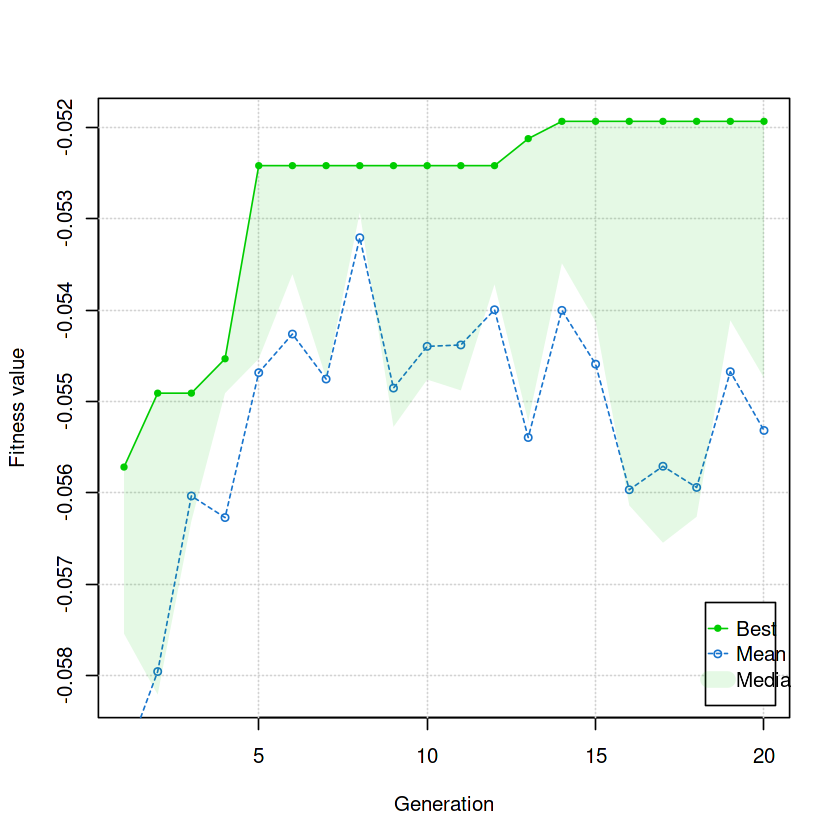

In [8]:
tic()
GA=ga(type='real-valued',fitness=function(x) fit_DT(x[1],x[2],x[3],x[4],x[5]),
      lower=c(0,0,0,0,1e-5),upper=c(0.5,0.5,0.5,0.5,1e-2),maxiter=20,popSize=5,seed=1234,keepBest=TRUE)
summary(GA)
plot(GA)
toc()

In [9]:
summary(GA)

── Genetic Algorithm ─────────────────── 

GA settings: 
Type                  =  real-valued 
Population size       =  5 
Number of generations =  20 
Elitism               =  1 
Crossover probability =  0.8 
Mutation probability  =  0.1 
Search domain = 
       x1  x2  x3  x4    x5
lower 0.0 0.0 0.0 0.0 1e-05
upper 0.5 0.5 0.5 0.5 1e-02

GA results: 
Iterations             = 20 
Fitness function value = -0.05193573 
Solution = 
             x1         x2         x3        x4          x5
[1,] 0.04348379 0.09531648 0.07451101 0.4777842 0.003436511

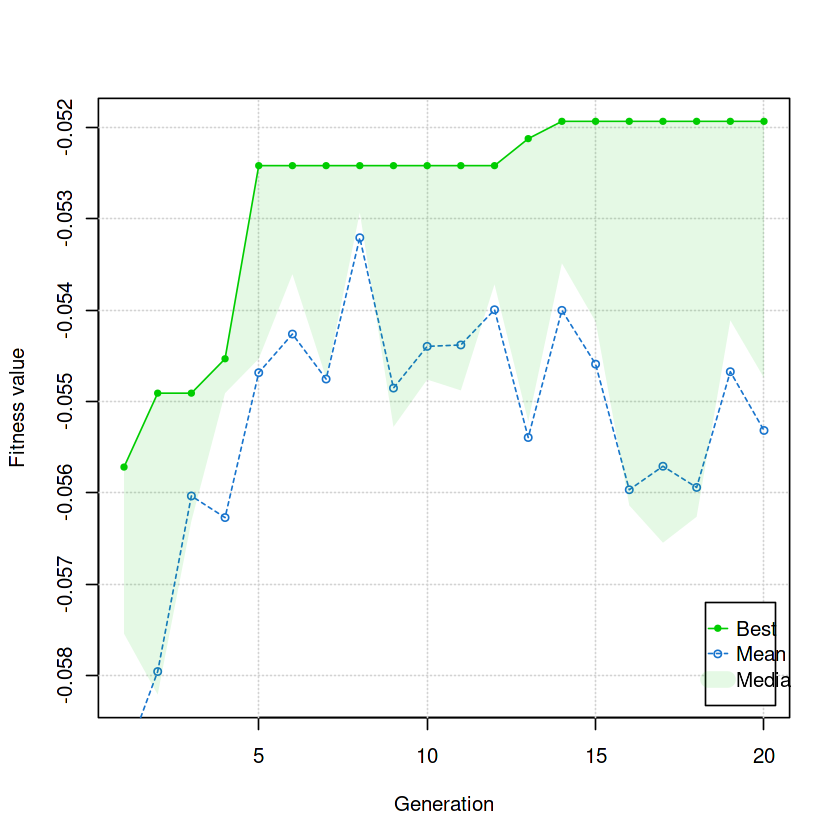

In [10]:
plot(GA)